<a href="https://colab.research.google.com/github/mdazab/DATA5322-Homework-4/blob/main/Final_hofidar_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Code Practical Homework 4: Unsupervised Learning**

# **Introduction**

This project applies unsupervised learning techniques to analyze financial and operational data from Washington State hospitals. The dataset includes information on salaries, staffing, revenue, expenses, facility size, and service volumes for hospital cost centers across multiple institutions and years.

Our goal is to uncover structure in hospital spending patterns and operational practices using PCA, matrix completion, and clustering.

The dataset being analyzed is the Hofidar Cost Center Report provided by the WA State Department of Health Office of Community Health Systems with the data compiled by Carrie Baranowski [1].

# **Data Preparation**

### Data Processing

#### Load Data

In [ ]:
url = "https://raw.githubusercontent.com/mdazab/DATA5322-Homework-4/01ab29286c5ef1532b2ad99474b2236521119465/Hofidar_Cost_Center_Report.csv"
df = pd.read_csv(url)
df.head(2)

Year  License Number                                     Hospital Name  \
0  2018               1  Swedish Health Services DBA Swedish Medical Cent   
1  2019               1  Swedish Health Services DBA Swedish Medical Cent   

   Acct #              Cost Center  ID FTE s  Units of Measure  \
0    6010  ICU or Combined ICU-CCU    293.73             29562   
1    6010  ICU or Combined ICU-CCU    315.34             58040   

   Salaries Wages  Employee Benefits  Professional Fees  ...  Utilities  \
0        30226470            4609431            1896584  ...          0   
1        34310765            5176437            2695345  ...          0   

   Other Noncategorized Expenses  Cost Recoveries  Operating Expenses  \
0                              0             1390            41624622   
1                              0            16480            47653505   

   Allocated Expenses  Plant Sq Feet  Dietary Meals  Housekeeping Hours  \
0            43082868          85986         192205               10901   
1            47164648          85986         225238               11080   

   Laundry Dry Lbs  Nursing FTE s  
0          1292872         192.05  
1          1537737         207.90  

[2 rows x 40 columns]

#### Remove Categorial Variables

Categorical variables were removed for data analysis since they provide no numeric insight. These labels will be re-applied to the data post clustering methods to determine what hospitals tend to be grouped together.

Additionally, the 'Units of Measure' variable was removed from the analysis. The data dictionary [2] provided for the dataset did not provide a clear explanation of what this was and we could not surmise what a realistic meaning for it would be.

In [ ]:
cat_names = df[['Year', 'License Number', 'Hospital Name', 'Acct #', 'Cost Center', 'Units of Measure']]
df_clean = df.drop(columns=['Year', 'License Number', 'Hospital Name', 'Acct #', 'Cost Center', 'Units of Measure'])


### Data QC

#### Evaluation of Columns with Zeros, NaN or Empty Strings

In [ ]:
empty_string_count = (df.astype(str).apply(lambda x: x.str.strip()) == '').sum()
df_vis = df_clean.apply(pd.to_numeric, errors='coerce')

n_rows = len(df_vis)

summary = pd.DataFrame({
    'Zero Count': (df_vis == 0).sum(),
    'NaN Count': df_vis.isna().sum(),
    'Empty String Count': empty_string_count
})
summary['Zero %'] = (summary['Zero Count'] / n_rows) * 100
summary['NaN %'] = (summary['NaN Count'] / n_rows) * 100
summary['Empty String %'] = (summary['Empty String Count'] / n_rows) * 100

summary = summary[(summary['Zero Count'] > 0) |
                  (summary['NaN Count'] > 0) |
                  (summary['Empty String Count'] > 0)]

summary = summary.sort_values(by='Zero Count', ascending=False)

summary.style.format({
    'Zero %': '{:.2f}%',
    'NaN %': '{:.2f}%',
    'Empty String %': '{:.2f}%',
    'Zero Count': '{:,}',
    'NaN Count': '{:,}',
    'Empty String Count': '{:,}'
})


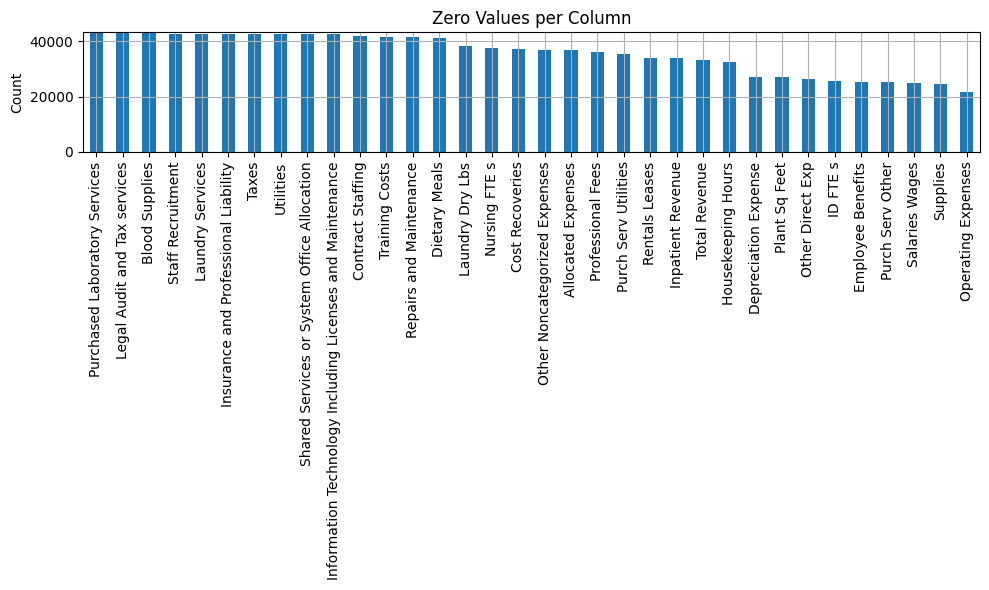

In [ ]:
zero_counts = (df_vis == 0).sum().sort_values(ascending=False)
zero_counts = zero_counts[zero_counts > 0]

plt.figure(figsize=(10, 6))
zero_counts.plot(kind='bar')
plt.ylim(0, len(df_vis))
plt.title("Zero Values per Column")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

The data set contains a lot of zero entries and no NaN entries, possibly indicating that what should be labeled as missing data could still be present in the data, but represented by a 0. However, many rows do contain some numbers while others within that row are 0, and these values could make sense. For example, the "Electrodiagnosis" department within the Swedish Medical Center has numeric entries for multiple columns, but has only values of 0 for blood supply over the years; this is likely a real reported value, since it would be reasonable to assume that the Electrodiagnosis department probably does not have a blood supply.

Within that same hospital though, the Semi-Intensive & Intermediate Care department only reported 0's for every entry. This likely does not indicate that this department has 0 funding or employees, but that it failed to report the numbers specific to this department for the data set.

Provided the high number of 0 entries, we decided to aggregate the data points by hospital and year. This will allow us to reduce the noise from cost centers with lots of missing data, and would allow us to focus on hospital-wide trends, not departmental operations.

#### Evaluation of Min and Max Values

In [ ]:
df_clean.agg(['min','max'])

ID FTE s  Salaries Wages  Employee Benefits  Professional Fees  \
min    -36.48         -761454         -109155505           -1049285   
max  97033.00       290573711           72545047          172233103   

      Supplies  Purch Serv Utilities  Purch Serv Other  Rentals Leases  \
min   -6926603               -103178         -19253644       -30881934   
max  452097193              10322174         280565951        16927101   

     Depreciation Expense  Other Direct Exp  ...  Utilities  \
min              -2504590          -4190997  ...       -600   
max              47003801         448780010  ...   13601931   

     Other Noncategorized Expenses  Cost Recoveries  Operating Expenses  \
min                       -5885978        -85074181          -298080796   
max                      448780010       1091802923           907130783   

     Allocated Expenses  Plant Sq Feet  Dietary Meals  Housekeeping Hours  \
min            -1734373              0              0                   0   
max           123161645        1117328        1973965             1387160   

     Laundry Dry Lbs  Nursing FTE s  
min                0          -0.15  
max          8077503       69379.25  

[2 rows x 34 columns]

We observed some columns in the raw data set contained negative values. We will proceed to inspect their distribution

#### Boxplot of Column Values

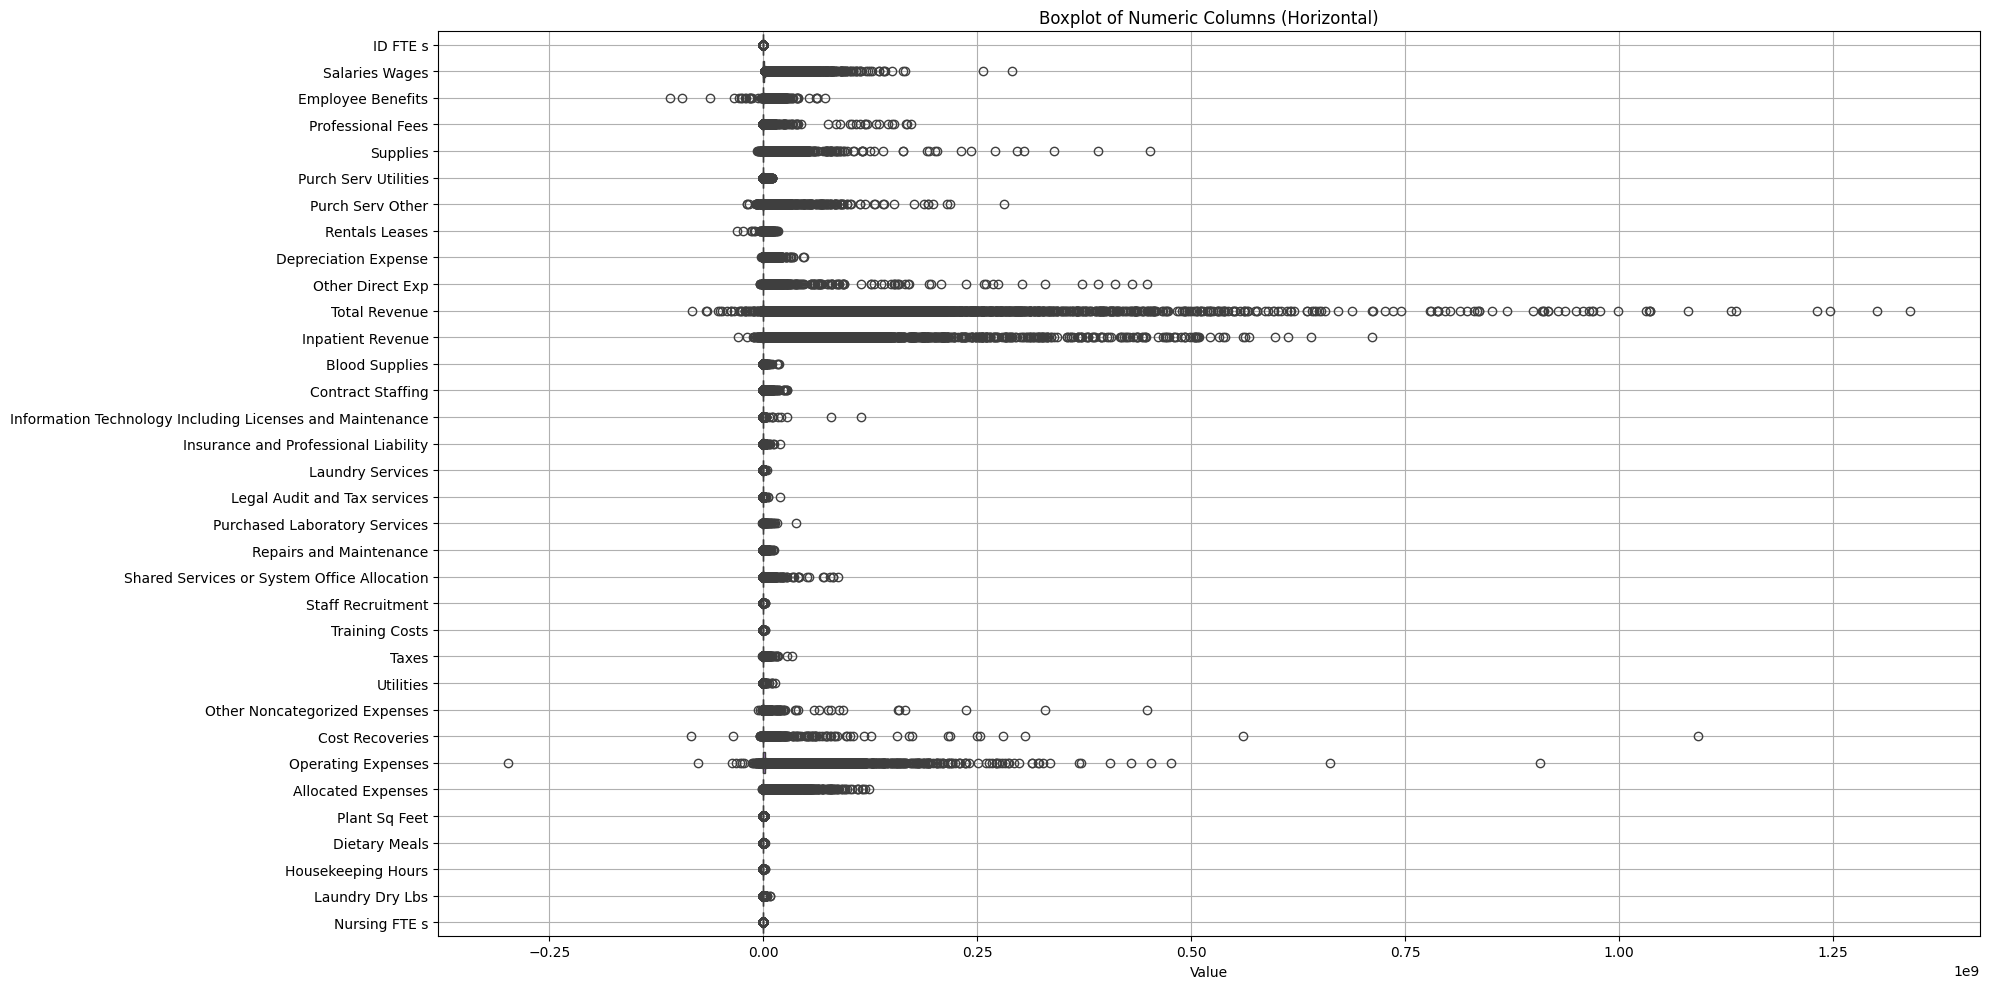

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_vis, orient='h')
plt.title("Boxplot of Numeric Columns (Horizontal)")
plt.xlabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

Overall spread of numerical values is right-skewed. Notable there are some features like Total Revenue, Inpatient Revenue, and Operating Expenses that have some extreme values.

Some values in Operating Expenses, Cost Recoveries are negative, this could be due to reporting syle or refunds. Negative values warrant further inspection.

In [ ]:
neg_counts_by_column = (
    df[df.select_dtypes(include='number').lt(0).any(axis=1)]
    .melt(value_vars=df.select_dtypes(include='number').columns)
    .query('value < 0')
    .groupby('variable')
    .size()
    .reset_index(name='Negative Count')
    .sort_values(by='Negative Count', ascending=False)
)

print(neg_counts_by_column.to_string(index=False))

                                                 variable  Negative Count
                                                 Supplies             471
                                         Other Direct Exp             394
                                       Operating Expenses             335
                                         Purch Serv Other             298
                                           Rentals Leases             231
                            Other Noncategorized Expenses             211
                                          Cost Recoveries             199
                                        Professional Fees             162
                                        Inpatient Revenue             118
                                            Total Revenue              90
                                        Employee Benefits              89
                                        Contract Staffing              78
                                     P

####  Columns with Negative Values

- Financial: Salaries Wages, Supplies, Depreciation Expense, Total Revenue
- Staffing: ID FTEs, Nursing FTEs
- Resources: Utilities, Purchased Laboratory **Services**

#### Commonalities for Negative Values

In [ ]:
neg_summary = (
    df[df.select_dtypes(include='number').lt(0).any(axis=1)]
    .groupby(['Cost Center'])
    .size()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
)

print(neg_summary.to_string(index=False))


                        Cost Center  Count
               Other Admin Services    168
                         Purchasing    139
                   Central Services    134
            Hospital Administration     94
                            Dietary     64
           Other Ancillary Services     64
                  Laundry and Linen     53
             Other General Services     51
             Radiology - Diagnostic     47
                         Acute Care     47
                         Anesthesia     42
                              Plant     40
                            Clinics     40
                          Personnel     39
                       Housekeeping     38
                   Physical Therapy     38
                   Patient Accounts     37
                    Data Processing     37
                           Pharmacy     36
             Nursing Administration     35
Accounting or Total Fiscal Services     35
                Respiratory Therapy     34
           

Multiple negative value exist within the data set. It is unclear if these values were accurately reported as negative or if this is an instance of incorrectly added data, and the data dictionary does not provide an expected range of values for each variable.

For example, a negative total revenue could mean that a hospital ran at a net-loss. But the distinction is less clear for a variable like employee benefits: if we assume negative employee benefits means that it was something the hospital had to pay, then a positive value would somehow indicate that this was something the hospital profitted from, though providing employee benefits should always be a cost to an employer.

We decided to leave the negative entries unchanged for now. Due to how many variables have negative values, the concern was that trying to apply logic to each negative entry per variable would be to some degree a guess, and could lead to some degree of cherry-picking of the data.

### Data Aggregation


In [ ]:
df_agg = df.groupby(['Hospital Name', 'Year'], as_index=False).sum(numeric_only=True)
df_agg.describe()


Year  License Number         Acct #      ID FTE s  \
count   566.000000      566.000000     566.000000    566.000000   
mean   2020.643110    13823.962898  584164.893993   1310.704081   
std       1.809468    16833.898938   88099.158635   4301.365417   
min    2018.000000        8.000000    9000.000000      0.000000   
25%    2019.000000     4666.500000  601720.000000    184.110000   
50%    2021.000000    11120.000000  610720.000000    502.600000   
75%    2022.000000    14833.500000  610720.000000   1451.792500   
max    2024.000000    74240.000000  610720.000000  97253.940000   

       Units of Measure  Salaries Wages  Employee Benefits  Professional Fees  \
count      5.660000e+02    5.660000e+02       5.660000e+02       5.660000e+02   
mean       2.418578e+06    1.153027e+08       2.411402e+07       1.303145e+07   
std        4.068454e+06    1.566191e+08       3.510042e+07       2.788329e+07   
min        0.000000e+00    0.000000e+00      -1.627202e+06      -7.251000e+03   
25%        1.821770e+05    1.482129e+07       3.388254e+06       1.550579e+06   
50%        7.847020e+05    4.134682e+07       8.312048e+06       4.863402e+06   
75%        2.526792e+06    1.488031e+08       2.919634e+07       1.187731e+07   
max        3.438331e+07    9.360426e+08       2.529480e+08       2.444690e+08   

           Supplies  Purch Serv Utilities  ...     Utilities  \
count  5.660000e+02          5.660000e+02  ...  5.660000e+02   
mean   5.149089e+07          1.896263e+06  ...  2.134833e+05   
std    8.610424e+07          2.807009e+06  ...  1.313928e+06   
min   -1.447030e+05          0.000000e+00  ...  0.000000e+00   
25%    2.171296e+06          2.575232e+05  ...  0.000000e+00   
50%    1.423115e+07          7.946115e+05  ...  0.000000e+00   
75%    6.695834e+07          2.359007e+06  ...  0.000000e+00   
max    5.993350e+08          1.680769e+07  ...  1.786008e+07   

       Other Noncategorized Expenses  Cost Recoveries  Operating Expenses  \
count                   5.660000e+02     5.660000e+02        5.660000e+02   
mean                    5.844759e+06     1.928849e+07        2.922959e+08   
std                     3.147067e+07     7.650348e+07        4.007025e+08   
min                     0.000000e+00    -1.376640e+05        0.000000e+00   
25%                     0.000000e+00     0.000000e+00        3.244036e+07   
50%                     0.000000e+00     7.869140e+05        1.027708e+08   
75%                     8.098582e+05     1.045266e+07        4.133790e+08   
max                     4.646916e+08     1.261258e+09        2.915316e+09   

       Allocated Expenses  Plant Sq Feet  Dietary Meals  Housekeeping Hours  \
count        5.660000e+02   5.660000e+02   5.660000e+02        5.660000e+02   
mean         5.259605e+07   3.772668e+05   1.252131e+05        1.097257e+05   
std          1.086694e+08   4.994270e+05   2.167652e+05        4.199631e+05   
min          0.000000e+00   0.000000e+00   0.000000e+00        0.000000e+00   
25%          0.000000e+00   7.021650e+04   8.108500e+03        1.065000e+04   
50%          4.795185e+06   1.587980e+05   3.405550e+04        3.871150e+04   
75%          4.637464e+07   5.735058e+05   1.518825e+05        1.088110e+05   
max          7.397069e+08   3.200145e+06   2.123480e+06        6.418778e+06   

       Laundry Dry Lbs  Nursing FTE s  
count     5.660000e+02     566.000000  
mean      8.010679e+05     433.369735  
std       1.732177e+06    2952.122512  
min       0.000000e+00       0.000000  
25%       3.455425e+04      41.477500  
50%       2.400475e+05     112.470000  
75%       9.914502e+05     377.970000  
max       2.447000e+07   69794.250000  

[8 rows x 38 columns]

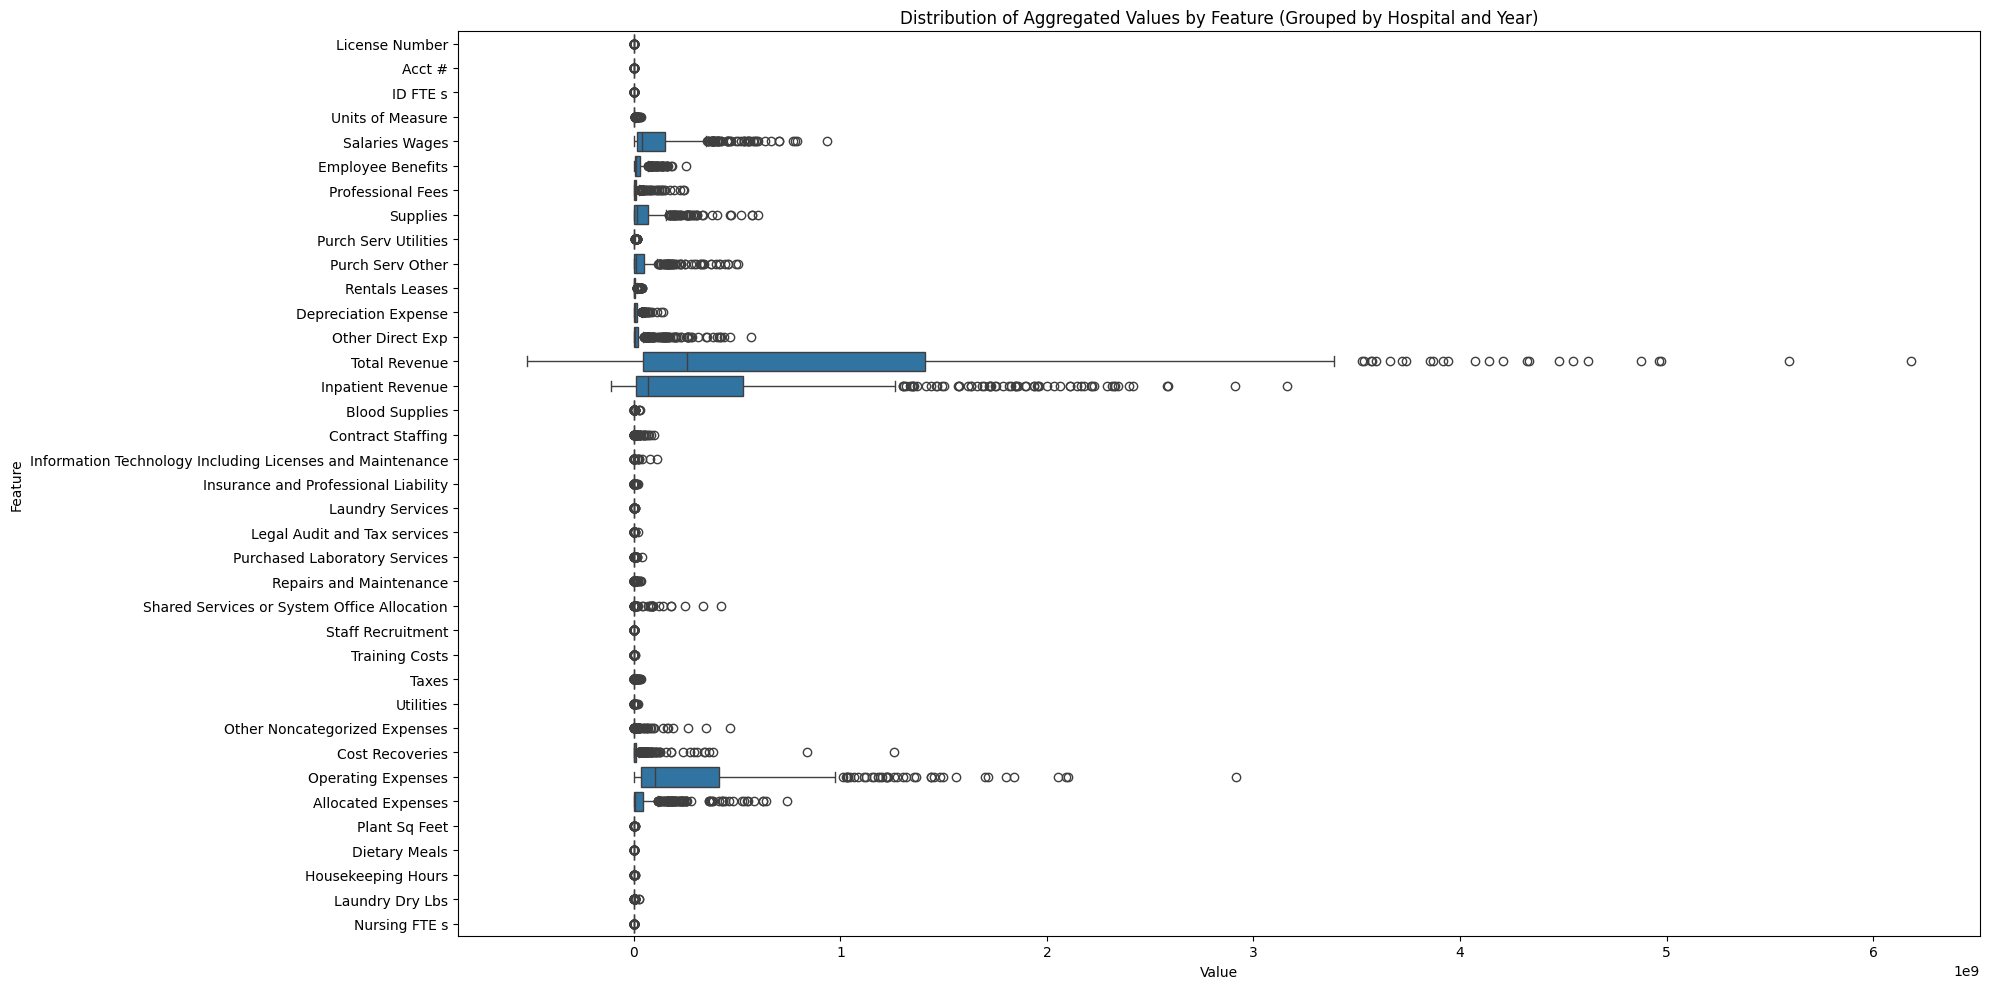

In [ ]:
df_grouped = df.groupby(['Hospital Name', 'Year'], as_index=False).sum(numeric_only=True)
df_melted = df_grouped.melt(id_vars=['Hospital Name', 'Year'], var_name='Feature', value_name='Value')

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_melted, x='Value', y='Feature', orient='h')
plt.title("Distribution of Aggregated Values by Feature (Grouped by Hospital and Year)")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

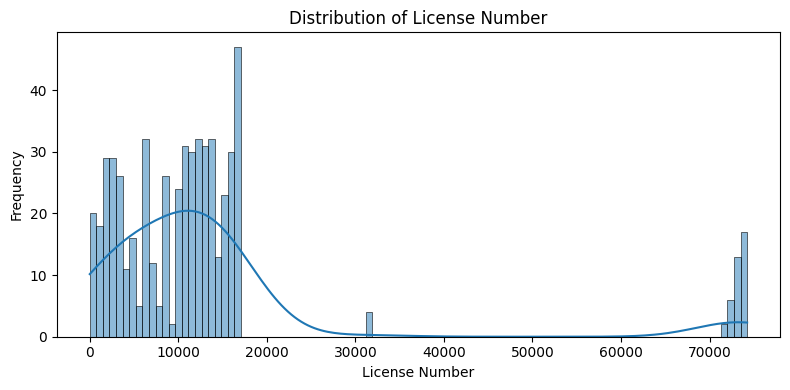

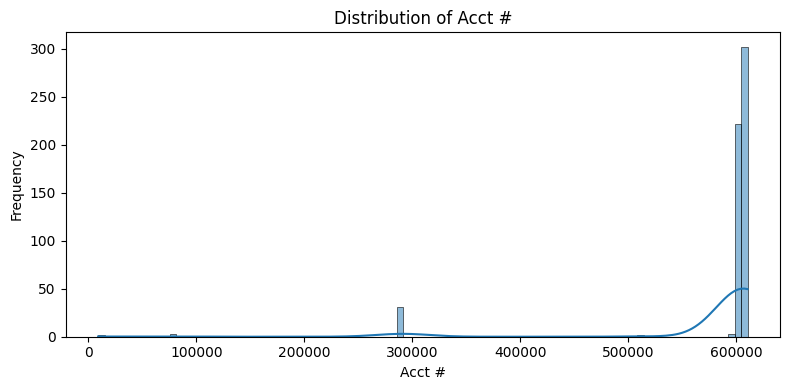

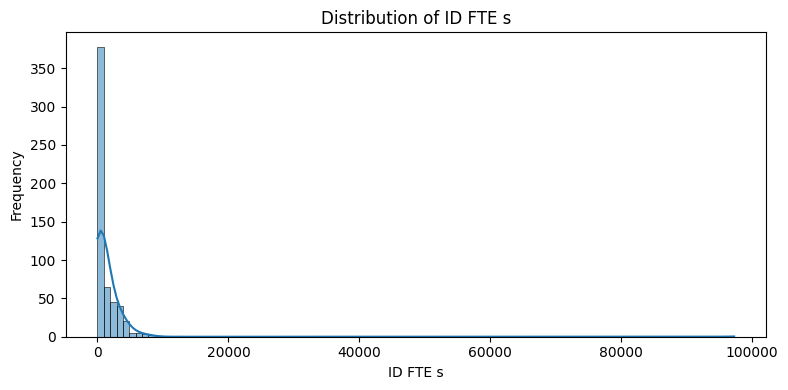

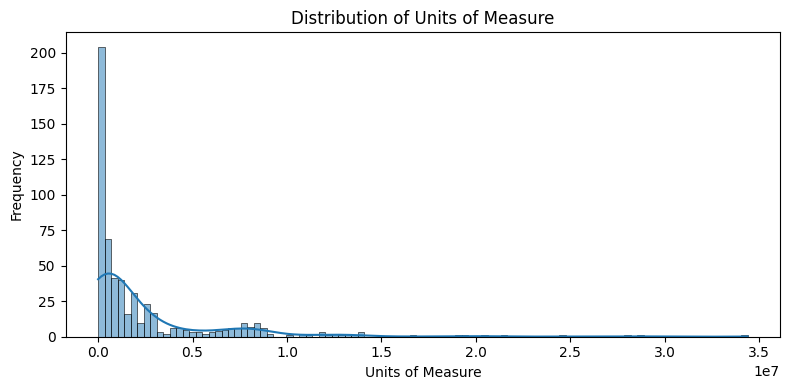

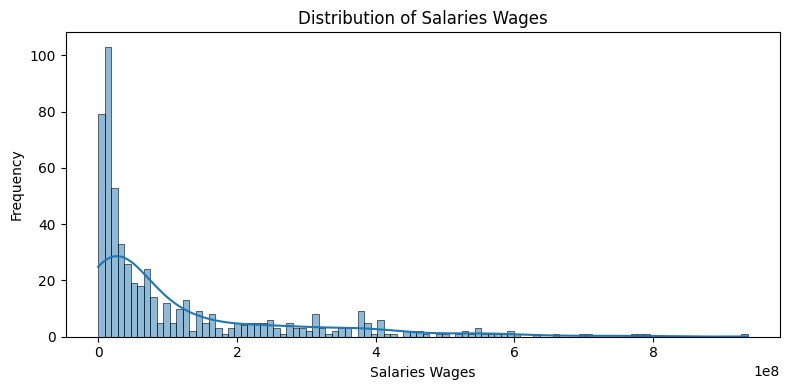

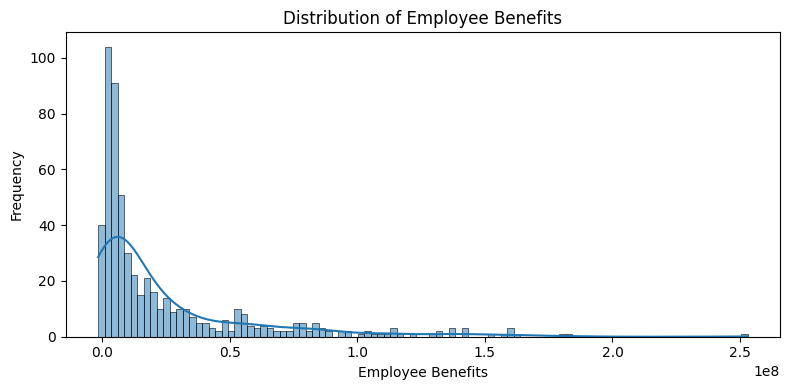

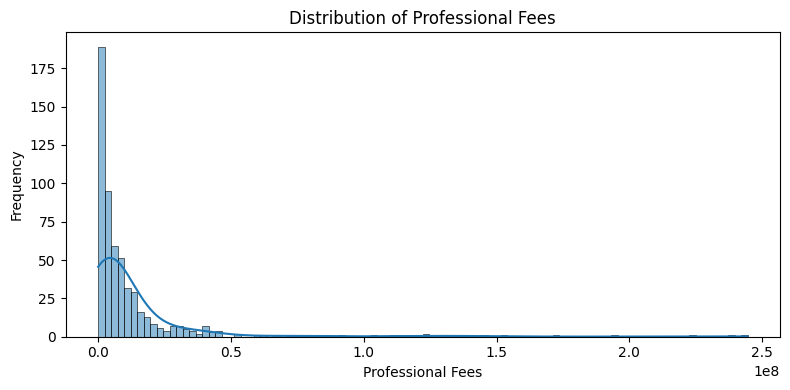

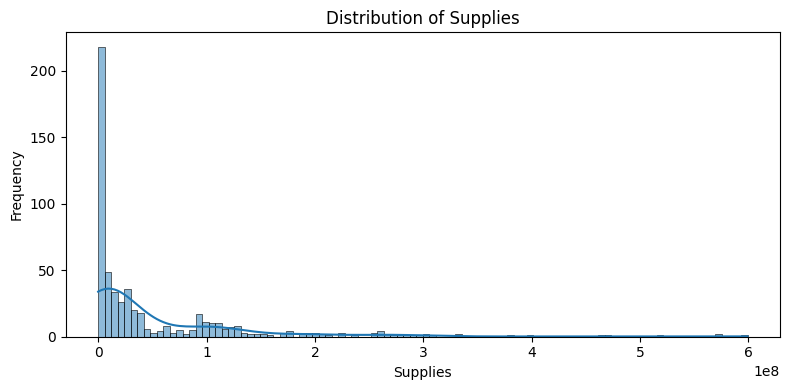

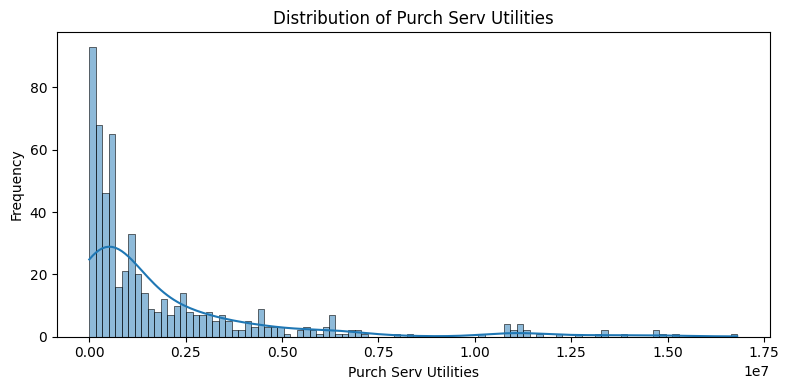

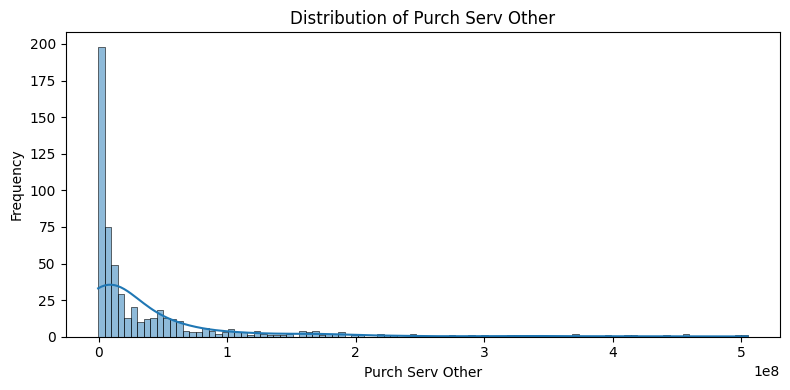

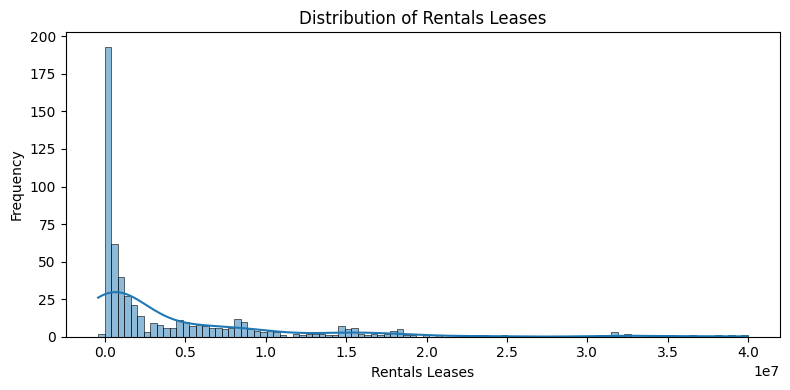

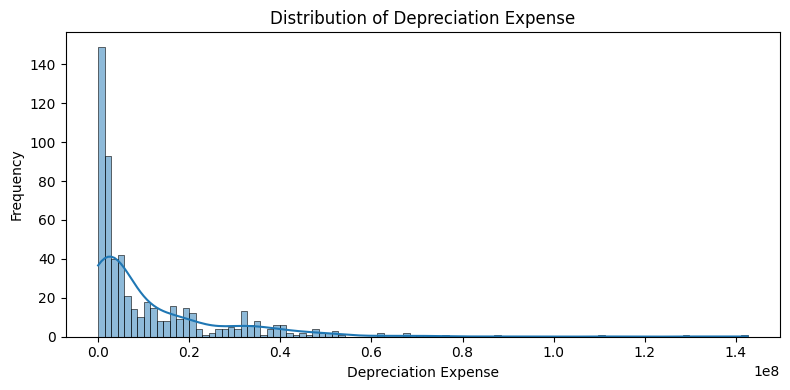

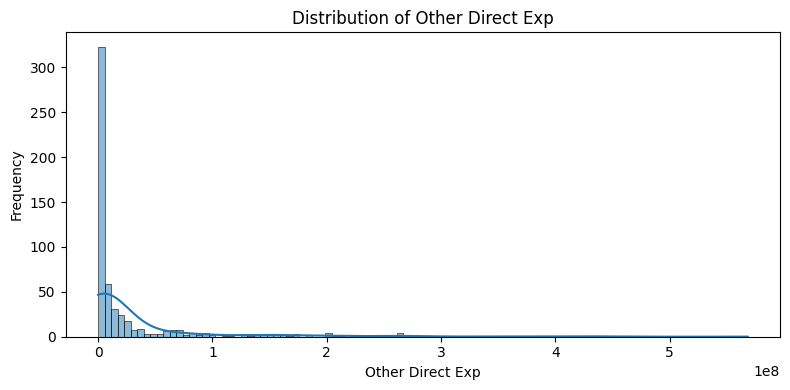

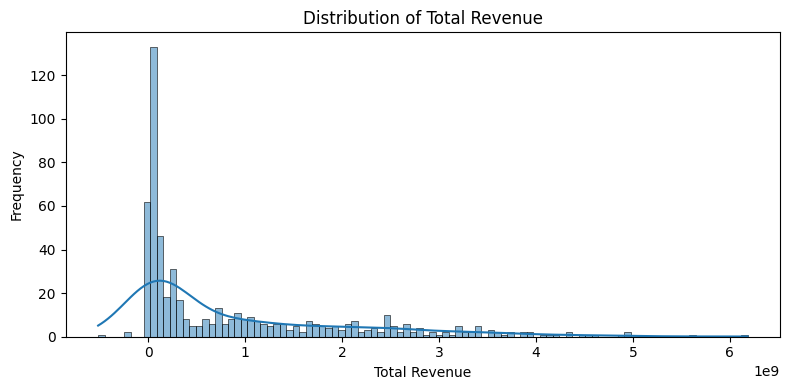

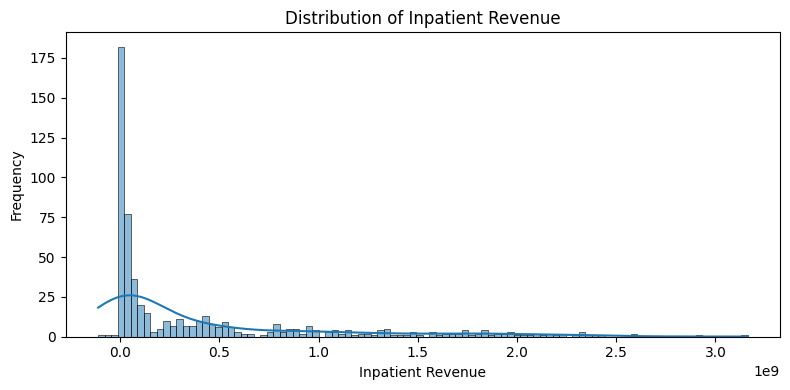

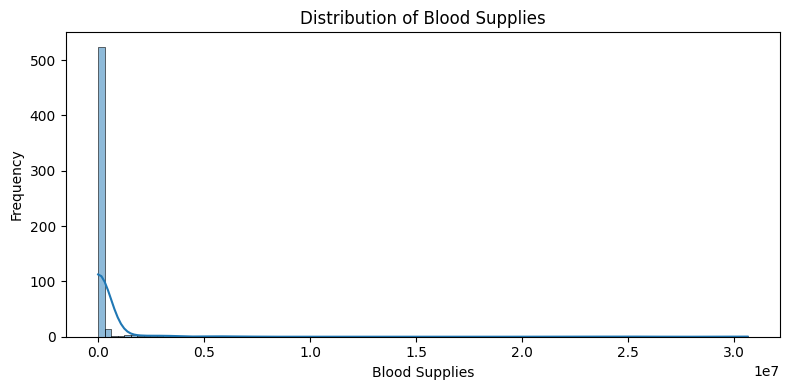

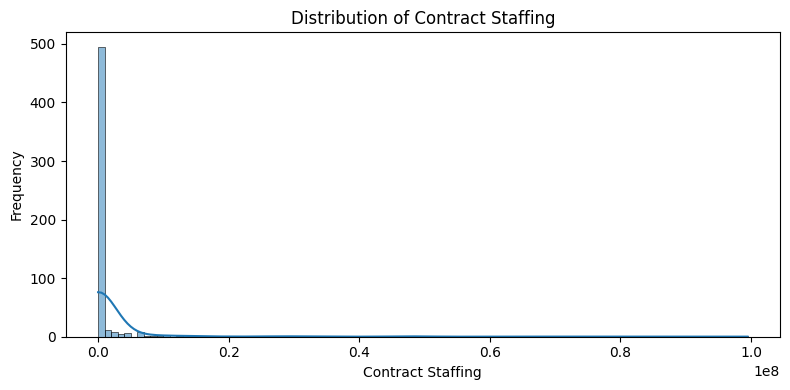

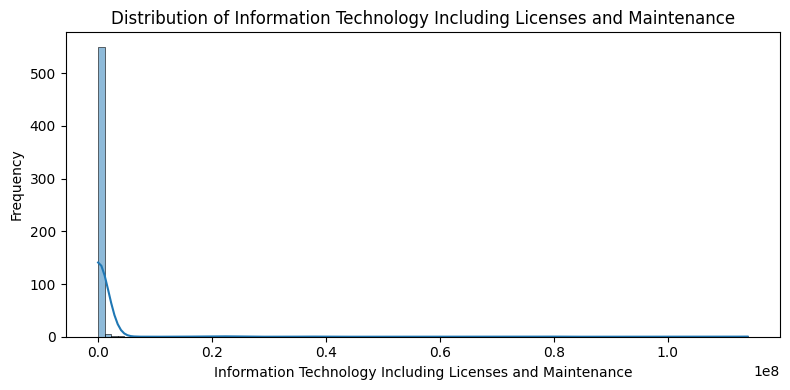

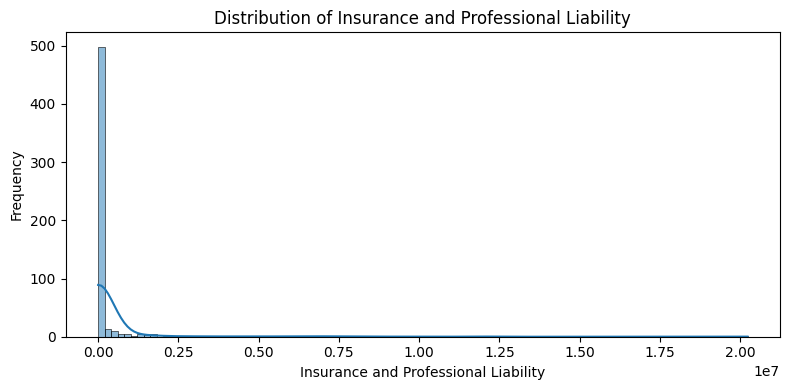

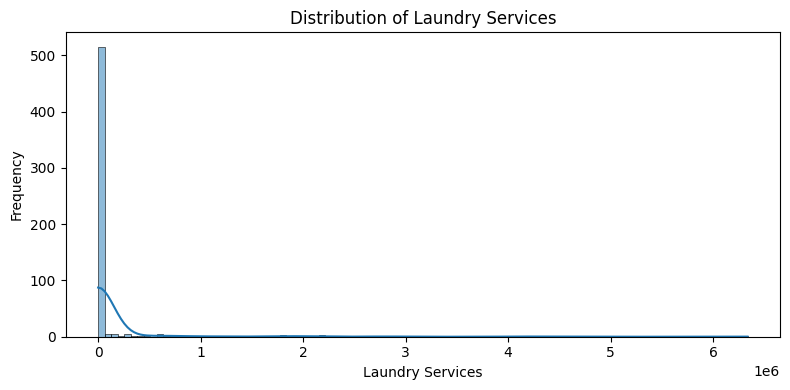

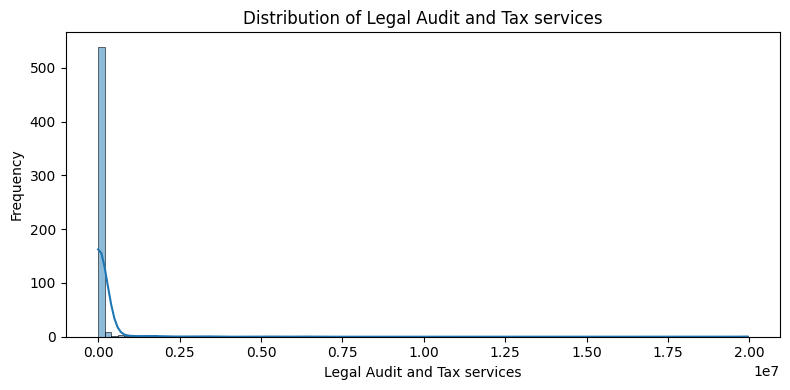

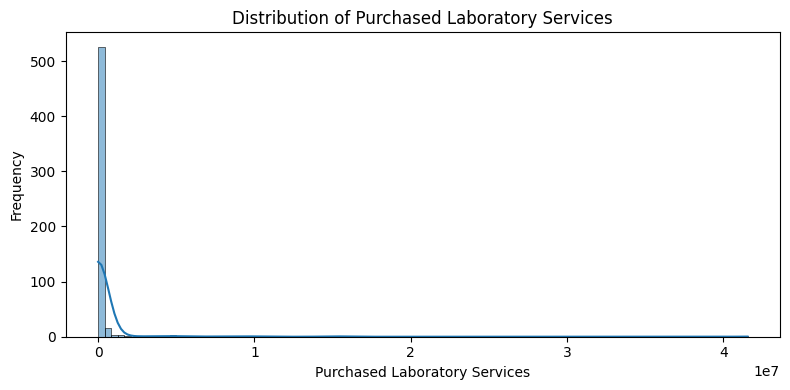

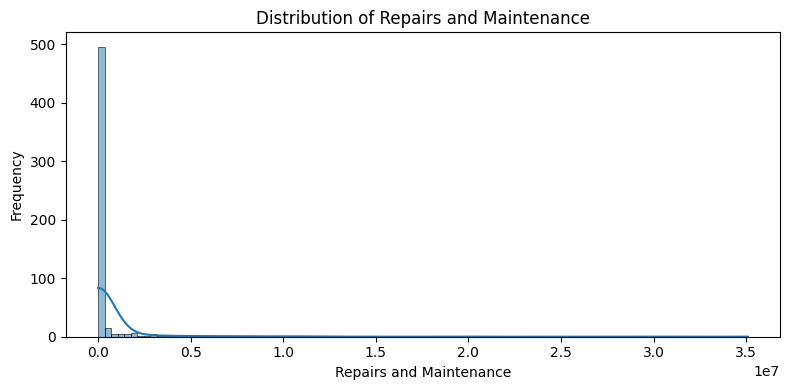

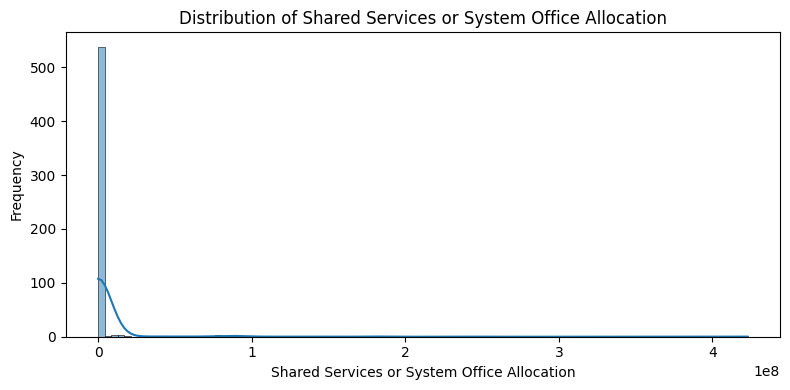

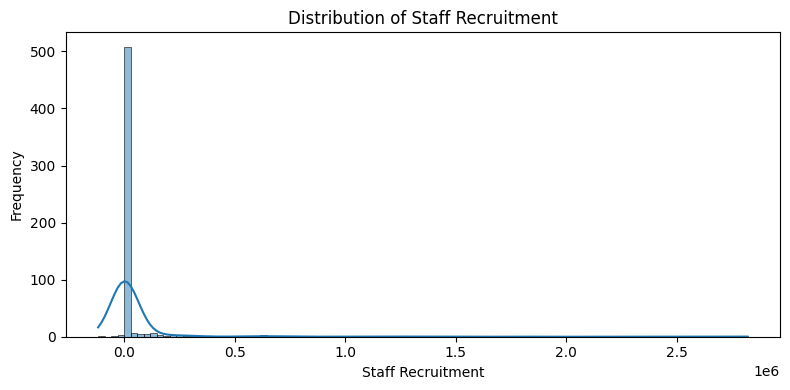

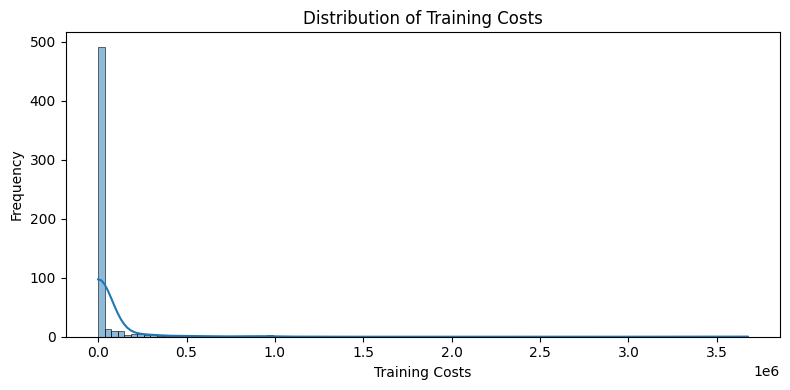

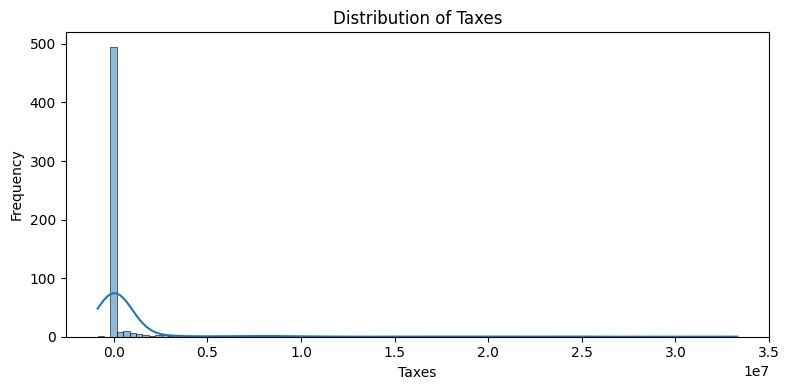

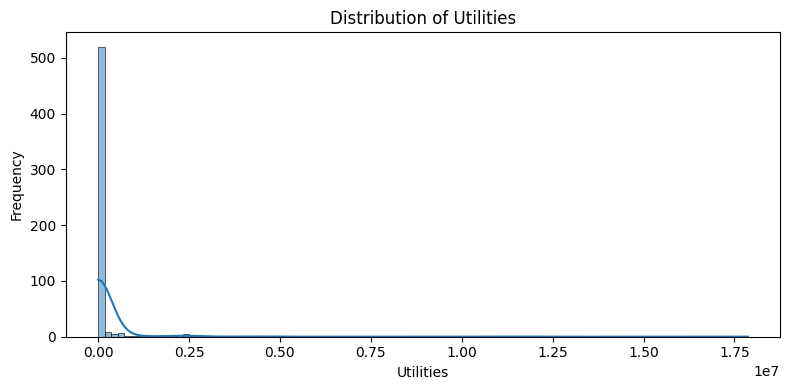

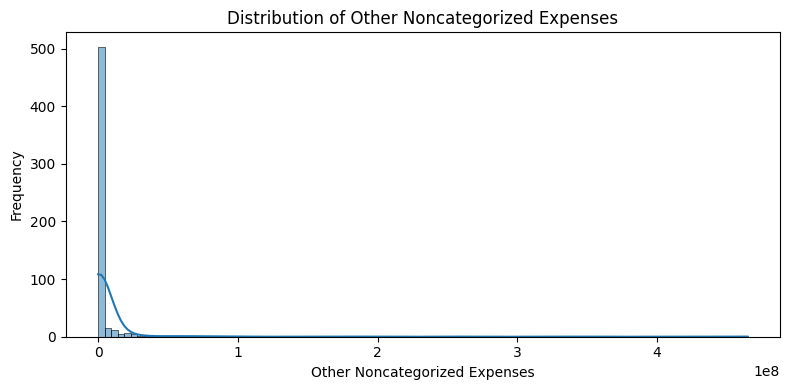

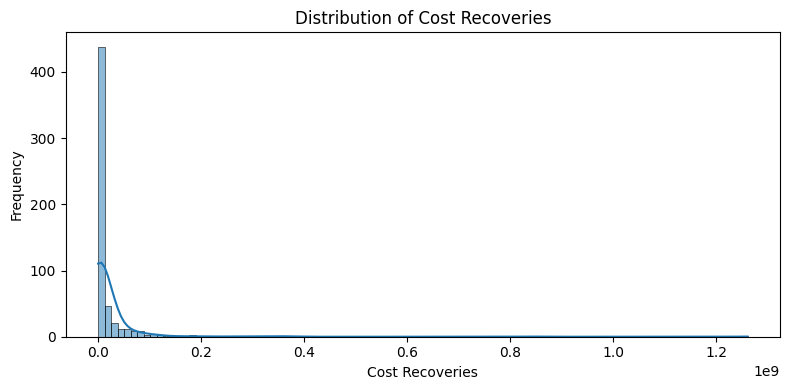

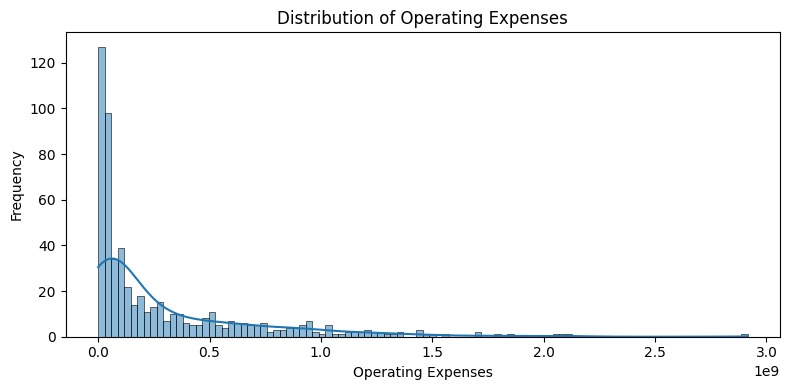

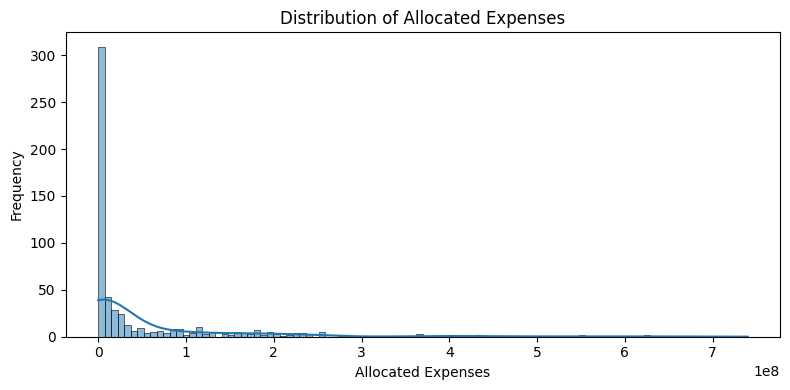

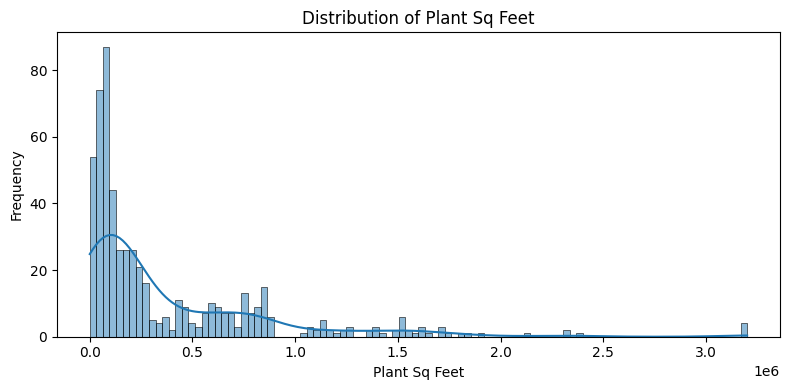

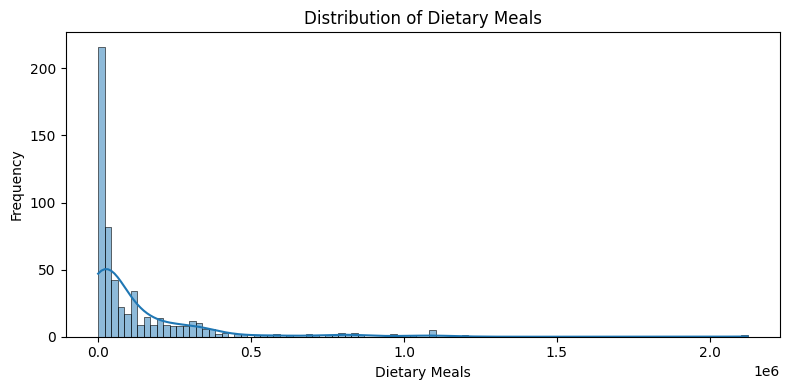

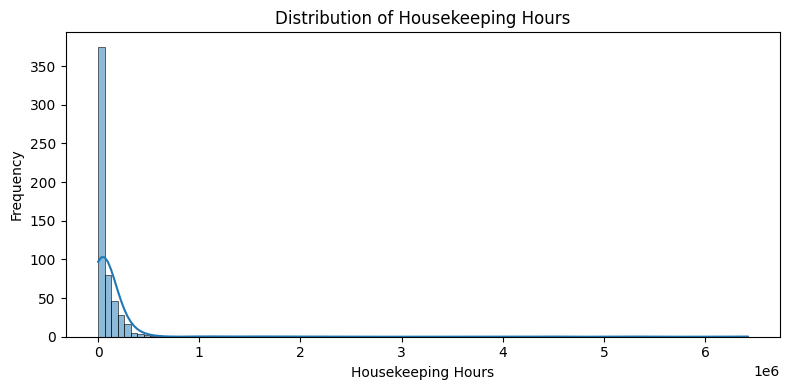

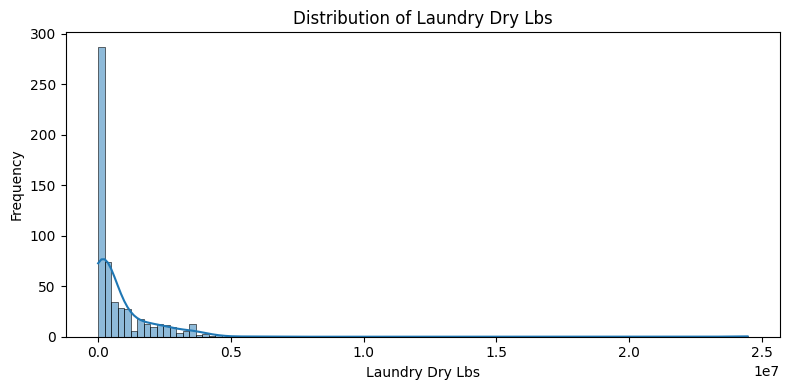

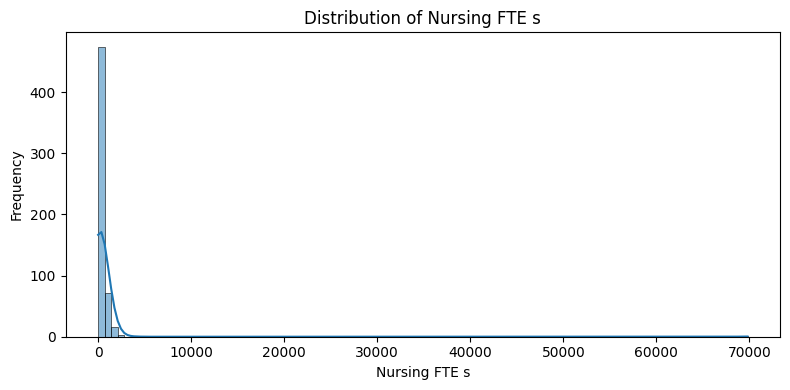

In [ ]:
numeric_cols = [col for col in df_agg.select_dtypes(include='number').columns if col != 'Year']

# Plot distribution for each
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_agg[col], kde=True, bins=100)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

### Data Imputation and Scaling

Note:
- We remove ID FTE values from Cascade Valley Hospital and Nursing FTEs from Rainier Springs before aggregating.
- We then remove the information from Grays Harbor Count from 2021
- Remove information from Klickitat from 2021
- Remove information from Providence Swedish Rehabilitation Hospital from 2024

In [ ]:
df.loc[
    (df['Year'] == 2021) &
    (df['License Number'] == 106) &
    (df['Hospital Name'].str.strip() == 'CASCADE VALLEY HOSPITAL') &
    (df['Cost Center'].str.strip() == 'Laboratory (Including Blood Bank)') &
    (df['ID FTE s'] > 10000),
    'ID FTE s'
] = np.nan

df.loc[
    (df['Year'] == 2023) &
    (df['License Number'] == 925) &
    (df['Hospital Name'].str.strip() == 'Rainier Springs') &
    (df['Cost Center'].str.strip() == 'Psychiatric Care') &
    (df['Nursing FTE s'] > 10000),
    'Nursing FTE s'
] = np.nan

remove = (
    ((df['Hospital Name'].str.strip()== 'Grays Harbor Count') & (df['Year'] == 2021)) |
    ((df['Hospital Name'].str.strip()== 'Klickitat County Public Hospital District #1') & (df['Year'] == 2021)) |
    ((df['Hospital Name'].str.strip()== 'Providence Swedish Rehabilitation Hospital') & (df['Year'] == 2024))
)

df = df[~remove]
#NOTE to EDITOR I split this cell into two pieces where I do matrix completion
meta_cols = ['Hospital Name', 'Year', 'License Number', 'Acct #', 'Cost Center', 'Units of Measure']
df_numeric = df.drop(columns=meta_cols).apply(pd.to_numeric, errors='coerce')
df_agg = pd.concat([df[['Hospital Name', 'Year']], df_numeric], axis=1)
df_agg = df_agg.groupby(['Hospital Name', 'Year']).sum(numeric_only=True).reset_index()

df_meta = df[meta_cols].reset_index(drop=True)
numeric_cols = [col for col in df_agg.columns if col not in ['Hospital Name', 'Year']]

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_agg[numeric_cols]), columns=numeric_cols)

Looking at the histograms, some variables contain data points that are very likely outliers. For instance, we found that the ID FTE values from Cascade Valley Hospital and Nursing FTEs from Rainier Springs were magnitudes higher than any other value for each of those variables, so these were assumed to be outliers and misentered data. Further work will be done to determine how to best handle these data entries.

Post agglomeration, there were still 3 Hospital+Year entries that contained all zeros: Grays Harbor County 2021, Klickitat County Public Hospital District #1 2021, and Providence Swedish Rehabilitation Hospital 2024. We decided to drop these rows, since we assumed these to be instances of NaN's instead of 0s. Additionally, having the exact same values within these three samples would likely lead to them always being grouped together and possibly skewing the analysis, and would not really provide much insight into actual interpretations for the rest of the hospital data.

#### Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

### Final Dataset


Distribution of Scaled Data

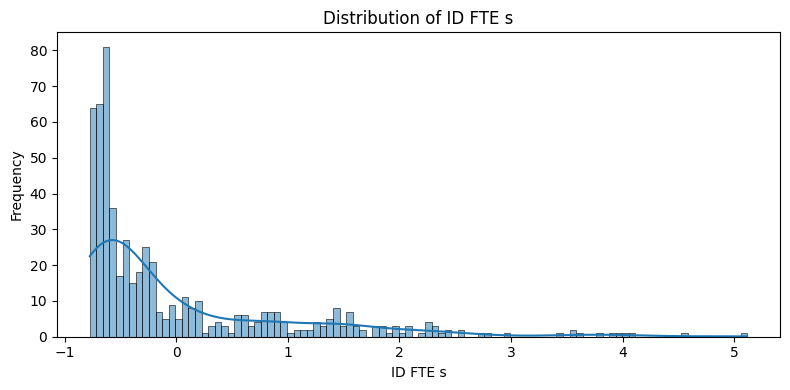

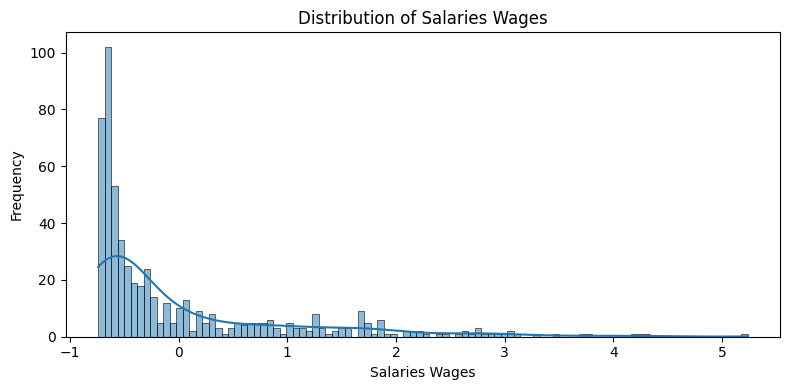

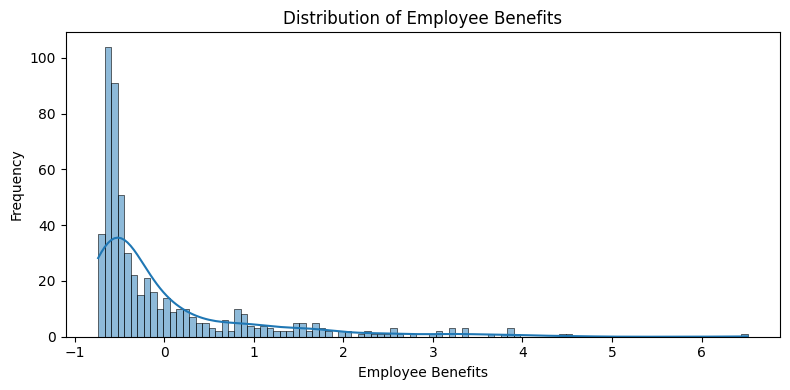

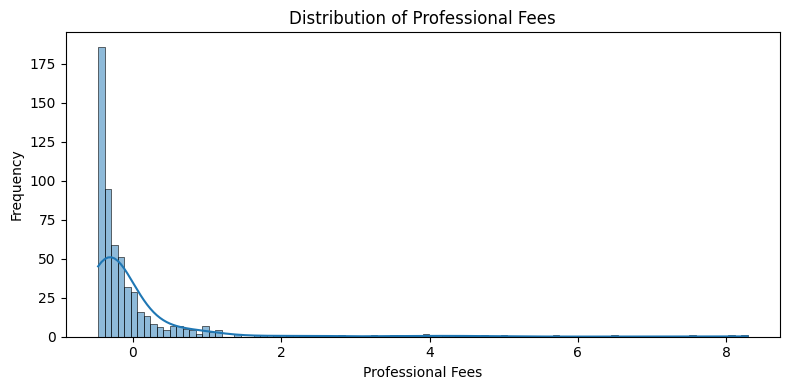

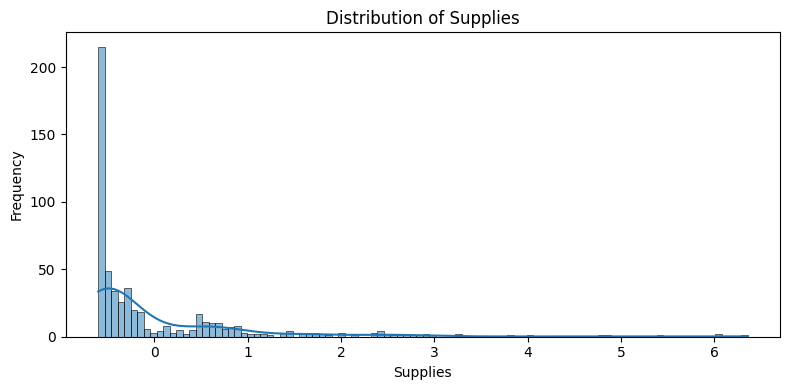

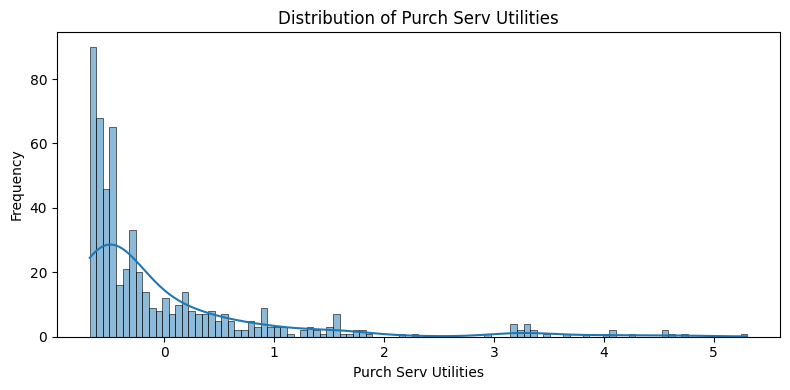

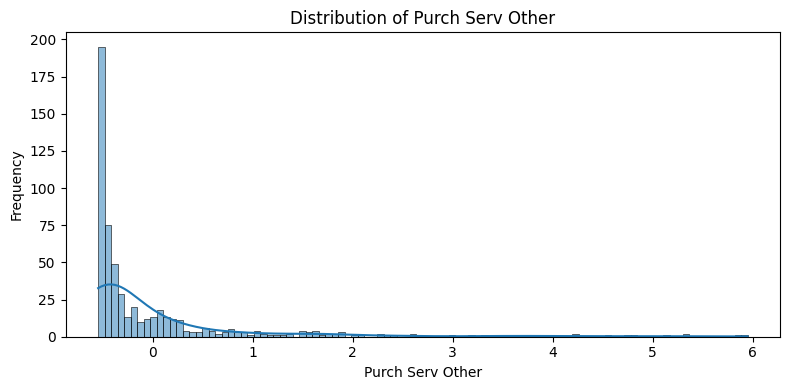

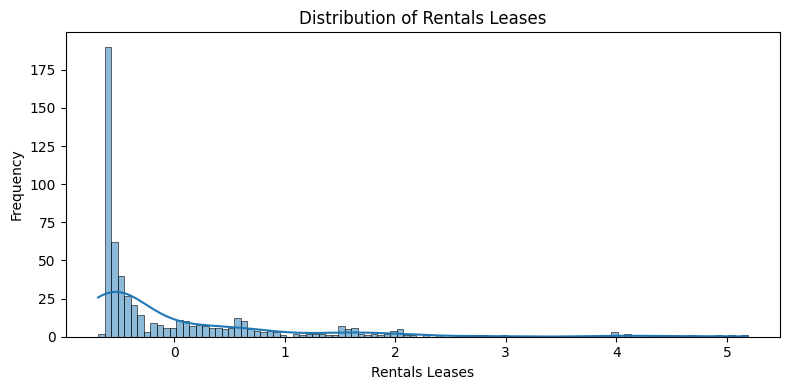

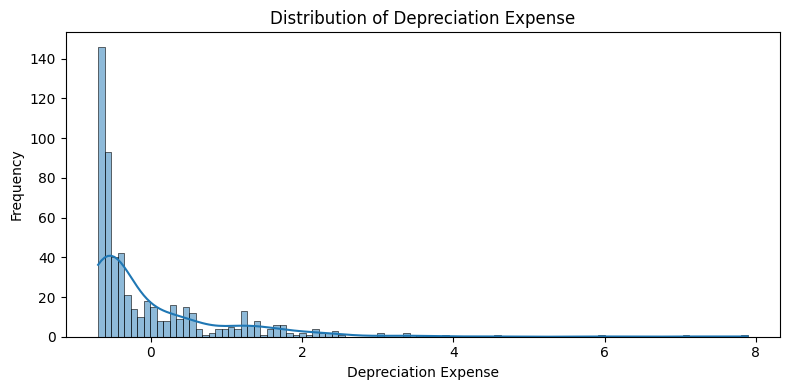

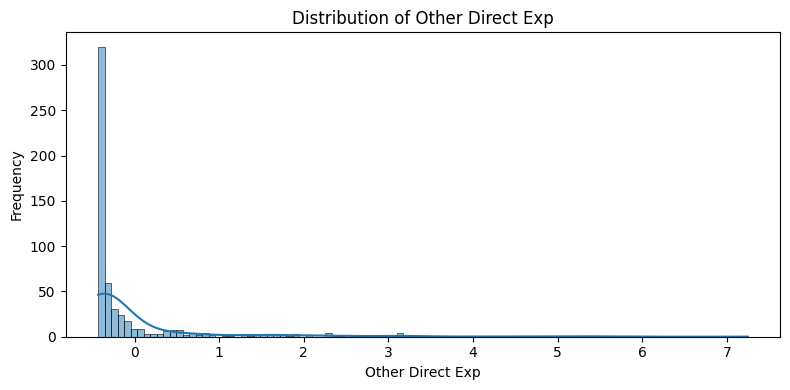

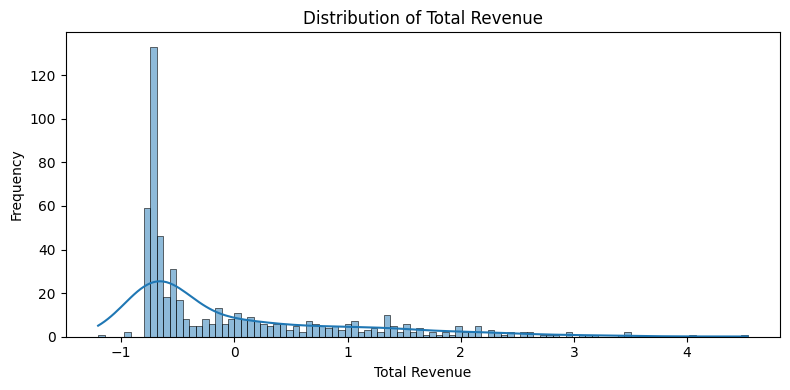

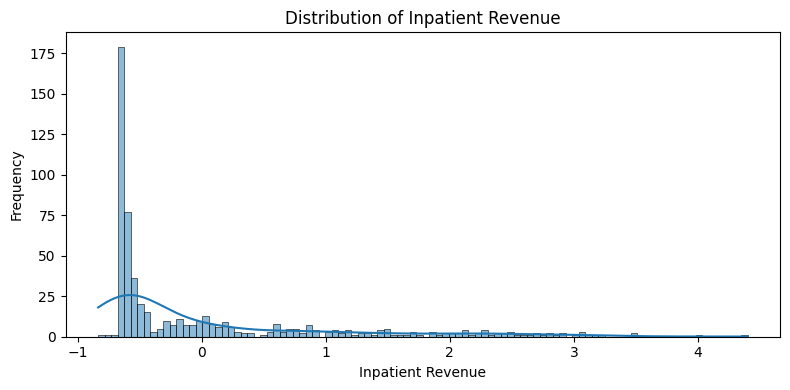

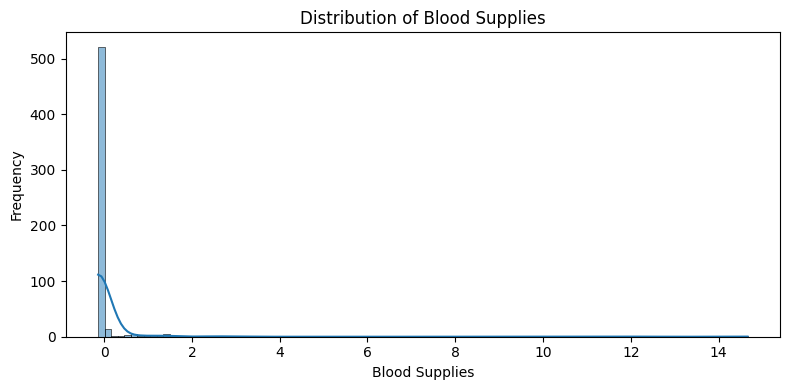

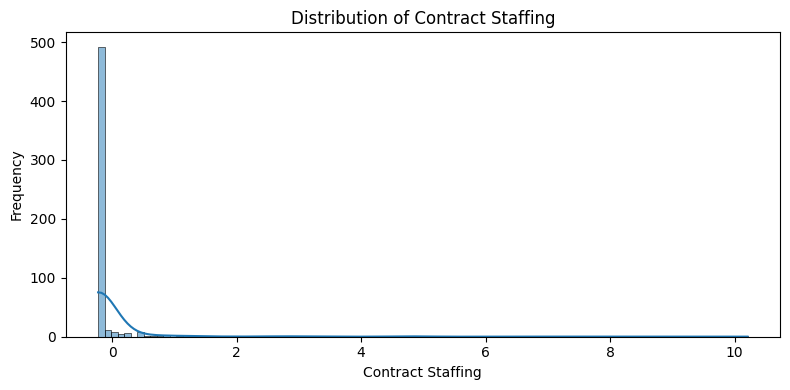

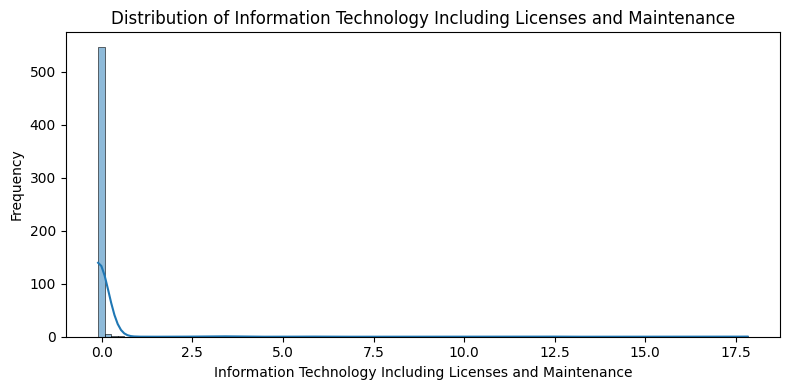

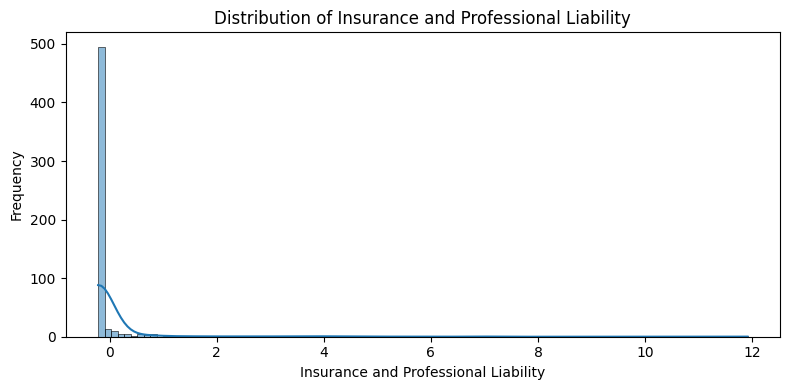

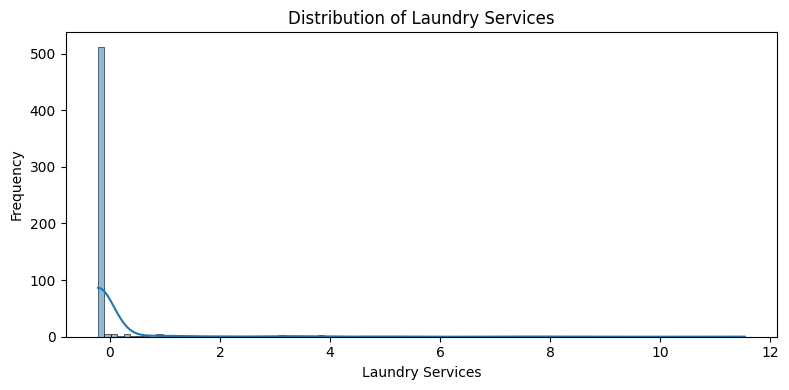

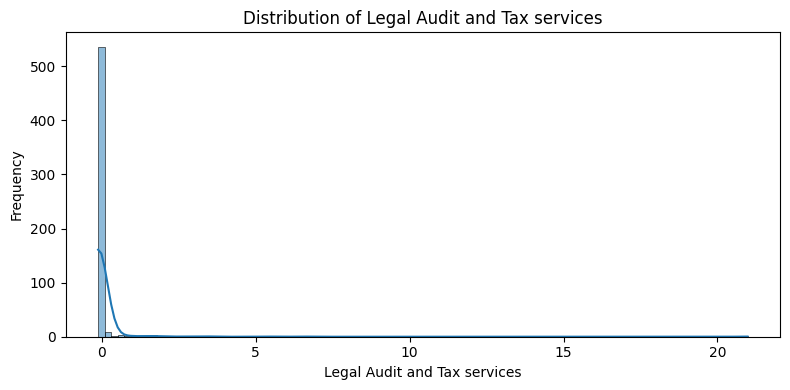

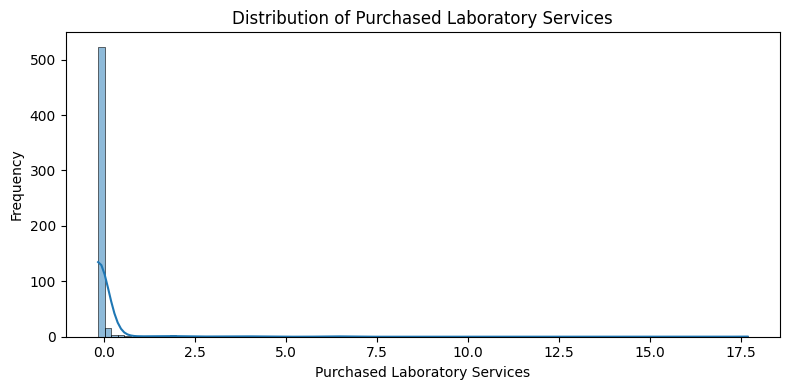

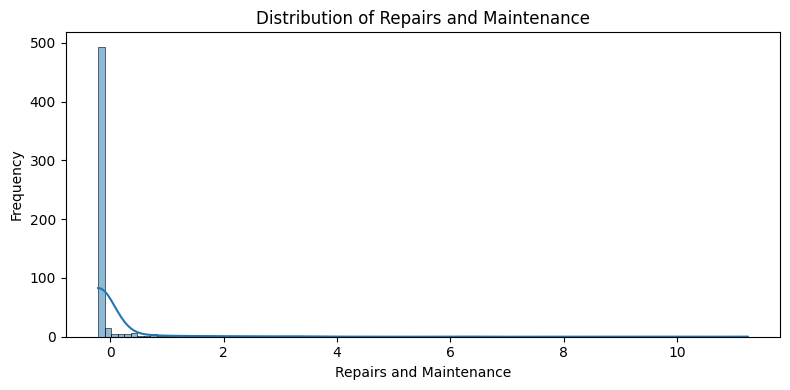

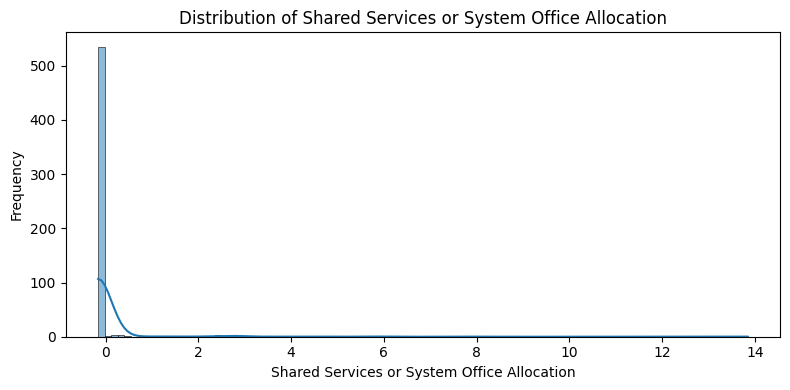

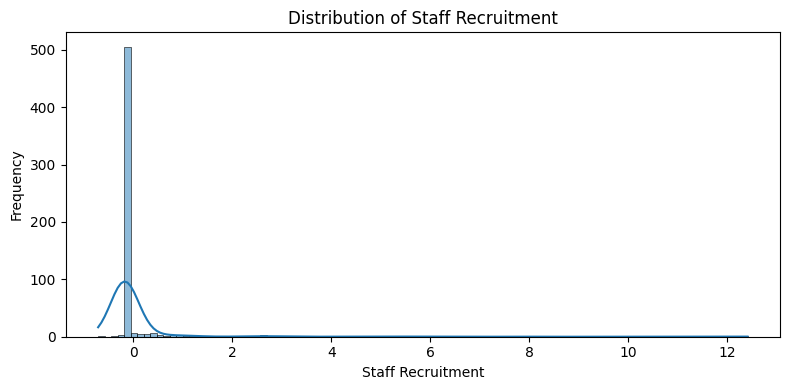

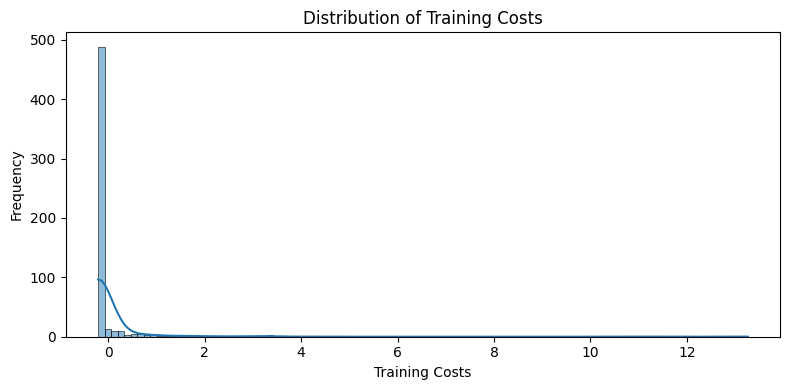

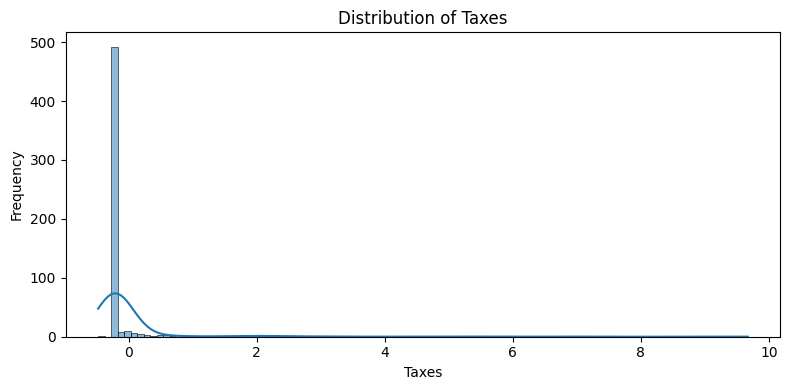

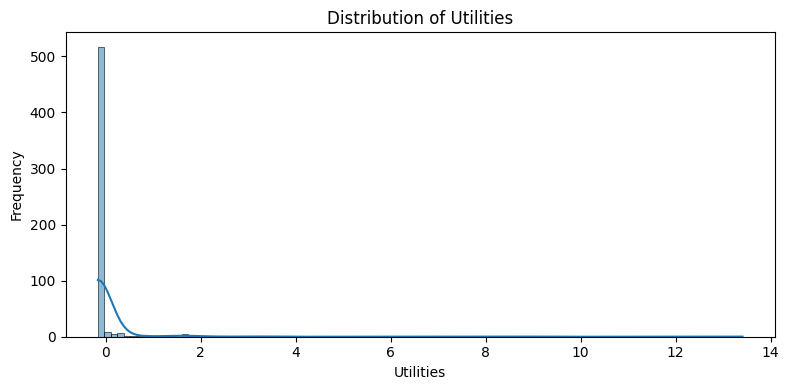

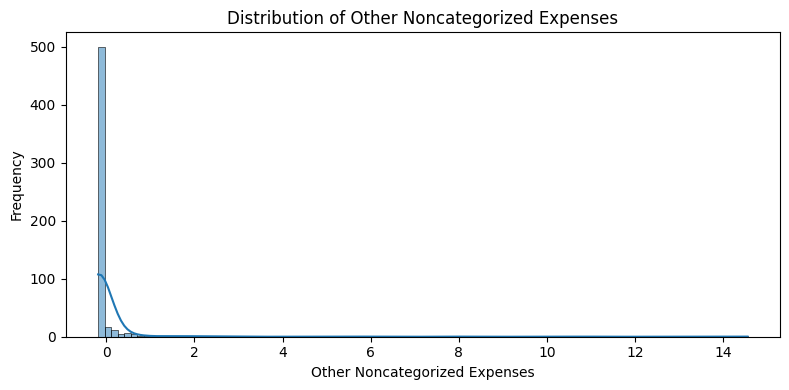

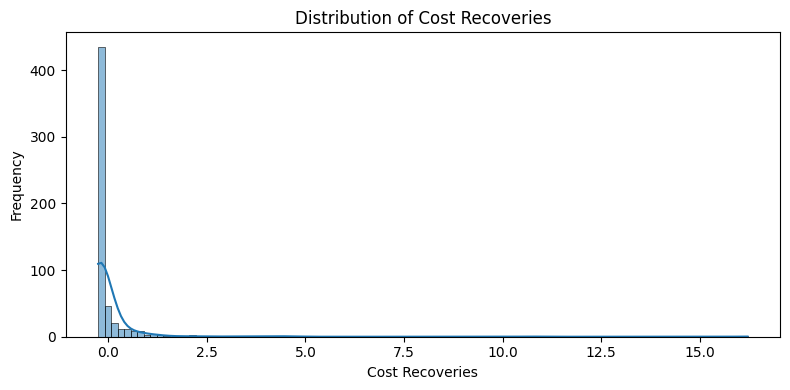

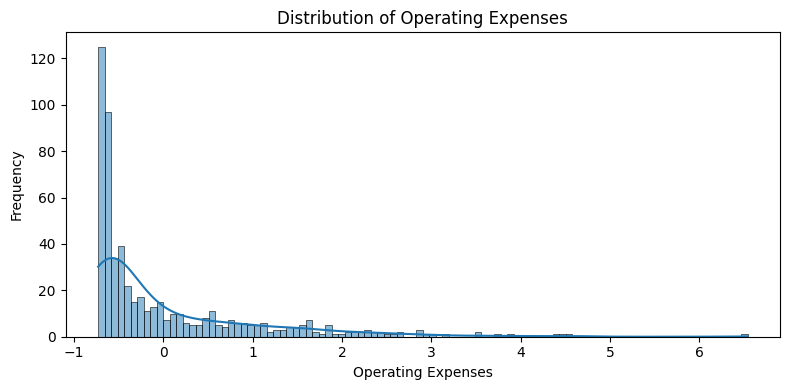

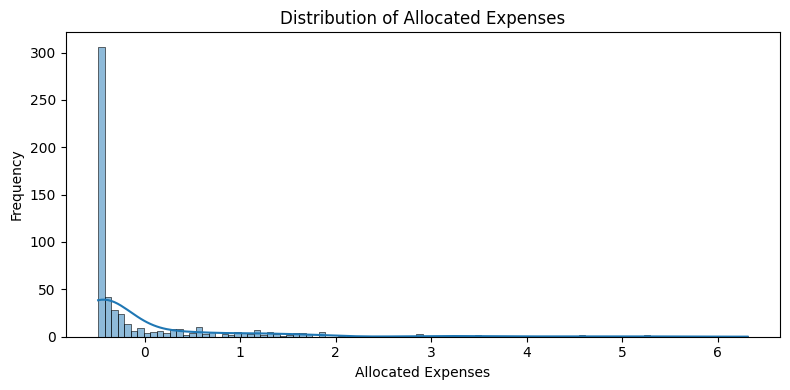

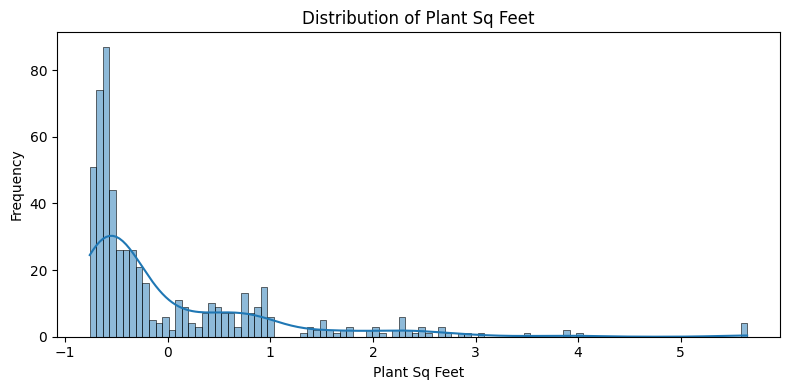

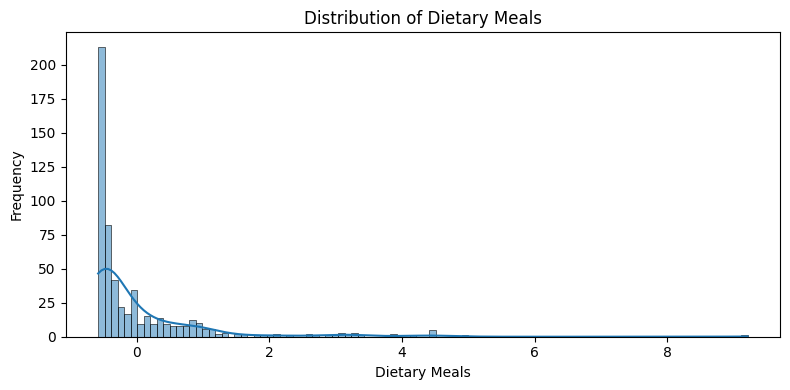

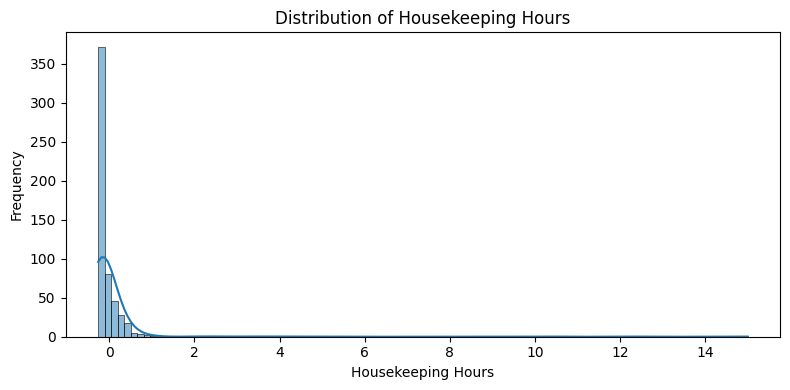

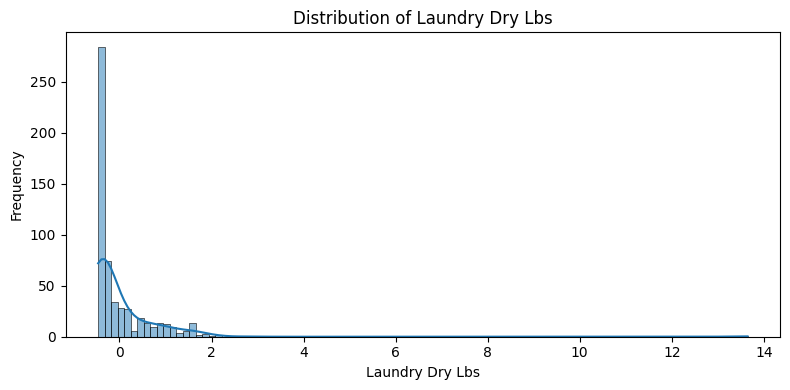

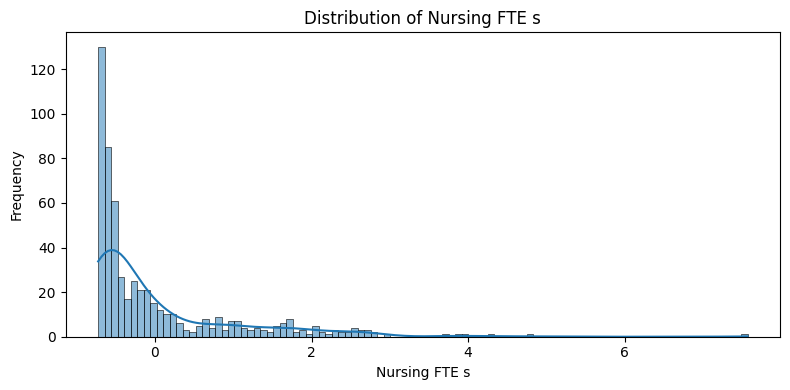

In [ ]:
numeric_cols = [col for col in df_scaled.select_dtypes(include='number').columns if col != 'Year']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_scaled[col], kde=True, bins=100)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# **SVD**

## Theorical Background: Singular Value Decomposition

Singular value decomposition (SVD) converts our initial matrix $X$ into three parts: $$X=U \Sigma V^{T}$$.

$U$ and $V^{T}$ are orthogonal and $\Sigma$ is a diagonal matrix. Both $U$ and $V^{T}$ can be understood as projecting the entries of $X$ into a space where the points in hyperspace can be seperated more easily (i.e. where the variance between each of the points is higher and they are therefore further away from each other).

- In other words, one can think of the decomposed vectors as attempting to seperate the points in space as much as possible.

To distinguish $U$ and $V^{T}$, $U$ gives the matrix that is full of linear combinations of the columns of the rows of the previous matrix, or what will be called "Principal Components". $V^{T}$ gives directional vectors for the vectors in $U$, often called loadings.

$\Sigma$ is a matrix full of scores. These scores correspond to the vectors in $U$ and $V^{T}$ and determine how much of the variance is explained by the vectors that make up these matrices. However, all that needs to be known now is that SVD is especially good at approximating matrices. Therefore, we can use SVD to approximate missing entries in a matrix as well. As will be mantioned later, SVD and Principal Component Analysis (PCA) are especially similar, with SVD differing only be requiring a scaled matrix.

## Using Matrix Completion to replace missing values.

It would be wasteful to let these two mis-entries be NA values. Matrix completion can be done to inpute more realistic values instead of the unrealistic ones noted above.

We use SVD to produce a matrix approximation of our initial matrix.

These will be used to approximate a completed matrix that we will use to fill in NA values in our matrix.

In [ ]:
#This function performs singular vaue decomposition
def fit_svd(X, M=1):
    U, s, V = np.linalg.svd(X,full_matrices=False)
    return U[:, :M] @ (np.diag(s[:M]) @ V[:M, :])

In [ ]:
#Since we are going to scale our data, we first get rid of irrelevant data, categorical data, or data that should not be scaled.
df_cols=df[["Year", "License Number", "Hospital Name", "Acct #", "Cost Center"]]

Our goal with matrix completion is to fill in the two NA values we removed earlier, namely the Rainier Springs hospital and the Cascade Valley Hospital.

In [ ]:
Xna=df.drop(columns=["Year", "License Number", "Hospital Name", "Acct #", "Cost Center"])
#SVD is more effective with scaled data, so we scale our data and plan to un-scale it later.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xna)

Xna=X_scaled
#We create a copy of our matrix and we inpute the xhat (our mean matrix) with the mean value of the matrix.
Xhat = X_scaled.copy()
xbar = np.nanmean(Xna, axis=0)

#These parameters are for the updating loop below.
thresh = 1e-7
rel_err = 1
iter_ = 0

#This line checks for the two missing entries.
ismiss = np.isnan(Xna)
#We scale the data again to compute errors between the matrices.
Xscaled = (Xna - xbar) / np.sqrt(np.sum(~ismiss, axis=0))
Xscaled_nomiss = Xscaled[~ismiss]
#We keep track of the error between the two matrices.
mssold = np.mean(np.square(Xscaled_nomiss))
#We compute the new error.
mss0 = np.mean(np.square(Xna[~ismiss]))

#We inputate the missing values into our matrix.
col_means = np.nanmean(Xhat, axis=0)
inds = np.where(np.isnan(Xhat))
Xhat[inds] = np.take(col_means, inds[1])

#This converts the following into numpy arrays for ease of computation.
Xhat=np.array(Xhat)
xbar=np.array(xbar)
ismiss=np.array(ismiss)
Xna=np.array(Xna)

#This loop lets us create a matrix to approximate our matrix. When the error between the non-NA values gets low enough, we can use the SVD approximated NA values.
while np.abs(rel_err) > thresh:
    iter_ += 1
    Xapp = fit_svd(Xhat, M=1)
    Xhat[ismiss] = Xapp[ismiss]
    mss = np.mean(np.square(Xna[~ismiss] - Xapp[~ismiss]))
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print(f"Iter: {iter_}, MSS: {mss}, Rel. Err: {rel_err}")
#We unscale our data.
Xapp = scaler.inverse_transform(Xhat)

Iter: 1, MSS: 0.8000888768656323, Rel. Err: -0.8000656943423403
Iter: 2, MSS: 0.8000888575989581, Rel. Err: 1.9266674256002144e-08


We now add back the columns we got rid of.

In [ ]:
df1 = pd.concat([
    pd.DataFrame(df_cols.reset_index(drop=True)),
    pd.DataFrame(Xapp, columns=[x for x in list(df.columns) if x not in ["Year", "License Number", "Hospital Name", "Acct #", "Cost Center"]]).reset_index(drop=True)
], axis=1)

We can check our newly completed values. These are much more reasonable, though a bit small.

In [ ]:
df1.loc[
    (df1['Year'] == 2021) &
    (df1['License Number'] == 106) &
    (df1['Hospital Name'].str.strip() == 'CASCADE VALLEY HOSPITAL') &
    (df1['Cost Center'].str.strip() == 'Laboratory (Including Blood Bank)') ,
    'ID FTE s'
]

14604    11.041729
Name: ID FTE s, dtype: float64

In [ ]:
df1.loc[
    (df1['Year'] == 2023) &
    (df1['License Number'] == 925) &
    (df1['Hospital Name'].str.strip() == 'Rainier Springs') &
    (df1['Cost Center'].str.strip() == 'Psychiatric Care'),
    'Nursing FTE s'
]

42193    20.116339
Name: Nursing FTE s, dtype: float64

Now, what we want to do is to ensure our newly completed matrix matches the former matrix, we convert values back. To avoid rounding errors, we round for integers and we round to two decimal points for floats in the original matrix.

In [ ]:
for col in df1.columns:
    if col in df.columns:
      if df1[col].dtype=="float64":
        if df[col].dtype=="int64":
          df1[col] = df1[col].round().astype(df[col].dtype)
        if df[col].dtype=="float64":
          df1[col] = df1[col].round(2).astype(df[col].dtype)
        else:
          df1[col] = df1[col].astype(df[col].dtype)
      else:
        df1[col] = df1[col].astype(df[col].dtype)

We then revert our index to be the same as the previous matrix.

In [ ]:
df1.index=df.index
#This code confirms that the two matrices are the same, save the two NA values.
 (df1!=df).sum().sum()

np.int64(2)

These are the two outliers. We have successfully used matrix completion to handle our outliers.

In [ ]:
df=df1.copy()

We can now proceed with our aggregated matrices. As mentioned before, we remove units of measure because they are not relevant.

In [ ]:
meta_cols = ['Hospital Name', 'Year', 'License Number', 'Acct #', 'Cost Center', 'Units of Measure']
df_numeric = df.drop(columns=meta_cols).apply(pd.to_numeric, errors='coerce')
df_agg = pd.concat([df[['Hospital Name', 'Year']], df_numeric], axis=1)
df_agg = df_agg.groupby(['Hospital Name', 'Year']).sum(numeric_only=True).reset_index()

df_meta = df[meta_cols].reset_index(drop=True)
numeric_cols = [col for col in df_agg.columns if col not in ['Hospital Name', 'Year']]

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_agg[numeric_cols]), columns=numeric_cols)

## Determining collinearity between negative columns.

We will save df_scaled for clustering. For the moment, we should investigate negative values in the non-aggregated matrix.

One might suspect that the negative values in the matrix were entered by mistake. To check if this is the case, let's do matrix completion on an entirely positive matrix. If the magnitudes of the matrices are similar, then it could be a mis-entry error.

In [ ]:
df_names=df[["License Number", "Hospital Name","Acct #", "Cost Center"]]
df1=df.drop(columns=["License Number", "Hospital Name","Acct #", "Cost Center"])
df1=df.drop(columns=["License Number", "Hospital Name","Acct #", "Cost Center"])

Let's perform SVD pre-aggregation to determine if we can predict the magnitudes of all negative numbers in the dataframe.

In [ ]:
df_negative=df1
zeros=(df_negative<0).sum()
zeros.sum()

np.int64(3054)

In [ ]:
df_negative.shape

(43136, 36)

We have 3054 zero entries.

In [ ]:
(df_negative < 0).any(axis=1).sum()

np.int64(2251)

Although there are 3054 zero entries, only about 2251 rows have them. This means around 5 percent of our data points have a zero value.

Let's convert all the negatives to NA and check for any correlation.

In [ ]:
df_negative_na=df_negative.mask(df_negative<0, np.nan).copy()
df_negative_na.isna().sum()

Year                                                           0
ID FTE s                                                      22
Units of Measure                                               2
Salaries Wages                                                67
Employee Benefits                                             89
Professional Fees                                            162
Supplies                                                     471
Purch Serv Utilities                                          68
Purch Serv Other                                             298
Rentals Leases                                               231
Depreciation Expense                                          30
Other Direct Exp                                             394
Total Revenue                                                 90
Inpatient Revenue                                            118
Blood Supplies                                                 4
Contract Staffing                                             78
Information Technology Including Licenses and Maintenance     17
Insurance and Professional Liability                           6
Laundry Services                                               7
Legal Audit and Tax services                                   4
Purchased Laboratory Services                                  4
Repairs and Maintenance                                       36
Shared Services or System Office Allocation                   12
Staff Recruitment                                             17
Training Costs                                                16
Taxes                                                         15
Utilities                                                      4
Other Noncategorized Expenses                                211
Cost Recoveries                                              199
Operating Expenses                                           335
Allocated Expenses                                            41
Plant Sq Feet                                                  0
Dietary Meals                                                  0
Housekeeping Hours                                             0
Laundry Dry Lbs                                                0
Nursing FTE s                                                  6
dtype: int64

Let's consider the implications of some negative entries. In almost all of the columns with negative values, it seems realistic that, for example, repairs and maintenance could have a negative value. For example, perhaps the hospital department received a reimbursement from another department, they had credit from a previous year, or they were refunded for their services.

The only entry that does not seem to make much sense is units of measure. However, that column will already be removed.

We now perform matrix completion on a fully positive matrix to see what results we receive.

In [ ]:
Xna=df_negative_na


scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xna)

Xna=X_scaled

Xhat = X_scaled.copy()
xbar = np.nanmean(Xna, axis=0)

thresh = 1e-7
rel_err = 1
iter_ = 0

ismiss = np.isnan(Xna)
Xscaled = (Xna - xbar) / np.sqrt(np.sum(~ismiss, axis=0))
Xscaled_nomiss = Xscaled[~ismiss]
mssold = np.mean(np.square(Xscaled_nomiss))
mss0 = np.mean(np.square(Xna[~ismiss]))


col_means = np.nanmean(Xhat, axis=0)
inds = np.where(np.isnan(Xhat))
Xhat[inds] = np.take(col_means, inds[1])
Xhat=np.array(Xhat)
xbar=np.array(xbar)
ismiss=np.array(ismiss)
Xna=np.array(Xna)


while np.abs(rel_err) > thresh:
    iter_ += 1
    Xapp = fit_svd(Xhat, M=1)
    Xhat[ismiss] = Xapp[ismiss]
    mss = np.mean(np.square(Xna[~ismiss] - Xapp[~ismiss]))
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print(f"Iter: {iter_}, MSS: {mss}, Rel. Err: {rel_err}")
Xapp = scaler.inverse_transform(Xhat)

Iter: 1, MSS: 0.7972975988639411, Rel. Err: -0.797274370689714
Iter: 2, MSS: 0.7971198874590188, Rel. Err: 0.00017771140492228713
Iter: 3, MSS: 0.7971149361662702, Rel. Err: 4.951292748689437e-06
Iter: 4, MSS: 0.7971147559715089, Rel. Err: 1.8019476122343995e-07
Iter: 5, MSS: 0.7971147476865215, Rel. Err: 8.284987473849977e-09


In [ ]:
np.corrcoef(Xapp[ismiss], np.array(df_negative)[ismiss])[0, 1]

np.float64(-0.7745485693698936)

In [ ]:
np.corrcoef(Xapp[ismiss], np.array(df_negative.abs())[ismiss])[0, 1]

np.float64(0.7745485693698936)

It seems that there is a low level of correlation here. We can clearly see there is no such correlation in the scatterplot below.

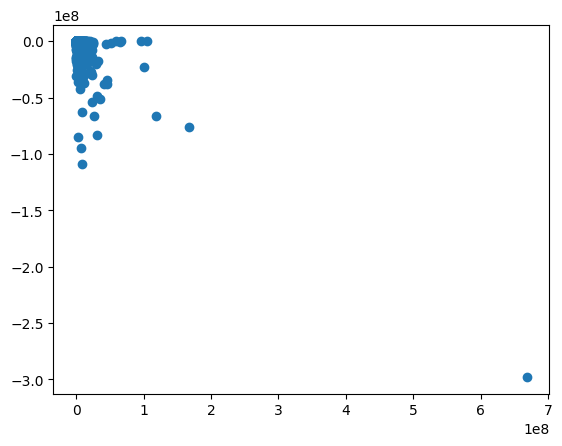

In [ ]:
plt.scatter(Xapp[ismiss], np.array(df_negative)[ismiss])

<ipython-input-555-cc8d08326516>:1: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(Xapp[ismiss]), np.log(np.array(df_negative.abs())[ismiss]))


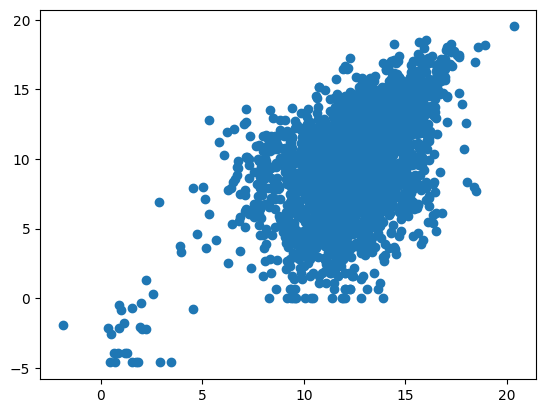

In [ ]:
plt.scatter(np.log(Xapp[ismiss]), np.log(np.array(df_negative.abs())[ismiss]))

After taking the log of both, it has a slightly linear shape, but it is still not very good. This is also biased by the fact that both are positive values. In other words, because

In [ ]:
negative_counts = (df_negative < 0).sum(axis=1)

max_negatives = negative_counts.max()

In [ ]:
max_negatives

6

In [ ]:
rows_with_most_negatives = df[negative_counts == max_negatives]

In [ ]:
rows_with_most_negatives

Year  License Number                                     Hospital Name  \
25     2019               1  Swedish Health Services DBA Swedish Medical Cent   
26148  2019             159                     Providence St. Peter Hospital   
30512  2020             176                        Tacoma General / Allenmore   
32441  2021             193                             MOUNT CARMEL HOSPITAL   
34307  2022             198                         Astria Sunnyside Hospital   

       Acct #       Cost Center  ID FTE s  Units of Measure  Salaries Wages  \
25       6120    Physical Rehab      0.00                -1             956   
26148    8330         Cafeteria     -0.50                 0          -71633   
30512    7350  Observation Unit     -0.08                 0           -3344   
32441    7050  Central Services     -0.01                 0           -1324   
34307    8420        Purchasing      3.03                 0          232209   

       Employee Benefits  Professional Fees  ...  Utilities  \
25                   144                793  ...          0   
26148              -7071                  0  ...          0   
30512              -9128                  0  ...          0   
32441               -117                  0  ...          0   
34307              58280                  0  ...          0   

       Other Noncategorized Expenses  Cost Recoveries  Operating Expenses  \
25                                 0                0              -10716   
26148                              0          1802066            -1975864   
30512                              0                0              -12526   
32441                              0                0              -26024   
34307                        -276392                0             -308347   

       Allocated Expenses  Plant Sq Feet  Dietary Meals  Housekeeping Hours  \
25                  -5490              0              0                   0   
26148                   0           5196              0                   0   
30512               -3596              0              0                   0   
32441              -12137              0              0                   0   
34307                   0              0              0                   0   

       Laundry Dry Lbs  Nursing FTE s  
25                   0            0.0  
26148                0            0.0  
30512                0            0.0  
32441                0            0.0  
34307                0            0.0  

[5 rows x 40 columns]

These all have negative operating expenses, but it appears that there are no clear correlations. For example, let's consider Astria Sunnyside Hospital

In [ ]:
df[(df["Hospital Name"]=="Astria Sunnyside Hospital") & (df["Acct #"]==8420)]

Year  License Number              Hospital Name  Acct # Cost Center  \
34307  2022             198  Astria Sunnyside Hospital    8420  Purchasing   
34308  2019             198  Astria Sunnyside Hospital    8420  Purchasing   
34309  2020             198  Astria Sunnyside Hospital    8420  Purchasing   
34310  2021             198  Astria Sunnyside Hospital    8420  Purchasing   
34311  2023             198  Astria Sunnyside Hospital    8420  Purchasing   

       ID FTE s  Units of Measure  Salaries Wages  Employee Benefits  \
34307      3.03                 0          232209              58280   
34308      4.73                 0          192843              38561   
34309      3.76                 0          146087              29116   
34310      4.63                 0          222930              44248   
34311      4.55                 0          181761              52377   

       Professional Fees  ...  Utilities  Other Noncategorized Expenses  \
34307                  0  ...          0                        -276392   
34308                  0  ...          0                              0   
34309                  0  ...          0                              0   
34310                  0  ...          0                              0   
34311                  0  ...          0                          66882   

       Cost Recoveries  Operating Expenses  Allocated Expenses  Plant Sq Feet  \
34307                0             -308347                   0              0   
34308                0              293390                   0              0   
34309                0             -208396                   0              0   
34310                0              258674                   0              0   
34311                0              309392                   0            846   

       Dietary Meals  Housekeeping Hours  Laundry Dry Lbs  Nursing FTE s  
34307              0                   0                0            0.0  
34308              0                   0                0            0.0  
34309              0                   0                0            0.0  
34310              0                   0                0            0.0  
34311              0                   0                0            0.0  

[5 rows x 40 columns]

Here, Astria Sunnyside hospital is having fluctuating negative costs. This might imply refunds from a previous year or credit or grants given to that department for certain expenses. See, for example, operating expenses, which fluctuate often.

It is incorrect methodology to eliminate ALL negative values, since there might be some genuine ones as in the Astria Sunnyside Hospital above. Let's replace the negative values in a single column and see if they can be predicted with the other negative columns. For example, it could be possible that some negative columns are dependent on each other. Let's convert all the negatives in the Supplies of the dataframe to see if we can replicate the negatives in the column.

In [ ]:
df_negative.isna().sum().sum()

np.int64(0)

In [ ]:
df_negative_sup=df_negative.copy()

In [ ]:
df_negative_sup["Supplies"] = df_negative_sup["Supplies"].mask(df_negative_sup["Supplies"] < 0, np.nan)


In [ ]:
df_negative.isna().sum().sum()

np.int64(0)

In [ ]:
Xna=df_negative_sup


scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xna)

Xna=X_scaled

Xhat = X_scaled.copy()
xbar = np.nanmean(Xna, axis=0)

thresh = 1e-7
rel_err = 1
iter_ = 0

ismiss = np.isnan(Xna)
Xscaled = (Xna - xbar) / np.sqrt(np.sum(~ismiss, axis=0))
Xscaled_nomiss = Xscaled[~ismiss]
mssold = np.mean(np.square(Xscaled_nomiss))
mss0 = np.mean(np.square(Xna[~ismiss]))


col_means = np.nanmean(Xhat, axis=0)
inds = np.where(np.isnan(Xhat))
Xhat[inds] = np.take(col_means, inds[1])
Xhat=np.array(Xhat)
xbar=np.array(xbar)
ismiss=np.array(ismiss)
Xna=np.array(Xna)


while np.abs(rel_err) > thresh:
    iter_ += 1
    Xapp = fit_svd(Xhat, M=1)
    Xhat[ismiss] = Xapp[ismiss]
    mss = np.mean(np.square(Xna[~ismiss] - Xapp[~ismiss]))
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print(f"Iter: {iter_}, MSS: {mss}, Rel. Err: {rel_err}")
Xapp = scaler.inverse_transform(Xhat)

Iter: 1, MSS: 0.8055309227507297, Rel. Err: -0.8055077332246663
Iter: 2, MSS: 0.805529017016396, Rel. Err: 1.9057343336736935e-06
Iter: 3, MSS: 0.8055290140068453, Rel. Err: 3.0095507197458485e-09


In [ ]:
df_negative.isna().sum().sum()

np.int64(0)

In [ ]:
np.corrcoef(Xapp[ismiss], np.array(df_negative)[ismiss])[0, 1]

np.float64(-0.17590699911984553)

In [ ]:
np.corrcoef(Xapp[ismiss], np.array(df_negative.abs())[ismiss])[0, 1]

np.float64(0.17590699911984553)

This is a very low correlation coefficient. This implies that the supplies column is relatively independent of the rest of the columns. Consider the following scatterplot of the data, also indicating the randomness of the supply expenses.

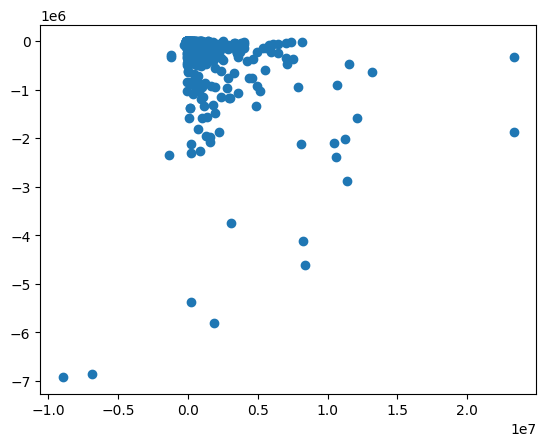

In [ ]:
plt.scatter(Xapp[ismiss], np.array(df_negative)[ismiss])

After taking the log of both, it has a slightly linear shape, but it is still not very good. This is also biased by the fact that both are positive values.

We can investigate the negative values more by checking rows where they appear very frequently.

In [ ]:
negative_counts = (df_negative < 0).sum(axis=1)

max_negatives = negative_counts.max()

In [ ]:
max_negatives

6

In [ ]:
rows_with_most_negatives = df[negative_counts == max_negatives]

In [ ]:
rows_with_most_negatives

Year  License Number                                     Hospital Name  \
25     2019               1  Swedish Health Services DBA Swedish Medical Cent   
26148  2019             159                     Providence St. Peter Hospital   
30512  2020             176                        Tacoma General / Allenmore   
32441  2021             193                             MOUNT CARMEL HOSPITAL   
34307  2022             198                         Astria Sunnyside Hospital   

       Acct #       Cost Center  ID FTE s  Units of Measure  Salaries Wages  \
25       6120    Physical Rehab      0.00                -1             956   
26148    8330         Cafeteria     -0.50                 0          -71633   
30512    7350  Observation Unit     -0.08                 0           -3344   
32441    7050  Central Services     -0.01                 0           -1324   
34307    8420        Purchasing      3.03                 0          232209   

       Employee Benefits  Professional Fees  ...  Utilities  \
25                   144                793  ...          0   
26148              -7071                  0  ...          0   
30512              -9128                  0  ...          0   
32441               -117                  0  ...          0   
34307              58280                  0  ...          0   

       Other Noncategorized Expenses  Cost Recoveries  Operating Expenses  \
25                                 0                0              -10716   
26148                              0          1802066            -1975864   
30512                              0                0              -12526   
32441                              0                0              -26024   
34307                        -276392                0             -308347   

       Allocated Expenses  Plant Sq Feet  Dietary Meals  Housekeeping Hours  \
25                  -5490              0              0                   0   
26148                   0           5196              0                   0   
30512               -3596              0              0                   0   
32441              -12137              0              0                   0   
34307                   0              0              0                   0   

       Laundry Dry Lbs  Nursing FTE s  
25                   0            0.0  
26148                0            0.0  
30512                0            0.0  
32441                0            0.0  
34307                0            0.0  

[5 rows x 40 columns]

These all have negative operating expenses, but it appears that there are no clear correlations. We will check other records from that hospital to investigate the negative entries. For example, let's consider Astria Sunnyside Hospital. We see that many of the rows with negatives also have positive values.

In [ ]:
df[(df["Hospital Name"]=="Astria Sunnyside Hospital") & (df["Acct #"]==8420)]

Year  License Number              Hospital Name  Acct # Cost Center  \
34307  2022             198  Astria Sunnyside Hospital    8420  Purchasing   
34308  2019             198  Astria Sunnyside Hospital    8420  Purchasing   
34309  2020             198  Astria Sunnyside Hospital    8420  Purchasing   
34310  2021             198  Astria Sunnyside Hospital    8420  Purchasing   
34311  2023             198  Astria Sunnyside Hospital    8420  Purchasing   

       ID FTE s  Units of Measure  Salaries Wages  Employee Benefits  \
34307      3.03                 0          232209              58280   
34308      4.73                 0          192843              38561   
34309      3.76                 0          146087              29116   
34310      4.63                 0          222930              44248   
34311      4.55                 0          181761              52377   

       Professional Fees  ...  Utilities  Other Noncategorized Expenses  \
34307                  0  ...          0                        -276392   
34308                  0  ...          0                              0   
34309                  0  ...          0                              0   
34310                  0  ...          0                              0   
34311                  0  ...          0                          66882   

       Cost Recoveries  Operating Expenses  Allocated Expenses  Plant Sq Feet  \
34307                0             -308347                   0              0   
34308                0              293390                   0              0   
34309                0             -208396                   0              0   
34310                0              258674                   0              0   
34311                0              309392                   0            846   

       Dietary Meals  Housekeeping Hours  Laundry Dry Lbs  Nursing FTE s  
34307              0                   0                0            0.0  
34308              0                   0                0            0.0  
34309              0                   0                0            0.0  
34310              0                   0                0            0.0  
34311              0                   0                0            0.0  

[5 rows x 40 columns]

Here, Astria Sunnyside hospital is having fluctuating negative costs. This might imply refunds from a previous year or credit or grants given to that department for certain expenses. See, for example, operating expenses, which fluctuate often. The fact that the negatives fluctuate from year to year suggests that this entry is not some systematic error.

It is incorrect methodology to eliminate ALL negative values, since there might be some genuine ones as in the Astria Sunnyside Hospital above. Let's replace the negative values in a single column and see if they can be predicted with the other negative columns. For example, it could be possible that some negative columns are dependent on each other. Let's convert all the negatives in the Supplies of the dataframe to see if we can replicate the negatives in the column.

In [ ]:
df_negative.isna().sum().sum()

np.int64(0)

In [ ]:
df_negative_sup=df_negative.copy()

In [ ]:
df_negative_sup["Supplies"] = df_negative_sup["Supplies"].mask(df_negative_sup["Supplies"] < 0, np.nan)


In [ ]:
df_negative.isna().sum().sum()

np.int64(0)

In [ ]:
Xna=df_negative_sup


scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xna)

Xna=X_scaled

Xhat = X_scaled.copy()
xbar = np.nanmean(Xna, axis=0)

thresh = 1e-7
rel_err = 1
iter_ = 0

ismiss = np.isnan(Xna)
Xscaled = (Xna - xbar) / np.sqrt(np.sum(~ismiss, axis=0))
Xscaled_nomiss = Xscaled[~ismiss]
mssold = np.mean(np.square(Xscaled_nomiss))
mss0 = np.mean(np.square(Xna[~ismiss]))


col_means = np.nanmean(Xhat, axis=0)
inds = np.where(np.isnan(Xhat))
Xhat[inds] = np.take(col_means, inds[1])
Xhat=np.array(Xhat)
xbar=np.array(xbar)
ismiss=np.array(ismiss)
Xna=np.array(Xna)


while np.abs(rel_err) > thresh:
    iter_ += 1
    Xapp = fit_svd(Xhat, M=1)
    Xhat[ismiss] = Xapp[ismiss]
    mss = np.mean(np.square(Xna[~ismiss] - Xapp[~ismiss]))
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print(f"Iter: {iter_}, MSS: {mss}, Rel. Err: {rel_err}")
Xapp = scaler.inverse_transform(Xhat)

Iter: 1, MSS: 0.8055309227507297, Rel. Err: -0.8055077332246663
Iter: 2, MSS: 0.805529017016396, Rel. Err: 1.9057343336736935e-06
Iter: 3, MSS: 0.8055290140068453, Rel. Err: 3.0095507197458485e-09


In [ ]:
df_negative.isna().sum().sum()

np.int64(0)

In [ ]:
np.corrcoef(Xapp[ismiss], np.array(df_negative)[ismiss])[0, 1]

np.float64(-0.17590699911984553)

In [ ]:
np.corrcoef(Xapp[ismiss], np.array(df_negative.abs())[ismiss])[0, 1]

np.float64(0.17590699911984553)

This is a very low correlation coefficient. This implies that the supplies column is relatively independent of the rest of the columns. Consider the following scatterplot of the data, also indicating the randomness of the supply expenses.

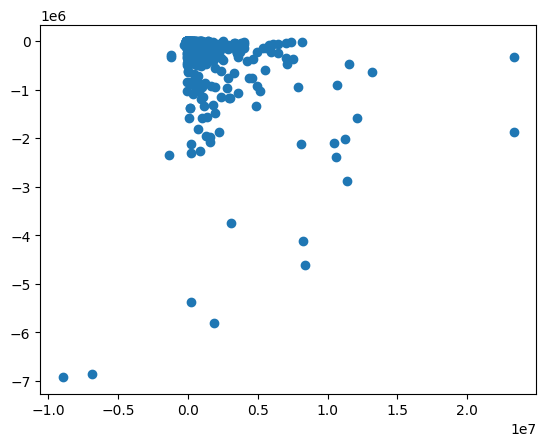

In [ ]:
plt.scatter(Xapp[ismiss], np.array(df_negative)[ismiss])

## Matrix completion conclusions

We have been able to perform some data cleaning and have come across some reasonable conclusions.

- Matrix completion can be used to replace outliers in the data (of which there were clearly 2)
- Negatives likely are not mistaken entries.

### Matrix Completion on Random Entries

One important caveat to keep in mind with matrix completion is that it should only be done to replace randomly missing data. We did not replace the negative data above because it is structurally significant to the data. Additionally, if data are being systematically removed from a dataframe, such as all of the negative values being removed, then matrix completion completly ignores such structure. Therefore, care should be taken to avoid using matrix completion unless the data in the matrix are randomly missing or entered by error. As we have good reason to think the negative entries in the matrix are not random, we will not remove them.

#  **Principal Component Analysis**

###Theoretical Background:
Principal Component Analysis (PCA) allows us to "reframe" the way the points are plotted in space. Suppose, for example, one wanted to draw horizontal boundaries on a dataset (i.e. vertical lines) but the data was packed together on a tiny horizontal interval and spread only vertically. Such a horizontal boundary would not be helpful. However, by simply rotating the plot 90 degrees. PCA performs a similar type of transformation on the data to spread it out and make boundaries more clear.

Technically, PCA produces several principal components $z_i$ where each of the principal components are a linear combination of the features of the previous space such that $z_i=\phi_{i1} X_{i1}+...+\phi_{in} X_{in}$. Let $X_i$ be a feature and let $\phi_i$ be the weight that feature has on the princpal component. These principle components, all orthogonal to each other, help serve as axes for a new principle component space. The points are then projected into this principal component space, being more delineated and spread out.

PCA has a few primary functions:
- Lowering dimensionality of data

PCA can lower the complexity of the data simply by using less principal components.
- Matrix completion

As mentioned above, PCA, or namely SVD, can be used to approximate a matrix.

- Classification

By projecting our data into principal component space, boundaries can be more easily drawn in the data.

# **Hierarchical Clustering**






## Theoretical Background:

Hierarchical clustering is similar to K-means without commiting to a particular choice of K. An added advantage of hierarchical clustering is that it generated a tree-based representation of the observations, a dendrogram.


**Dendrogram Interpretation**

Each leaf of a dendrogram represents an observation, as we move up the three we see leaves fuse into branches, with each fusion representing observations that are similar to each other. The earlier the fusion occurs the more similar the observations are, while the height of the fusion indicates how different the observations are.

**Hierarchical Clustering Algorithms**

Hierarchical clustering uses a simple algorithm using the dissimilarity measured by each pair of observations, defined as linkage. The four most common types of linkage are: average, complete, single and ward linkages.

  - Complete: Maximal intercluster dissimilarity.
  - Single: Minimal intercluster dissimilarity.
  - Average: Mean intercluster dissimilarity.
  - Ward: Minimize the sum of squared differences.

**Choosing Linkage Method**

The choise of linkage method is important as it has a strong effect on the resulting dendrogram. We should consider the type of data being clustered to make a method selection.

When evaluating linkage methods, consider the following:

1. Dendrogram Structure
  - A good dendrogram shows clear, distinct merges with longer vertical branches separating clusters.

2. Cluster Separation in PCA Space
  - Visualizing clusters in reduced PCA space helps assess how well-separated the clusters are.

3. Feature Importance by Cluster
 - After assigning cluster labels, compare features across clusters.

4. Silhouette Scores
  - Use silhouette scores to compare linkage methods quantitatively.




#### Helper Functions

In [ ]:
from ISLP.cluster import compute_linkage

# Dendrogram plot with linkage method
def plot_nci(linkage_method, dataF, ax, cut=-np.inf, labels=None):
    hc = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=0,
        linkage=linkage_method.lower()
    ).fit(dataF)

    linkage_ = compute_linkage(hc)
    dendrogram(
        linkage_,
        ax=ax,
        labels=labels.to_list() if labels is not None else None,
        leaf_font_size=10,
        color_threshold=cut,
        above_threshold_color='black'
    )
    ax.set_title(f"{linkage_method.capitalize()} Linkage")
    return hc

# Silhouette score curve for multiple linkage types
def sil_scores(linkage_methods, dataF, n_clusters=range(2, 40)):
    scores = []
    for linkage in linkage_methods:
        print(f"\nLinkage: {linkage}")
        for k in n_clusters:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
                lbls = model.fit_predict(dataF)
                score = silhouette_score(dataF, lbls)
                scores.append({'Linkage': linkage, 'Clusters': k, 'Silhouette Score': score})
            except Exception as e:
                print(f"Clusters: {k}, Error: {e}")
    return pd.DataFrame(scores)

# PCA visualization of k clusters for one linkage
def k_clusters(dataF, df_meta, linkage='complete', k_range=range(2, 11)):
    for k in k_range:
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        df_meta = df_meta.copy()
        df_meta['Cluster'] = model.fit_predict(dataF)

        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(dataF)
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca = pd.concat([df_pca, df_meta.reset_index(drop=True)], axis=1)

        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
        plt.title(f'PCA Projection - {linkage.capitalize()} Linkage (k={k})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Dendrogram with colored clusters and return assignments
def colored_dendrogram(data, linkage_type='ward', n_clusters=4, labels=None, figsize=(12, 8)):
    hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage_type).fit(data)
    linkage_matrix = compute_linkage(hc)
    cluster_assignments = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    cut_height = linkage_matrix[-(n_clusters - 1), 2]

    fig, ax = plt.subplots(figsize=figsize)
    dendrogram(
        linkage_matrix,
        ax=ax,
        color_threshold=cut_height,
        above_threshold_color='black',
        labels=labels,
        leaf_font_size=8
    )
    plt.axhline(y=cut_height, c='red', ls='--')
    ax.set_title(f"Dendrogram Colored by {n_clusters} {linkage_type.capitalize()} Clusters")
    plt.tight_layout()
    plt.show()

    return cluster_assignments

# Heatmap of top variable features across clusters
def features_by_cluster(df_scaled, df_meta, linkage_type='ward', k=4, top_n=20):
    hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage_type).fit(df_scaled)
    linkage_matrix = compute_linkage(hc)
    cluster_labels = fcluster(linkage_matrix, t=k, criterion='maxclust')

    df_meta = df_meta.copy()
    df_meta['Cluster'] = cluster_labels
    df_clustered = pd.concat([df_scaled.reset_index(drop=True), df_meta[['Cluster']]], axis=1)

    cluster_means = df_clustered.groupby('Cluster').mean().T
    feature_variability = cluster_means.max(axis=1) - cluster_means.min(axis=1)
    top_features = feature_variability.sort_values(ascending=False).head(top_n).index

    plt.figure(figsize=(10, 12))
    sns.heatmap(cluster_means.loc[top_features], annot=True, cmap="Reds", center=0)
    plt.title(f"Top {top_n} Features Differentiating {linkage_type.capitalize()} Clusters (k={k})")
    plt.tight_layout()
    plt.show()

    return df_meta


#### Dendrograms for Different Linkage Methods

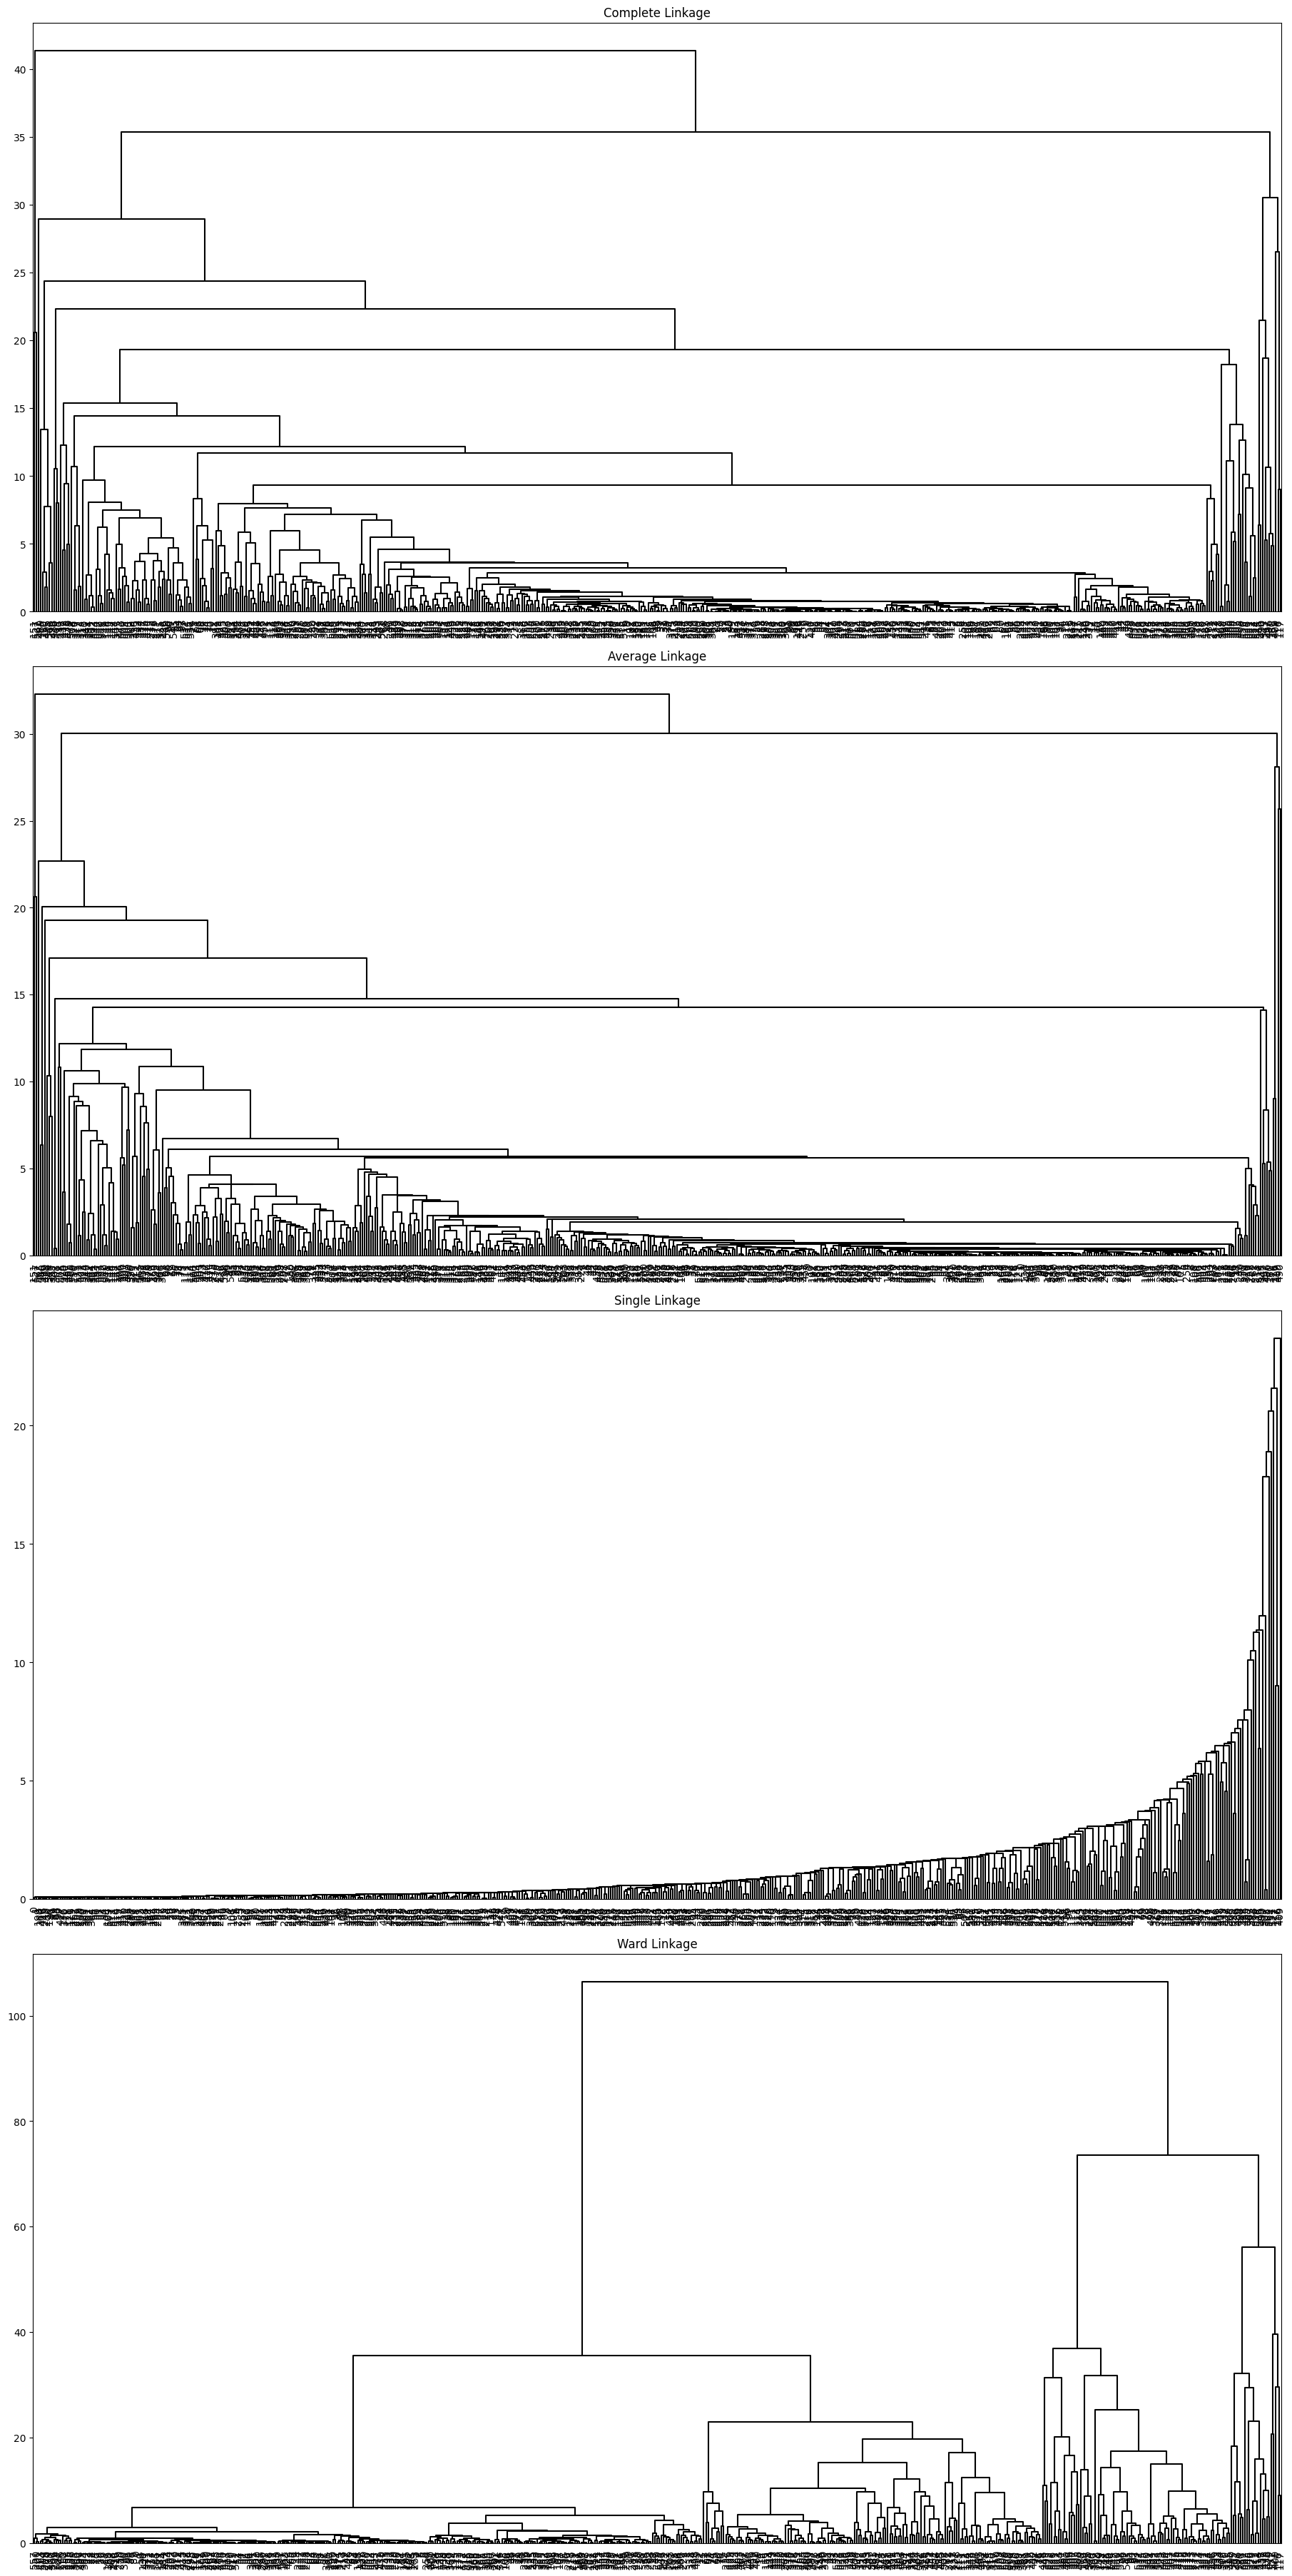

In [ ]:
# Labels for dendrograms
labels = (df_agg['Hospital Name'] + " - " + df_agg['Year'].astype(str)).reset_index(drop=True)

fig, axes = plt.subplots(4, 1, figsize=(18, 36), constrained_layout=True)
plot_nci('complete', df_scaled, axes[0])
plot_nci('average', df_scaled, axes[1])
plot_nci('single', df_scaled, axes[2])
plot_nci('ward', df_scaled, axes[3])
plt.show()

**Interpretation of Dendrograms**

1. Complete Linkage
  - Many small clusters observed.
  - Some good seperation for low number of clusters k=2-3
  - Unbalanced clusters
2. Average Linkage
  - Many smaller clusters observed
  - Seperation betwen clusters decreased compared to complete
  - Unbalanced clusters
3. Single Linkage
  - Excesive number of small clusters ("chaining") effect
  - No clear cluster seperation
  - Unbalanced clusters in low k values
4. Ward Linkage
  - Good cluster structure
  - Great cluster seperation for k= 3-5
  - Easy for interpretation

#### Silhouette Scores by Linkage Method


Linkage: ward

Linkage: complete

Linkage: average

Linkage: single


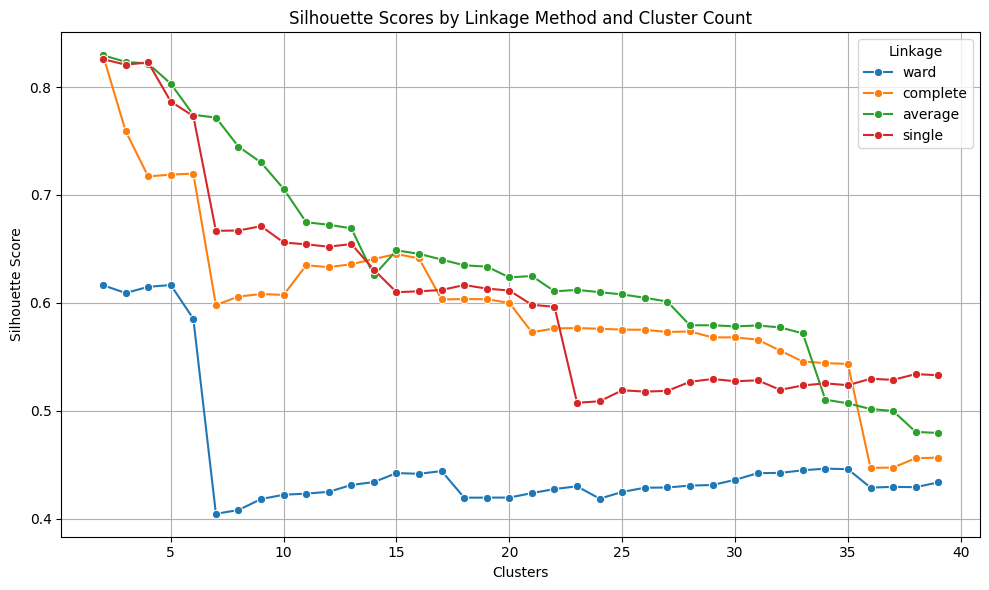

In [ ]:
# List of Linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']

first_analysis = sil_scores(linkage_methods, df_scaled, n_clusters=range(2, 40))
plt.figure(figsize=(10, 6))
sns.lineplot(data=first_analysis, x='Clusters', y='Silhouette Score', hue='Linkage', marker='o')
plt.title("Silhouette Scores by Linkage Method and Cluster Count")
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation of Silhouette Scores**

1. Scores
  - Best scores for each linkage method observed when k=2-5.
  - Drop in score observed after k=6
  - **Based on silhouette scores alone, Average and Complete linkage are good candidates. However, we observed poor cluster definitions with these methods.**

**Next Steps**: Evaluate clusters in PCA space

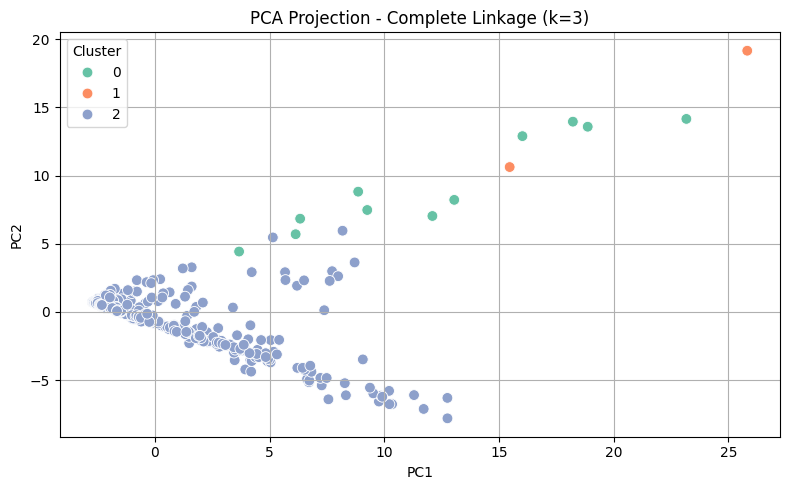

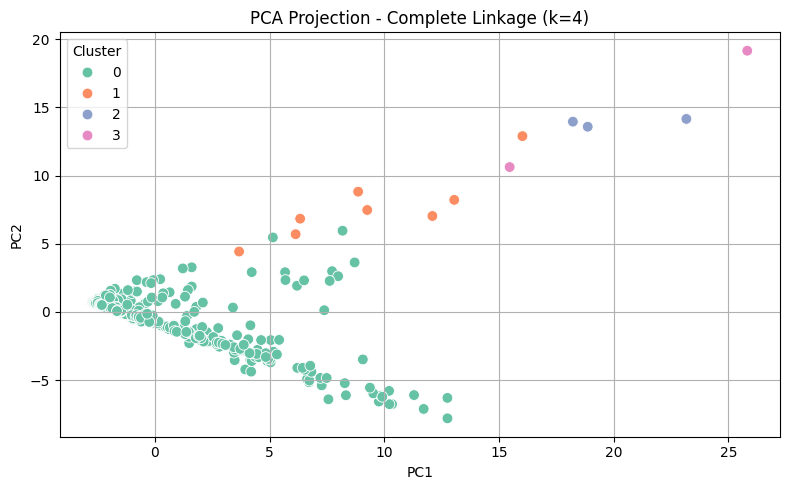

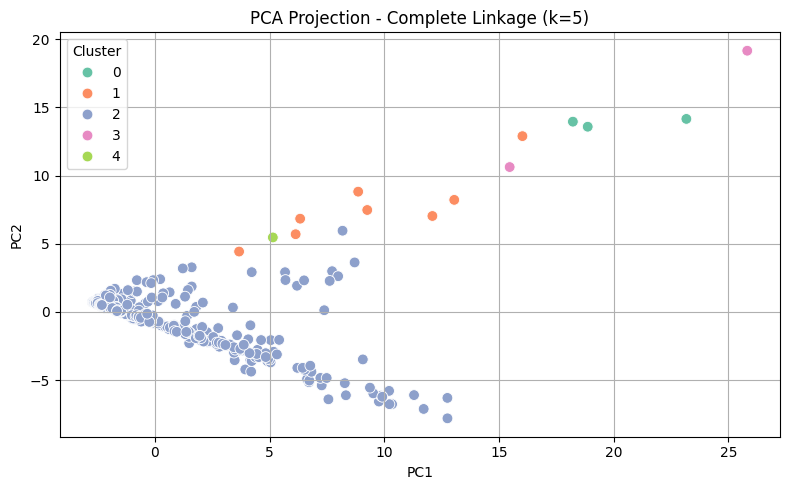

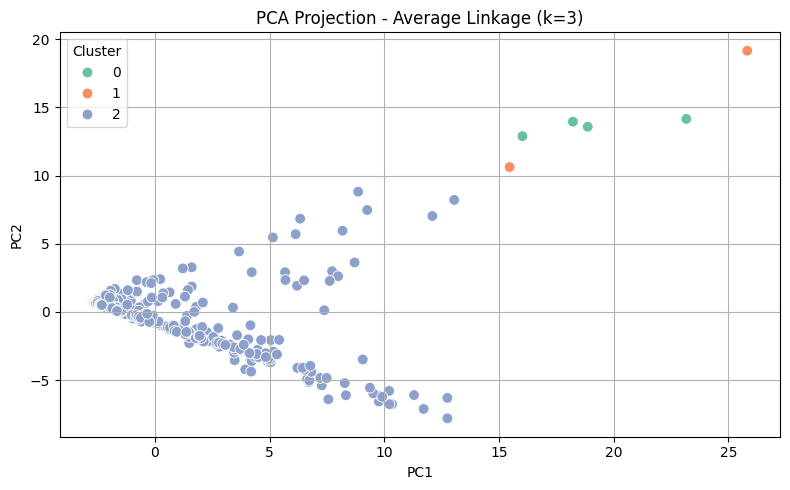

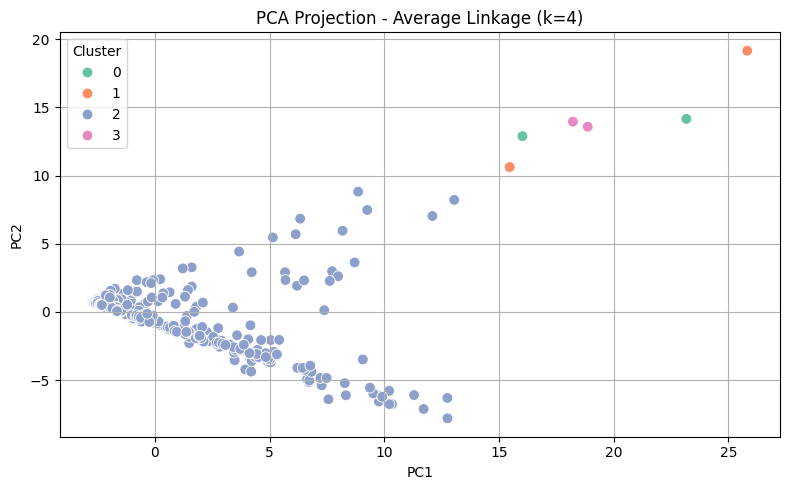

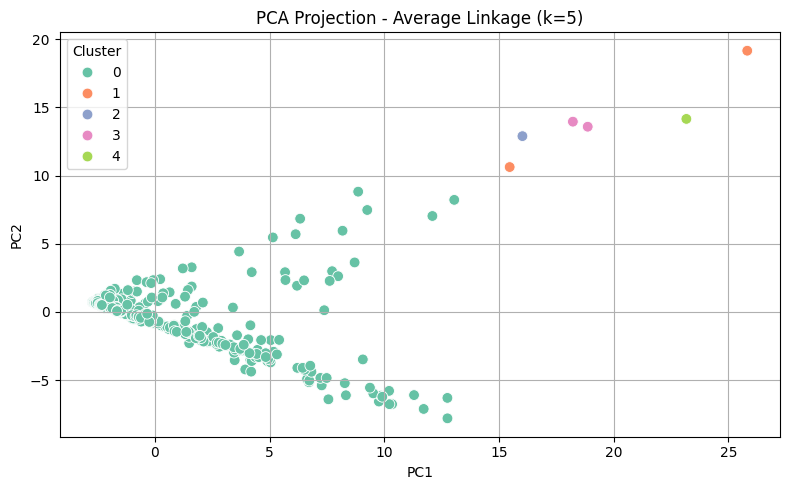

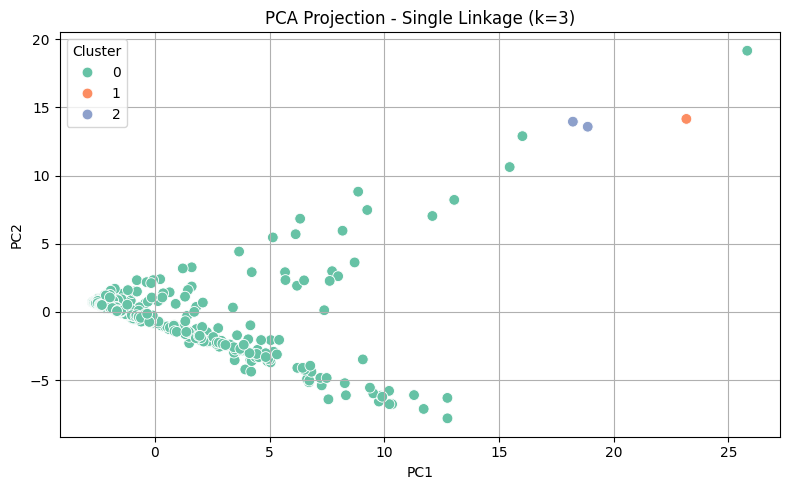

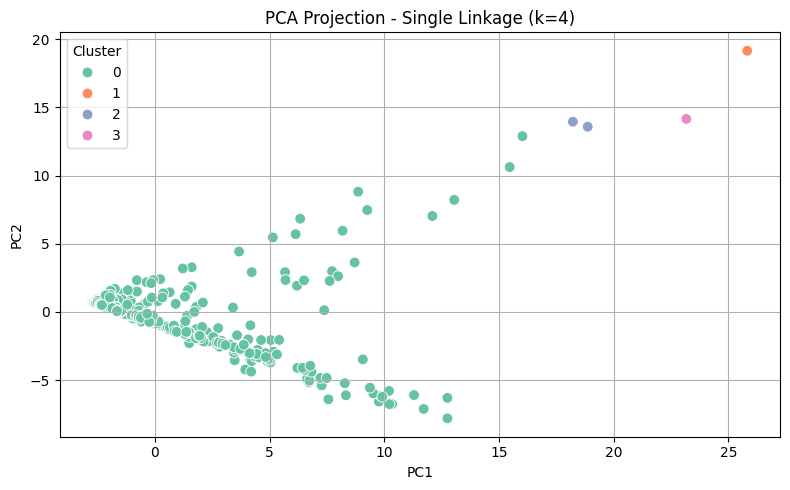

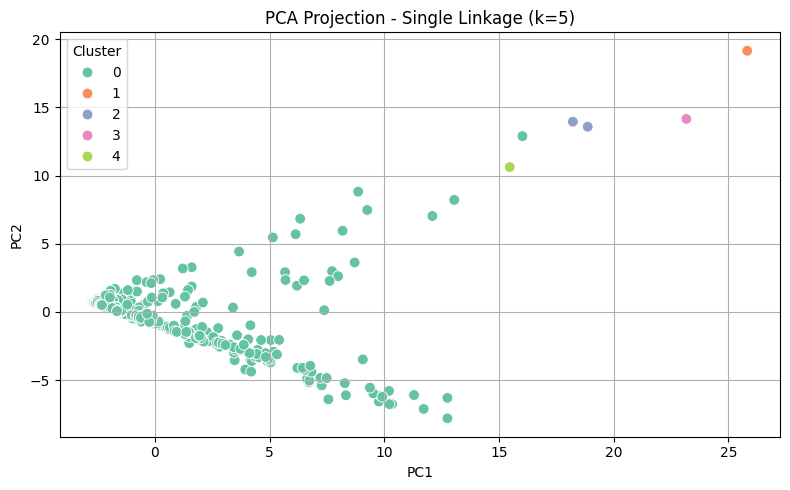

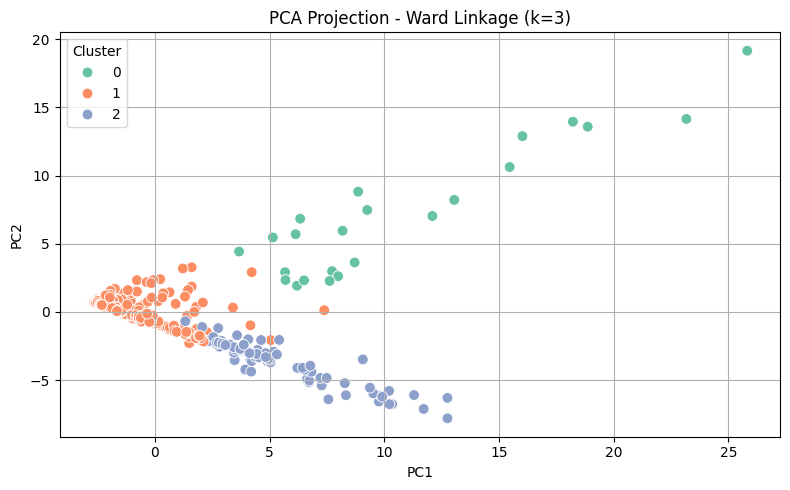

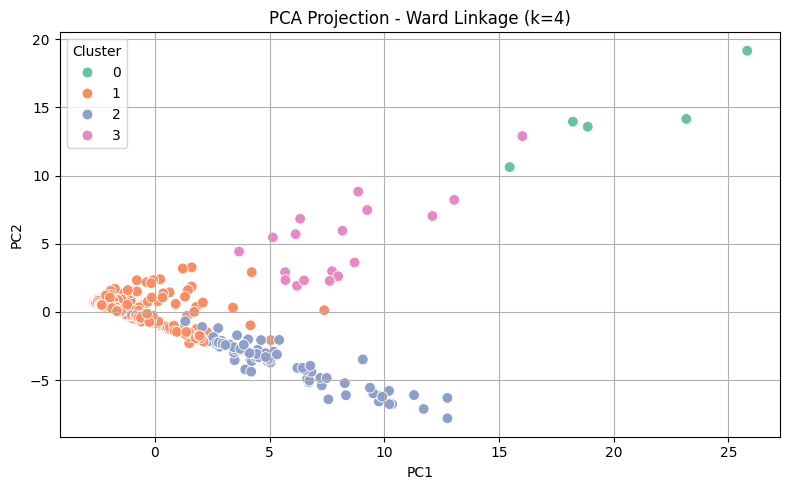

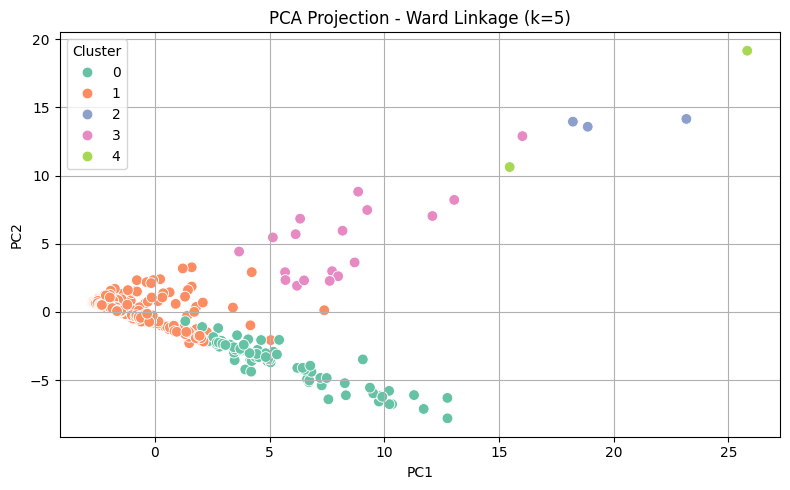

In [ ]:
meta_df = df_agg[['Hospital Name', 'Year']].reset_index(drop=True)

k_clusters(df_scaled, meta_df, linkage='complete', k_range=range(3, 6))
k_clusters(df_scaled, meta_df, linkage='average', k_range=range(3, 6))
k_clusters(df_scaled, meta_df, linkage='single', k_range=range(3, 6))
k_clusters(df_scaled, meta_df, linkage='ward', k_range=range(3, 6))

**Interpretation of PCA projections**

1. Complete Linkage
  - k=3: Some seperation, clusters 1 and 2 are not clearly seperated
  - k=4: Cluster imbalance, 2-3 observations in clusters
  - k=5: Cluster imbalance, small clusters appearing with 1 observation
2. Average Linkage
  - k=3: Third cluster is not well defined
  - k=4: Cluster imbalance, 2 observations in clusters 0-1, 3
  - k=5: Cluster imbalance, 1-2 observations in clusters 1-4
3. Single Linkage
  - k=3-5: Cluster imbalance.
4. Ward Linkage
  - k=3: Good cluster seperation, better cluster balance
  - k=4: Formation of new cluster in PC1 and does not overlap with other clusters
  - k=5: Fifth cluster is not well defined.

**Next Steps**: Evaluate feature importance in Ward Linkage method with k= 3,4,5

#### Ward Dendrograms (k=3, 4, 5) and feature importance

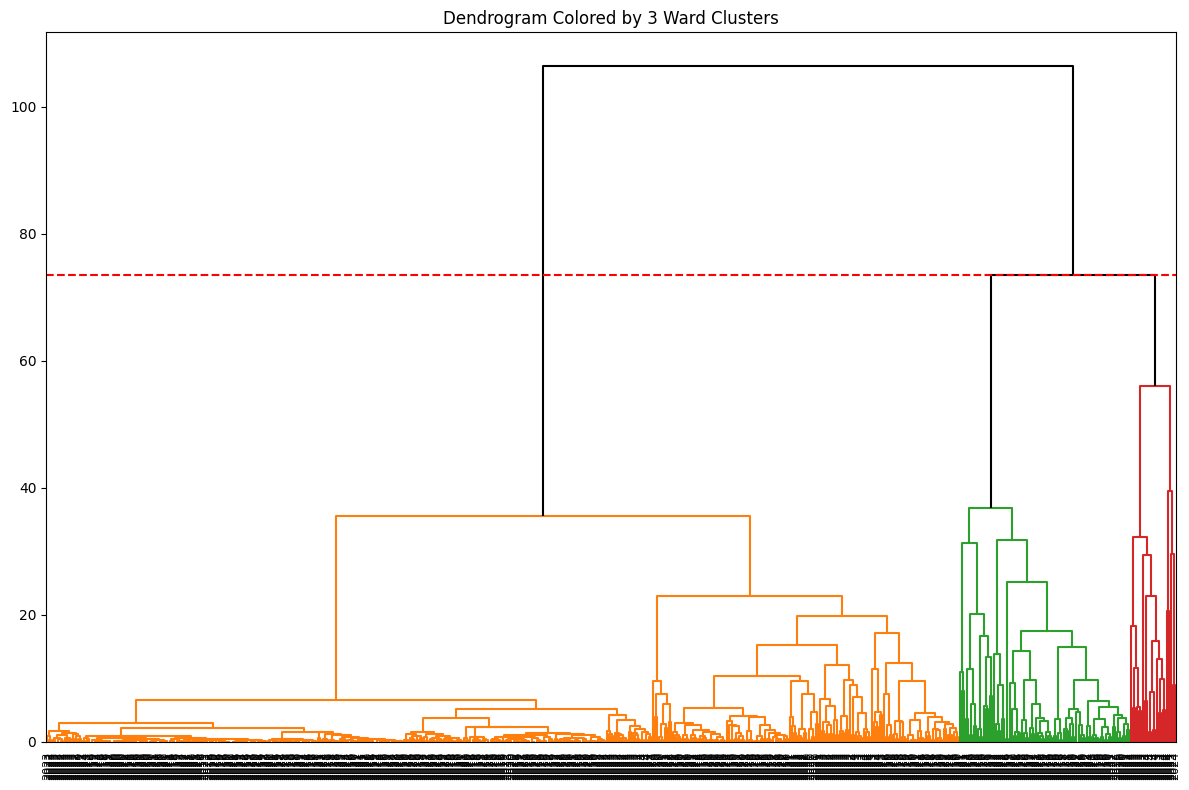

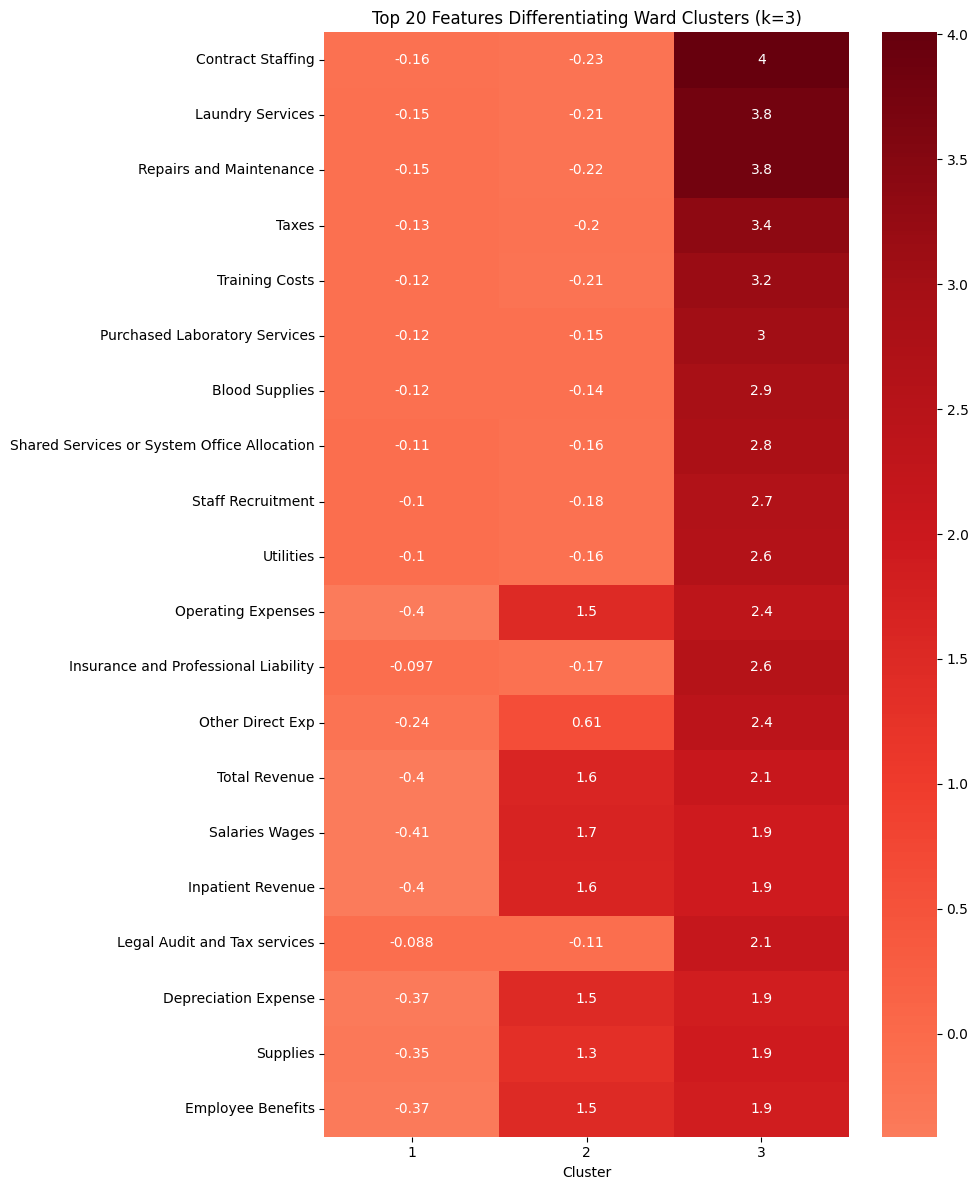

In [ ]:
labels = (df_agg['Year'].astype(str)).to_list()
ward3_ids = colored_dendrogram(df_scaled, linkage_type='ward', n_clusters=3, labels=labels)
df_ward3 = df_agg.copy()
df_ward3['Cluster'] = ward3_ids

df_w3_clustered_info = features_by_cluster(df_scaled, df_agg[['Hospital Name', 'Year']], linkage_type='ward', k=3)

**Interpretation**

1. Cluster 1
  - Low feature values.
    - Operating Expenses
    - Other Direct Exp
    - Total Revenue
    - Salaries Wages
    - Inpatient revenue
    - Supplies
    - Employee Benefits

2. Cluster 2
  - Mid feature values
    - Operating Expenses
    - Other Direct Exp
    - Total Revenue
    - Salaries Wages
    - Inpatient revenue
    - Supplies
    - Employee Benefits

2. Cluster 3
  - Higest feature values
    - Contract Staffing
    - Laudry Services
    - Repairs and Maintenance
    - Taxes
    - Trianing Costs
    - Purchased Laboratory Services
    - Blood Supplies
    - Staff Recruiment
    - Utilities
    - Operating Expenses
    - Other Direct Exp
    - Total Revenue
    - Salaries Wages
    - Inpatient revenue
    - Supplies
    - Employee Benefits

Possible meaning:
1. Cluster 1 = Small or low resource hospitals
2. Cluster 2 = Mid-size hospitals
3. Cluster 3 = Large hospitals or academic centers

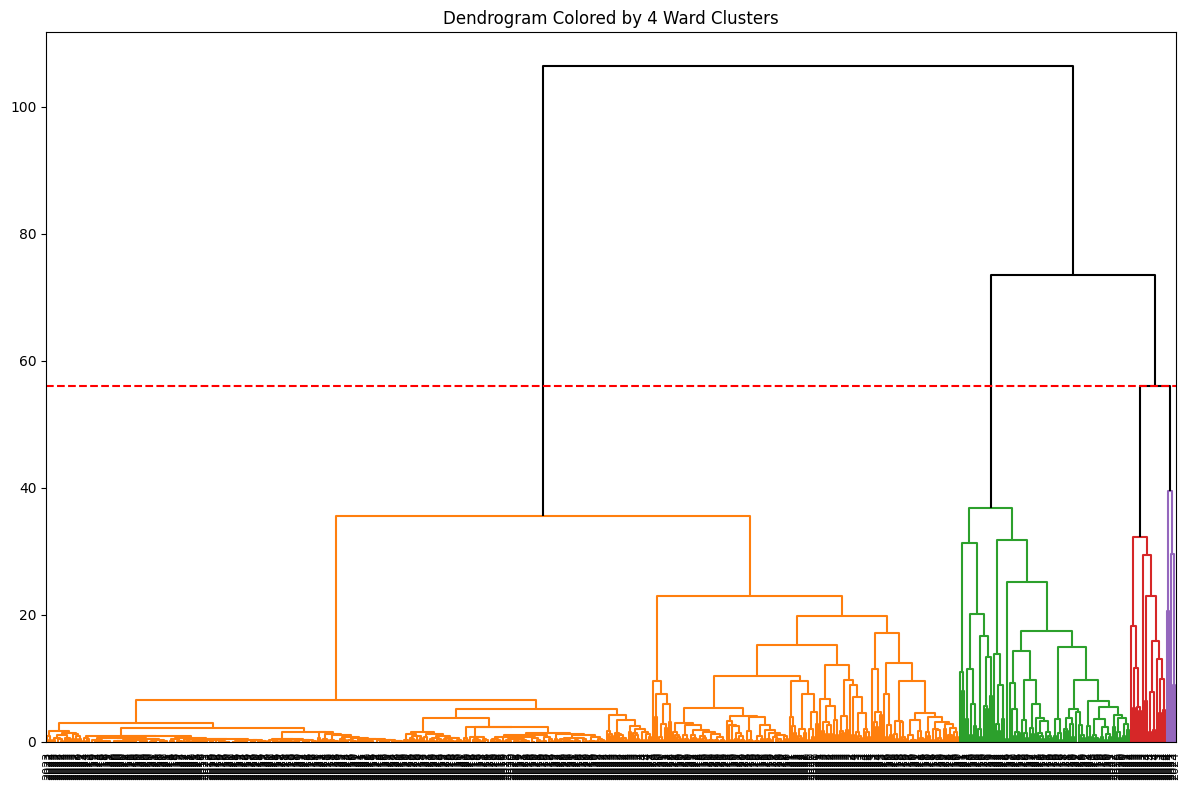

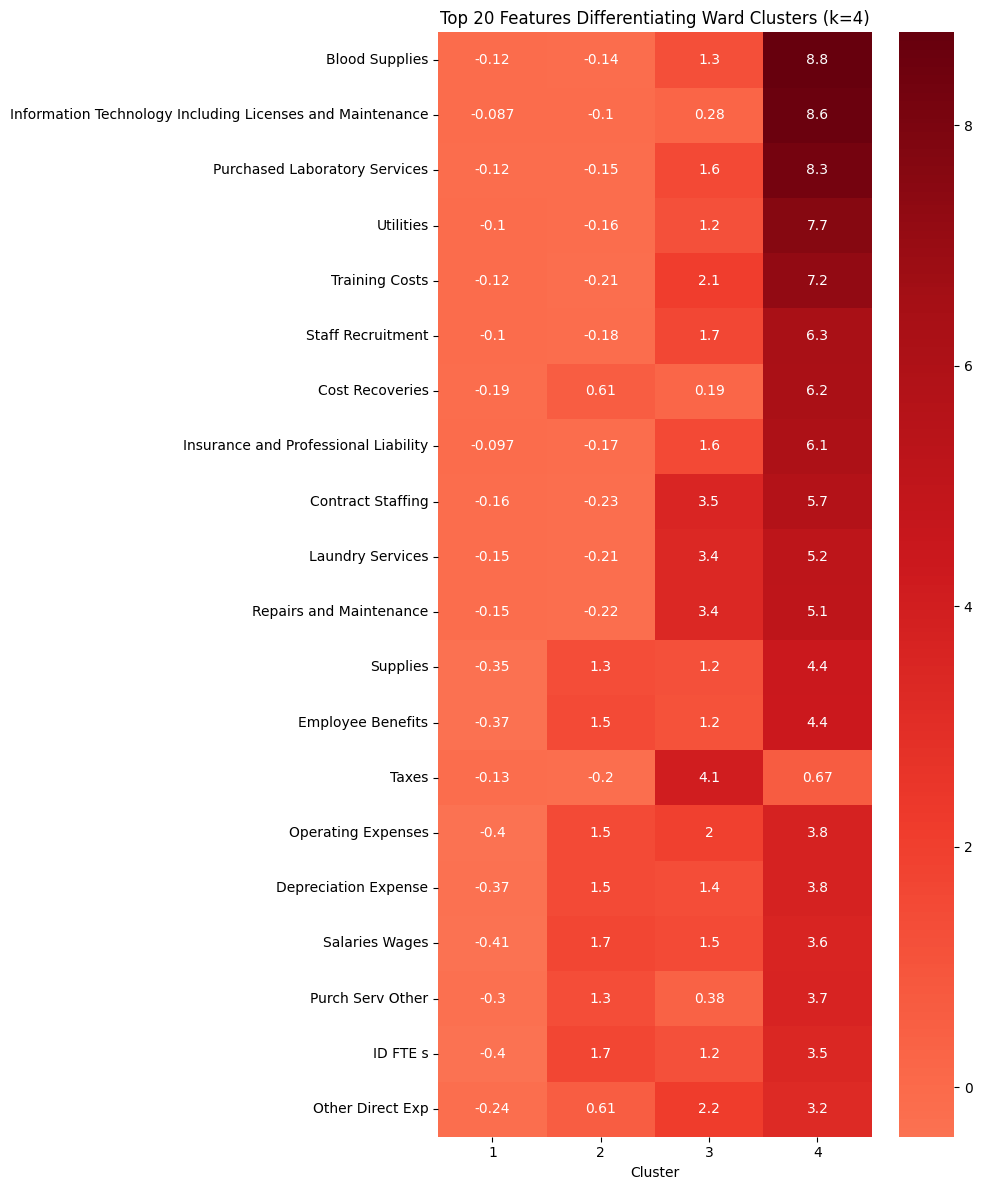

In [ ]:
labels = (df_agg['Year'].astype(str)).to_list()
ward4_ids = colored_dendrogram(df_scaled, linkage_type='ward', n_clusters=4, labels=labels)
df_ward4 = df_agg.copy()
df_ward4['Cluster'] = ward4_ids

df_w4_clustered_info = features_by_cluster(df_scaled, df_agg[['Hospital Name', 'Year']], linkage_type='ward', k=4)

**Interpretation**

1. Cluster 1
  - All negative features
  - Lowest values
    - Supplies
    - Employee Benifits
    - Operating Expenses
    - Depreciation Expense
    - Salary Wages
    - ID FTE s
    - Other Direct Exp
2. Cluster 2
  - Similar to cluster 1 with the exception (higher) of these features:
    - Supplies
    - Employee Benifits
    - Operating Expenses
    - Depreciation Expense
    - Salary Wages
    - ID FTE s
    - Other Direct Exp
3. Cluster 3
  - Similar to cluster 2 with the exception (higher) of these features:
    - Insurance and Professional Liability
    - Contract Staffing
    - Laundry Services
    - Repairs and Maintenance
    - Taxes
4. Cluster 4
  - Extreme values in:
    - Blood Supplies
    - IT Licenses and Maintenance
    - Purchased Lab Services
    - Utitlies, Training Costs, Contract Staffing

Possible meaning:
1. Cluster 1 = Small/low resouce hospitals with tight budgets and low infrastructure
2. Cluster 2 = Urban hospitals with balanced employee-related costs and purchased services.
3. Cluster 3 = Hospital experiencing some cost restructuring, decrease in employee-related expenses, increased reliance of purchased services or administrative changes (High taxes)
4. Cluster 4 = Large, High-Cost and Techy Institutions. There could be academic centers or specialized hospitals.

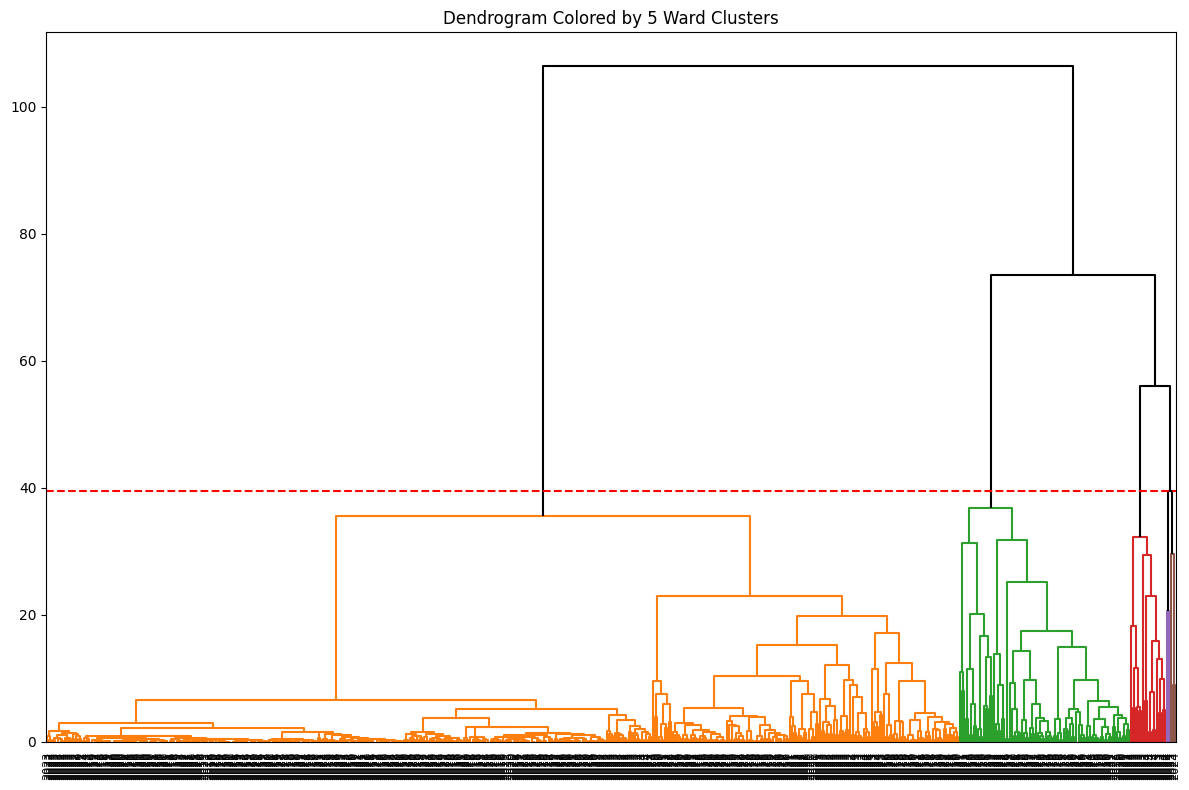

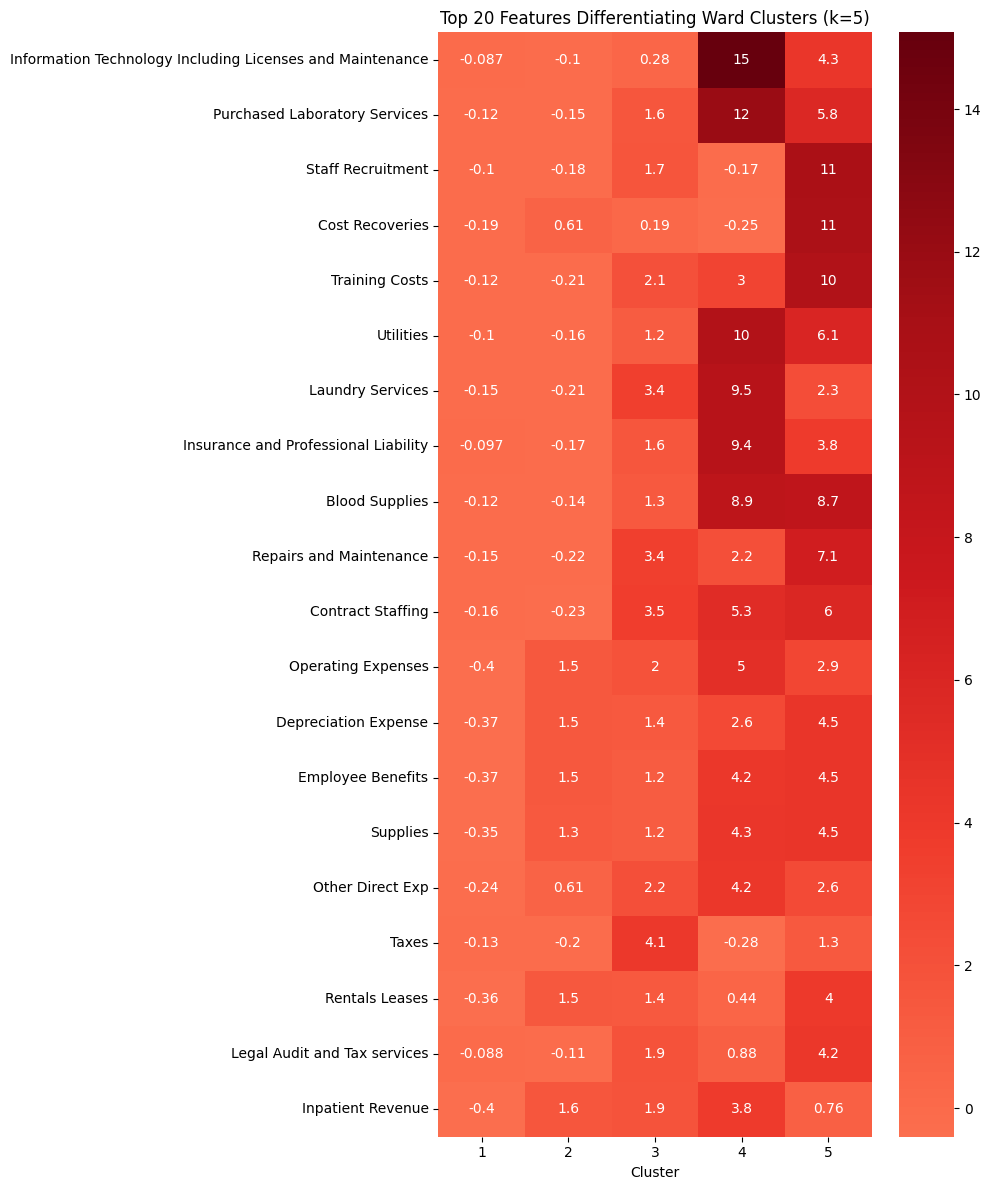

In [ ]:
labels = (df_agg['Year'].astype(str)).to_list()
ward5_ids = colored_dendrogram(df_scaled, linkage_type='ward', n_clusters=5, labels=labels)
df_ward5 = df_agg.copy()
df_ward5['Cluster'] = ward5_ids

df_w5_clustered_info = features_by_cluster(df_scaled, df_agg[['Hospital Name', 'Year']], linkage_type='ward', k=5)


**Interpretation**

1. Cluster 1
  - Minimal operating expeses, employee benefits, supplies, inpatient revenew
2. Cluster 2
  - Minimal purchased services, but with higher operating expenses.
  - Balanced services, lean operations
3. Cluster 3
  - High in taxes, impatient revenew
  - Mid in contract staffing
4. Cluster 4
  - High in purchased laboratory services, utilities, laundry services, blood supplies and **inpatient revenue**.
  - Extreme values in IT including licenses and maintenance.
5. Cluster 5
  - High staff recruiment, training costs, rental leases, legal audit and tax services, repairs and maintenance.
  - Very low in inpatient revenue

Possible meaning:
1. Cluster 1 = Small or low resourced hospitals
2. Cluster 2 = Mid-size general hospitals
3. Cluster 3 = Intensive services or with high admin departments
4. Cluster 4 = Large and/or advanced institutions
5. Cluster 5 = Hard to interpret, maybe specialized institutions.

### **Final Hierarchical Selection**

We identified four distinct clusters of Washington hospitals based on cost metrics using Ward linkage and PCA visualization. Cluster 1 includes low-cost community hospitals, while Cluster 4 captures high-spending/large institutions. These groups show clear operational and financial differences, supported by silhouette scores, PCA space, heatmaps of key features, and feature distribution by clusters.

Ward linkage with k=4
- Had a balance between silhouette scores and was interpretable.
- Clear cluster seperation in PCA space.
- Heat map provides clear patters in feature importance for clusters

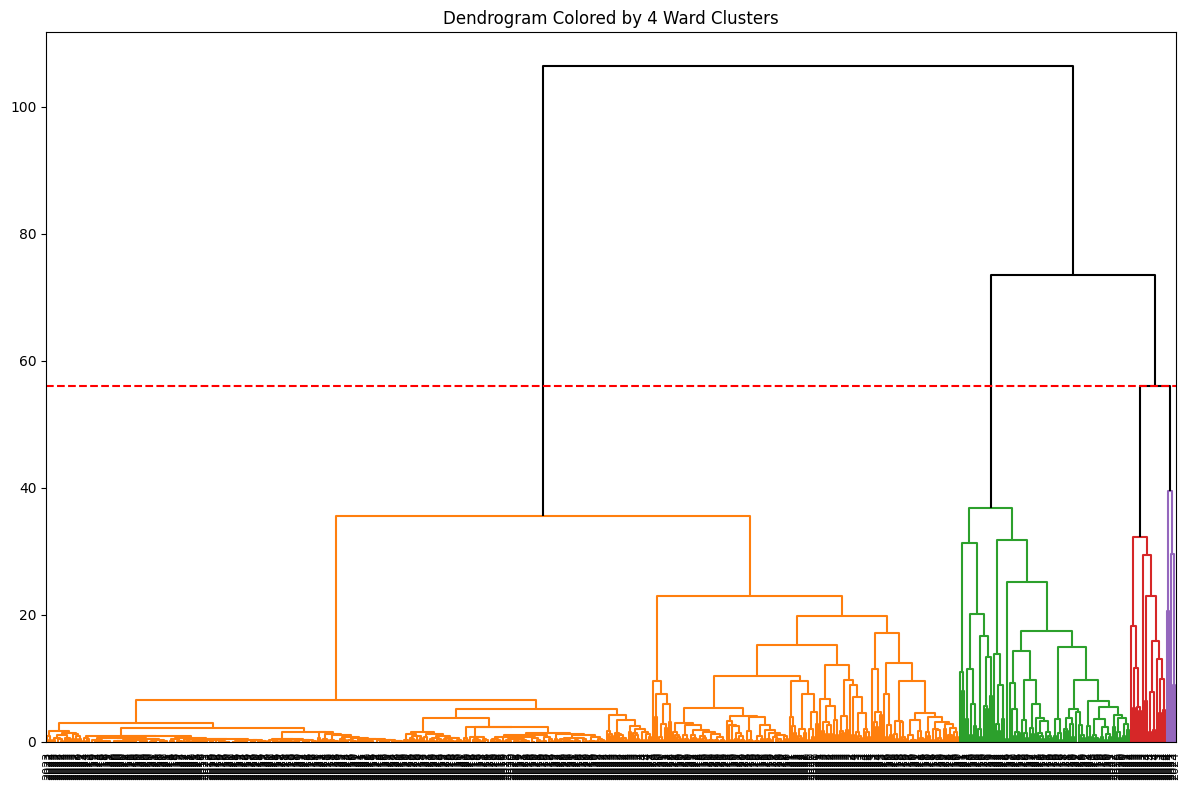

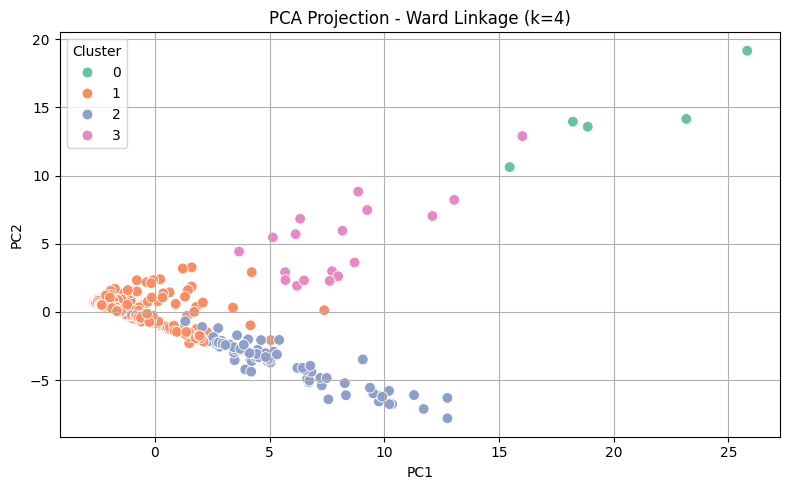

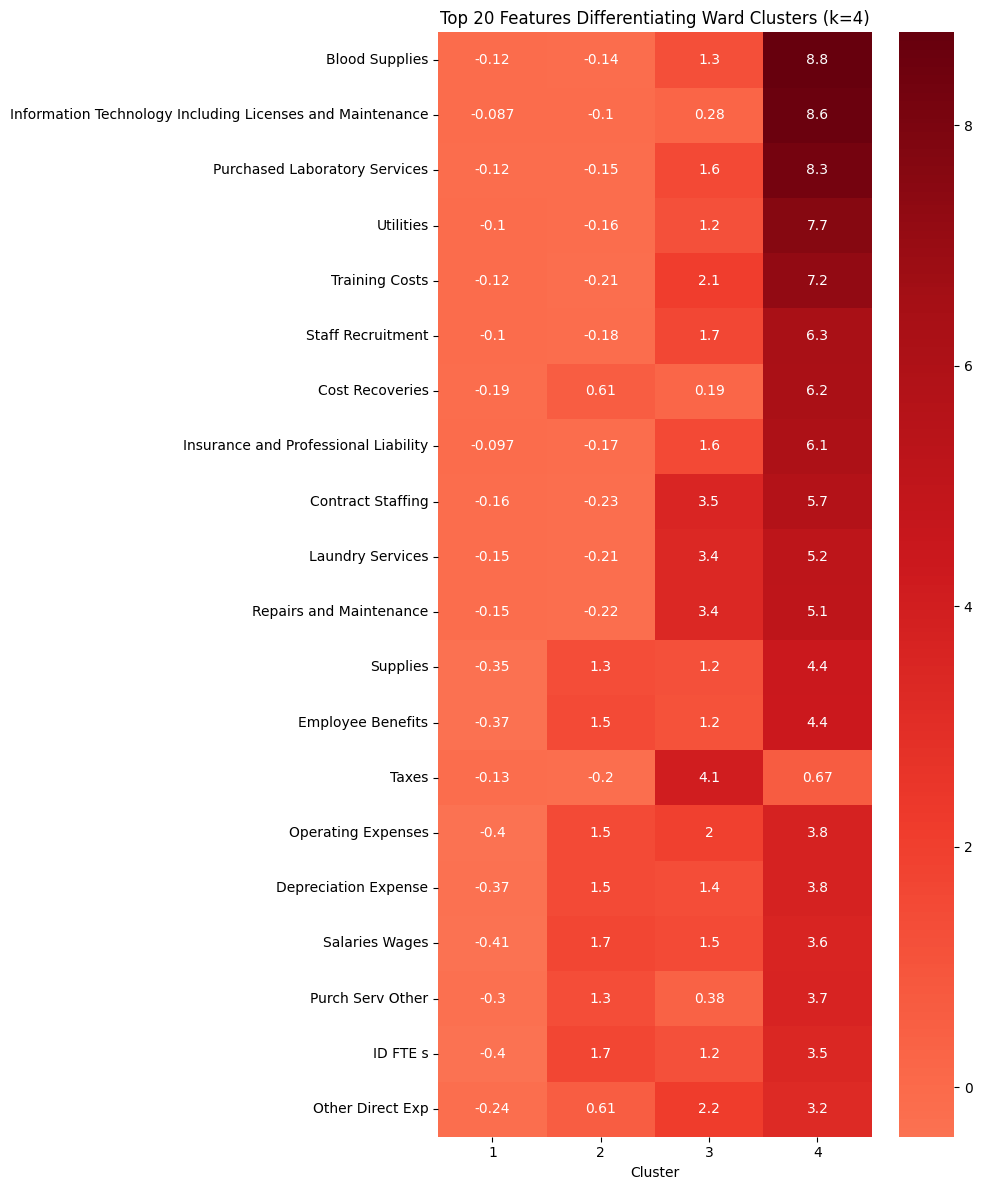

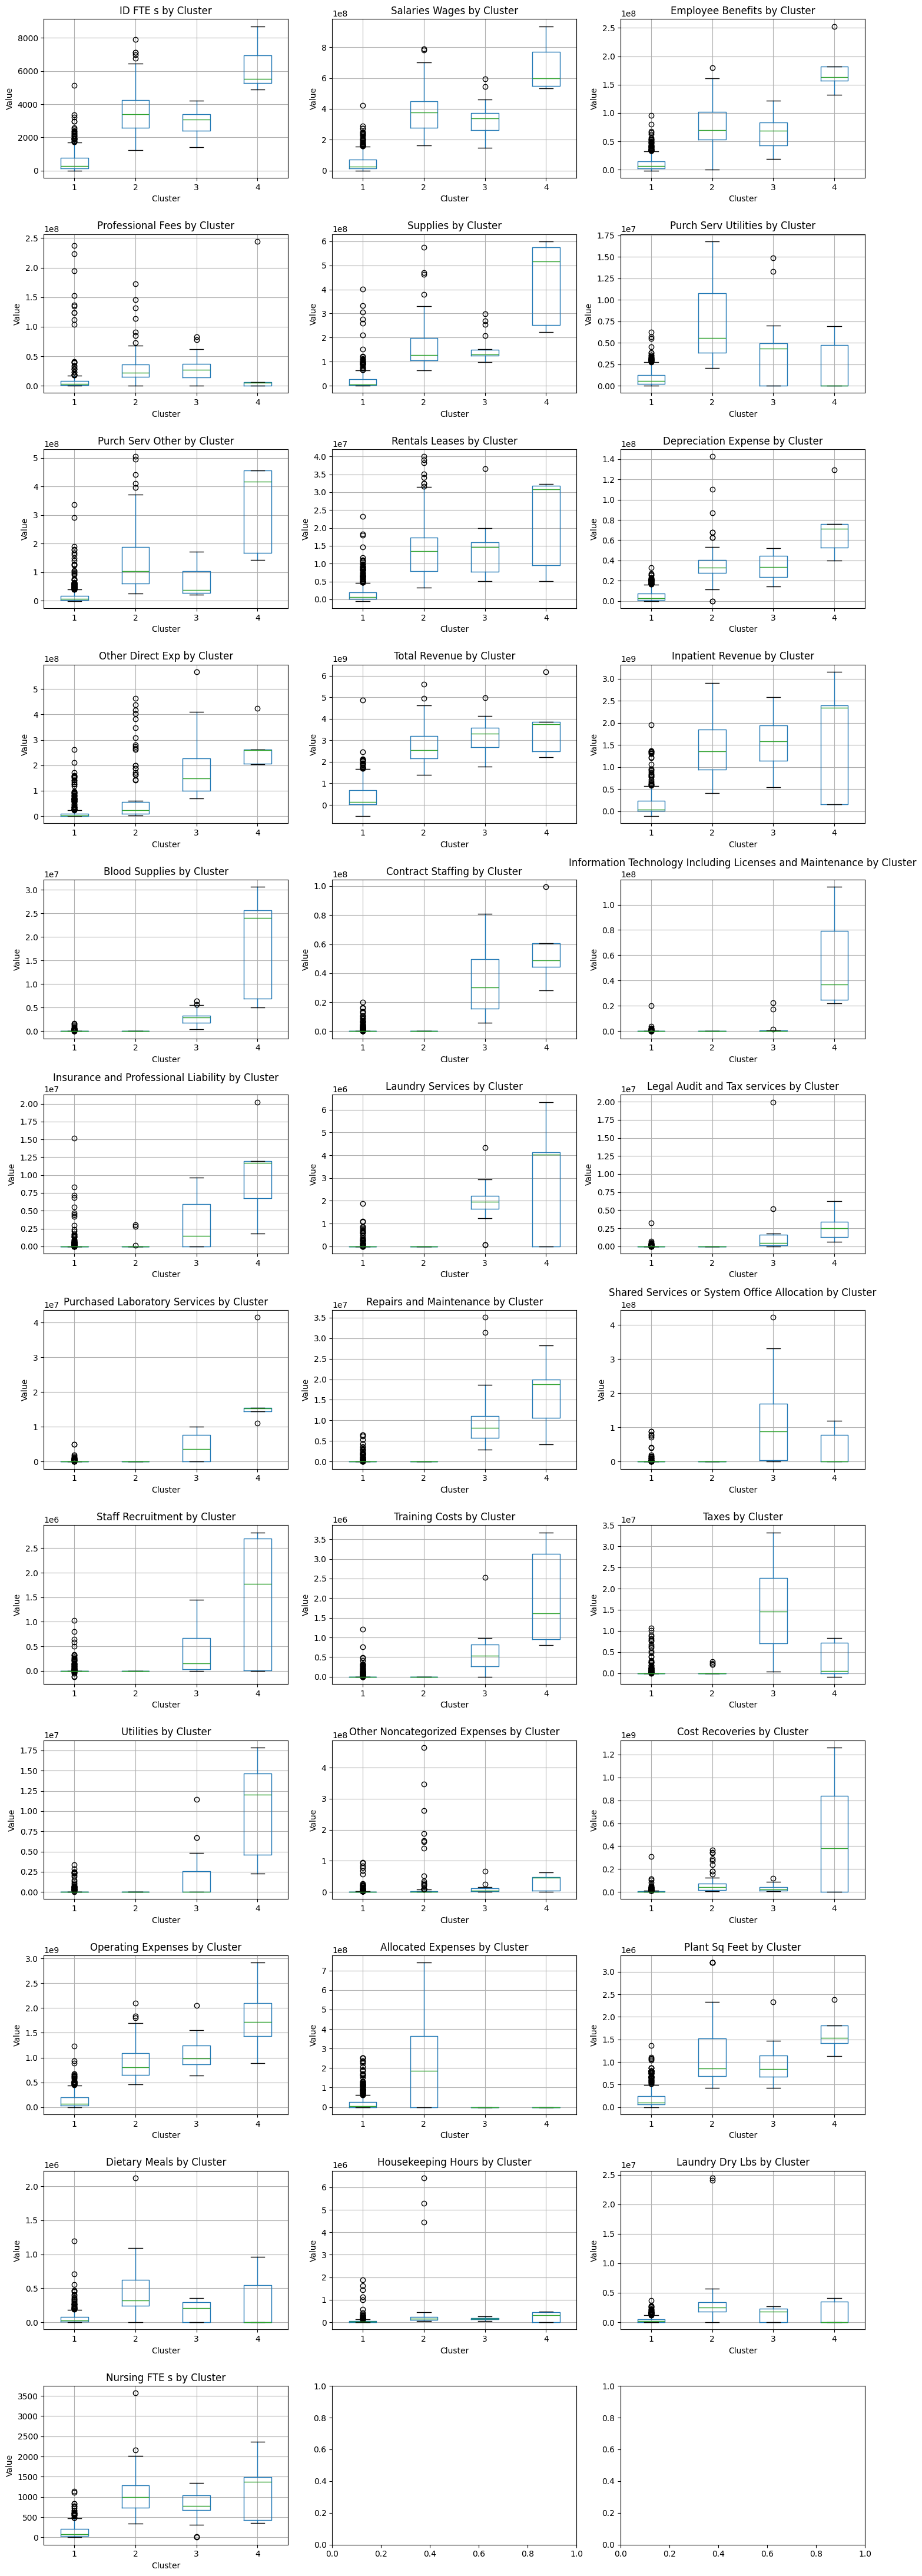

In [ ]:
labels = (df_agg['Year'].astype(str)).to_list()
ward4_ids = colored_dendrogram(df_scaled, linkage_type='ward', n_clusters=4, labels=labels)
k_clusters(df_scaled, meta_df, linkage='ward', k_range=range(4, 5))
df_w4_clustered_info = features_by_cluster(df_scaled, df_agg[['Hospital Name', 'Year']], linkage_type='ward', k=4)

df_hclust_k4 = df_agg.copy()
df_hclust_k4['Cluster'] = cluster_labels
df_cluster_tracking = df_hclust_k4[['Hospital Name', 'Year', 'Cluster']].drop_duplicates()
exclude = ['Hospital Name', 'Year', 'License Number', 'Acct #', 'Cost Center', 'Units of Measure', 'Cluster']
features = [col for col in df_hclust_k4.columns if col not in exclude]

fig, axes = plt.subplots(12, 3, figsize=(15, 44))
axes = axes.flatten()

for i, feature in enumerate(features):
    df_hclust_k4.boxplot(column=feature, by='Cluster', ax=axes[i])
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Value')


plt.suptitle('')
plt.tight_layout()
plt.show()

#### Hospital Cluster Assignment Heatmap (Ward Linkage, k=4)

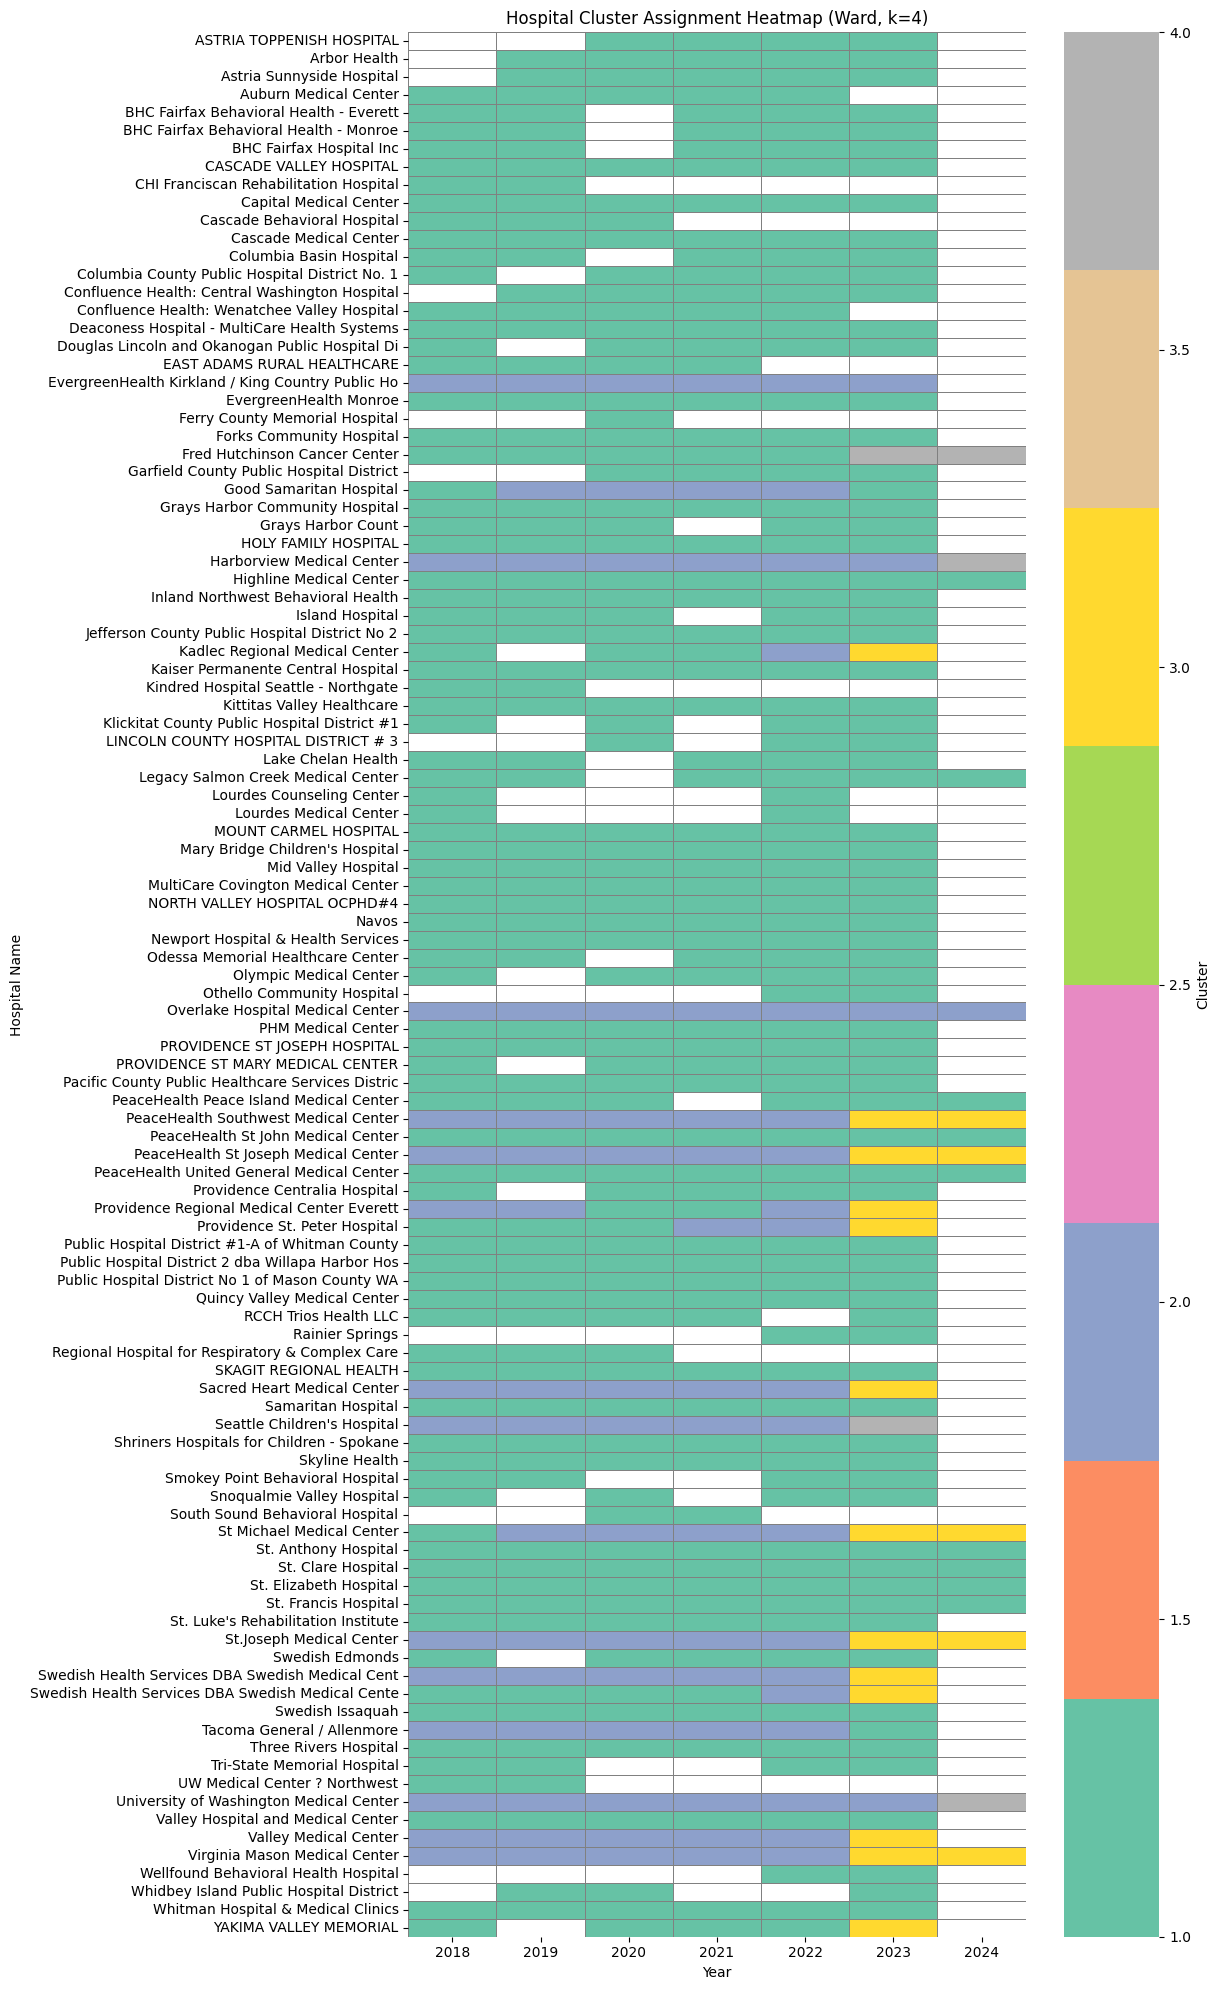

In [ ]:
df_pivot = df_cluster_tracking.pivot(index='Hospital Name', columns='Year', values='Cluster')
plt.figure(figsize=(12, 20))
sns.heatmap(df_pivot, cmap='Set2', cbar_kws={'label': 'Cluster'}, linewidths=0.5, linecolor='gray')
plt.title('Hospital Cluster Assignment Heatmap (Ward, k=4)')
plt.xlabel('Year')
plt.ylabel('Hospital Name')
plt.tight_layout()
plt.show()

This heatmap displays the cluster assignments of Washington State hospitals over time, derived from hierarchical clustering using Ward linkage with k=4.
Each row represents a hospital, and each column represents a year from 2018 to 2024. The colors correspond to the four clusters identified in the Ward k=4 model.

This plot helps track whether hospitals remained in the same cluster or shift across years — indicating potential operational, financial, or structural changes. It also reveals stability patterns within the hospital system and validates the usefulness of Ward linkage for identifying distinct behavioral groups over time.

**Notable observations**:

- **University of Washington Medical Center** and **Harborview Medical Center** remained in Cluster 2 across all years until 2024, when it shifted into Cluster 4. This shift likely reflects increased operational complexity, such as growth in outsourced services, incrase in staffing, or cost of structure changes.

- **Frech Hutchinson Cancer Center** was part of Cluster 1 from 2018 to 2022, when it moved into Cluster 4. After some research this makes sense as in 2022 the Fred Hutchinson merged with Seattle Cancer Care Alliance. This change in cluster reflects their expansion of clinical services, staffing, purchased services, employee benifits and utilities. Prior to the merger they were known as a research-heave institute.

- **Changes from Cluster 2 to Cluster 3** likely experienced some cost restructuring, they experienced some decrease in employee-related expenses, increased their reliance on purchased services or administrative changes (High taxes).

# **K-Means Clustering**

## PCA and SVD

In [ ]:
np.random.seed(0);
pca = PCA()
pca_out = pca.fit_transform(df_scaled)
print("Number of Principal Components:", pca.n_components_)
pca_df = pd.DataFrame(pca.components_.T
                  , index=numeric_cols)
pca_df.loc[:,0:5].sort_values(by=abs(0),ascending=False)[0:5]

Number of Principal Components: 34


0         1         2         3         4         5
Operating Expenses  0.251351 -0.046908  0.067389 -0.054820  0.046818 -0.127272
Salaries Wages      0.245363 -0.091342 -0.012958  0.024948 -0.037489 -0.090231
ID FTE s            0.240864 -0.110222 -0.019754  0.035187 -0.037826 -0.043346
Total Revenue       0.236945 -0.092752  0.094755 -0.080647  0.009020 -0.102595
Supplies            0.234790 -0.051899 -0.082473  0.050756  0.058647 -0.055404

In [ ]:
pca_df.loc[:,0:5].sort_values(by=abs(1),ascending=False)[0:5]

0         1         2         3         4  \
Contract Staffing        0.150679  0.268878  0.135338  0.009495 -0.124042   
Laundry Services         0.146175  0.263818  0.159279 -0.256735 -0.095553   
Repairs and Maintenance  0.142689  0.262381  0.136321  0.176356 -0.095461   
Blood Supplies           0.140630  0.257252 -0.292349  0.009640  0.138448   
Training Costs           0.129959  0.249494 -0.149391  0.303454  0.012256   

                                5  
Contract Staffing        0.013211  
Laundry Services        -0.049854  
Repairs and Maintenance  0.057306  
Blood Supplies           0.084747  
Training Costs           0.151393

The top 5 contributing variables to PC1 (based on absolute value) were operating expenses, salaries/wages, ID FTEs, total revenue, and supplies. For PC2, the top 5 contributing variables were completely different, with contract staffing, laundry service, repairs and maintenance, blood supplies, and training costs.

Still, for PC1, the top two variables have similar magnitudes of coefficient, varying by less than 0.01. For PC2, the difference in contribution by the top 2 variables differs by less than (0.005).

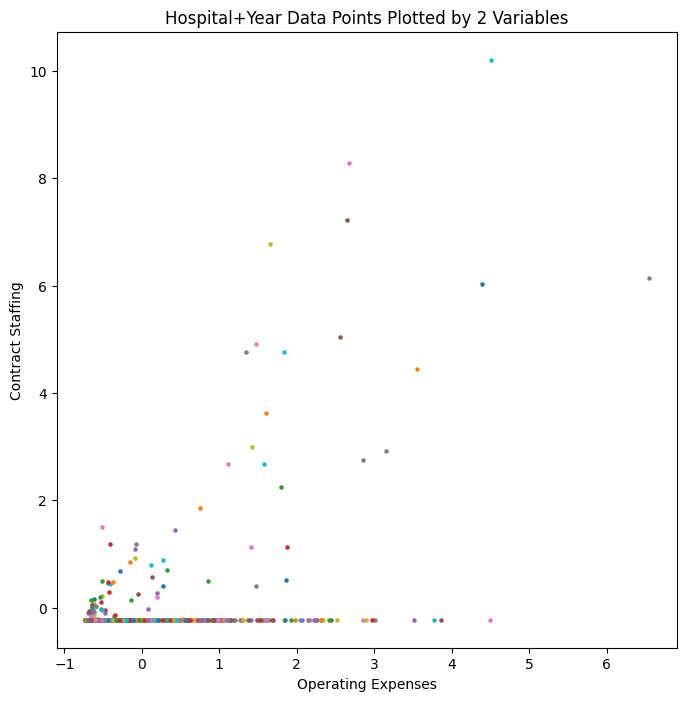

In [ ]:
#Plotting on two features
fig, ax = plt.subplots(1, 1, figsize=(8,8))
for i in range(0,df_scaled.shape[0]):
    ax.scatter(df_scaled.loc[i,'Operating Expenses'], df_scaled.loc[i,'Contract Staffing'], s=5)
ax.set_title("Hospital+Year Data Points Plotted by 2 Variables")
ax.set_xlabel("Operating Expenses")
ax.set_ylabel("Contract Staffing");

Looking along the y-axis, representing Contract staffing, there can be two very generalized groups appearing: those where contract staffing remains at 0 while the operating expenses change, and those where the contract staffing increases almost linearly with the operating expenses. Due to the high number of data points long y=0, it's difficult to determine just how many dots are clustered together along the operating expenses axis.

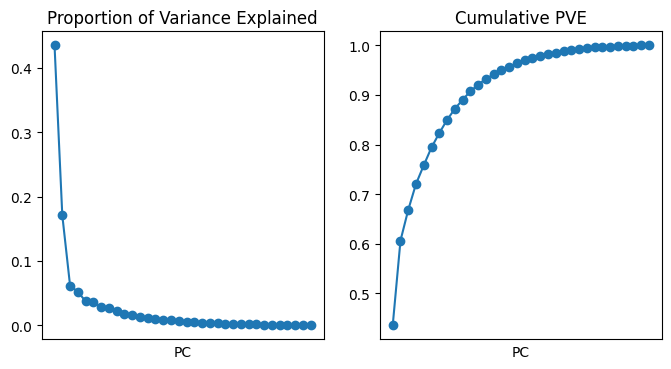

In [ ]:
cumul_ratio = [pca.explained_variance_ratio_[0]]
for i in range(1,len(pca.explained_variance_ratio_)):
    cumul_ratio.append(cumul_ratio[i-1] + pca.explained_variance_ratio_[i])
_, axarr = plt.subplots(1,2, figsize = (8,4))
axarr[0].plot(pca.explained_variance_ratio_, '-o')
axarr[0].set_title('Proportion of Variance Explained')
axarr[0].set_xticks([])
axarr[0].set_xlabel("PC")
axarr[1].plot(cumul_ratio/sum(pca.explained_variance_ratio_), '-o')
axarr[1].set_title('Cumulative PVE')
axarr[1].set_xticks([])
axarr[1].set_xlabel("PC");

The proportion of variance explained (PVE) plot shows that the amount of variance explained by principal component is significant for the first 3, then decreases significantly. The first principal component alone accounts for over 40% of the variance explained, which is relatively a lot. The leveling off of the cumulative PVE as the principal component count increases tells us that once 6 principal components are included, ~80% of the variance within the data has already been explained.

## SVD
Technically, since the data was already scaled, running the above PCA was the same as doing SVD. However, SVD decomposition then allows us to determine the principal components that are a linear combinations of the variables that can then best describe the variation within the data.

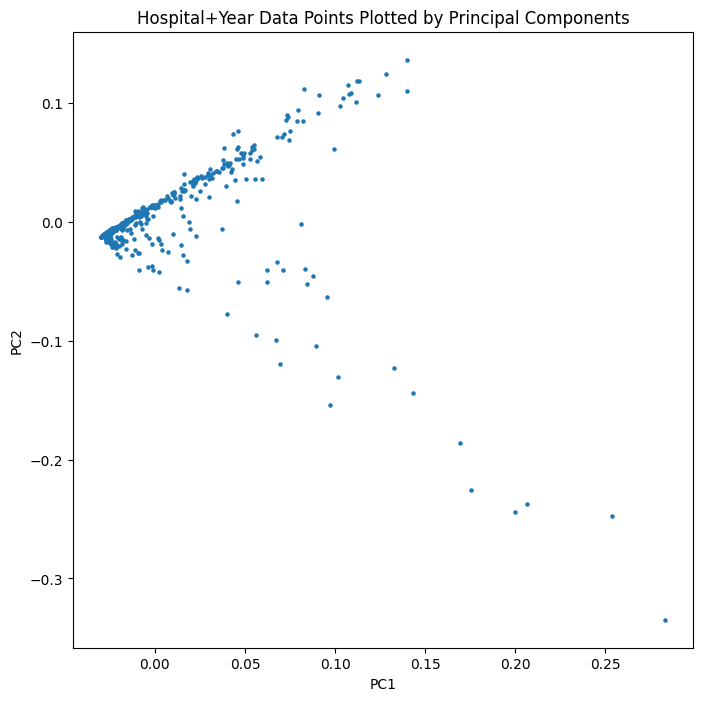

In [ ]:
#Plotting on two features SVD
U, s, V = np.linalg.svd(df_scaled, full_matrices=True)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(U[:,0], U[:,1], s=5)
ax.set_title("Hospital+Year Data Points Plotted by Principal Components")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

These data look somewhat similar to plotting the two variables against each other, but rotated. We again see a clustering along one flat line (which previously was at the lower end of the contract staffing variable) while other data points migrate away along some linear trend.

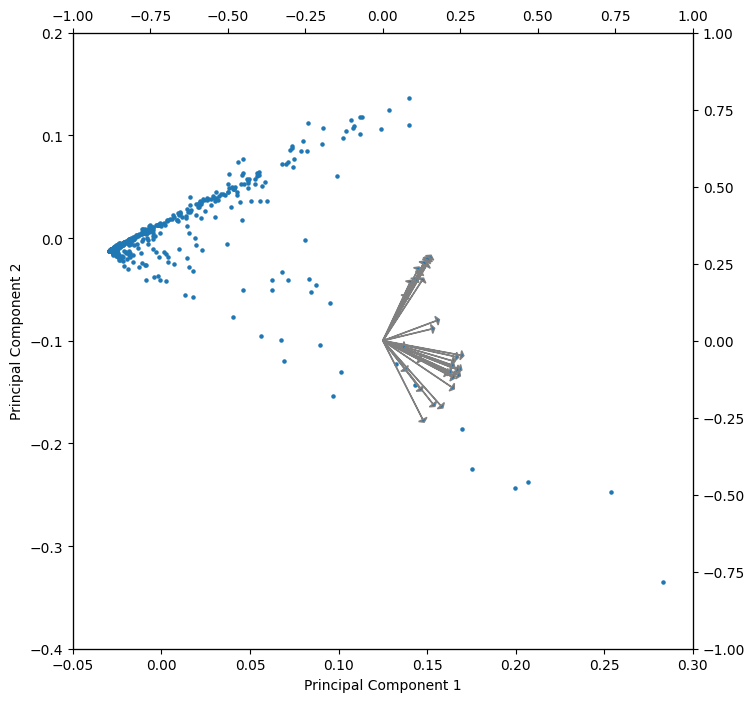

In [ ]:
fig , ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlim(-0.05,0.3)
ax1.set_ylim(-0.4,0.2)

ax1.scatter(U[:,0], U[:,1], s=5)

ax2 = ax1.twinx().twiny()
ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)



for i, (comp, var) in enumerate(zip(pca.components_.T, df_scaled.columns)):
    ax2.arrow(0, 0, comp[0], comp[1], head_width=0.03, head_length=0.01,  ec='gray')

ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2");

Looking at the vectors of each variable's contribution to the data when plotted along PC1 and PC2, there appear to be 2 main groupings occurring: variables that increase as PC2 increase, and those that decrease as PC2 increases. All variables seem to have a positive relationship to PC1. This clear grouping of most of the variables could explain why we saw such a high PVE explained by just our first principal component.

## K-Means: Scaled Data

Theoretical background: goal of K-means is to determine where clusters occur within the data. This is done by assigning an expected number of groups, K, at random locations and iteratively determining where the centroids per group end up such that the within-group sum of squares is minimized. Technically, the within-group sum of squares would be minimized with each entry being a centroid, but this would be overfitting the data, and no longer provide any insight as to what groups occur and the trends among the data. So a balance needs to be kept between the number of centroids being high enough that meaningful subdivisions among the hospitals and years can be found, but not such a high value that the differences between them would no longer be interpretable.

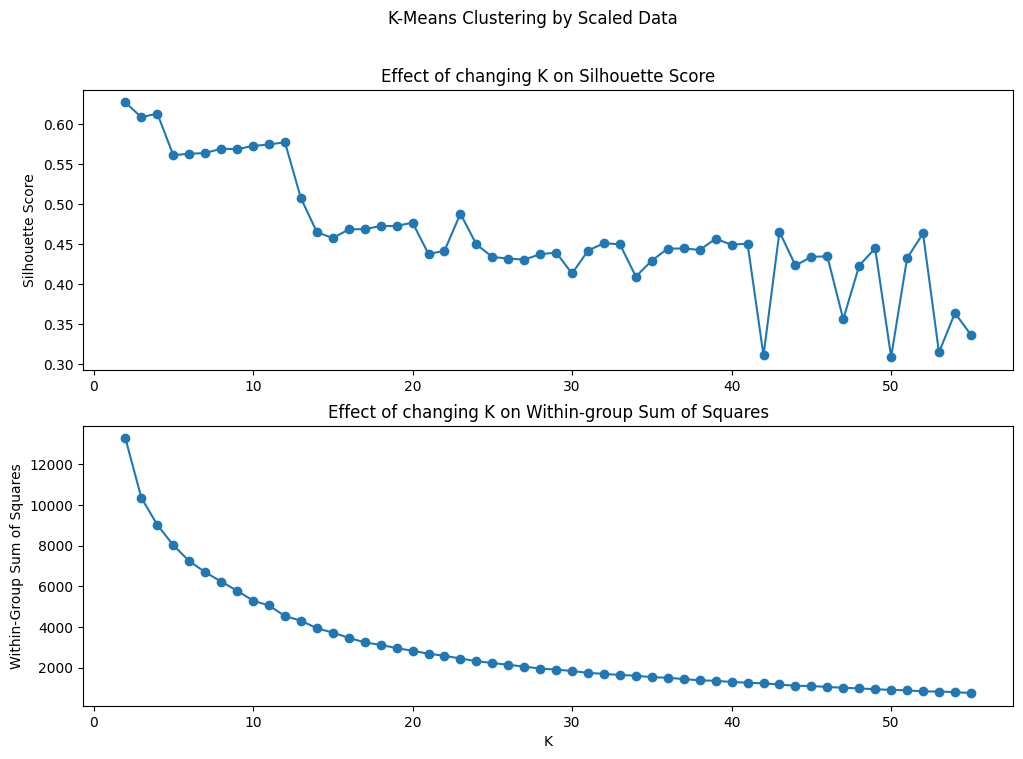

In [ ]:
kvals = np.arange(2,56)
sil_vals = []
wss_vals = []
for k in kvals:
   kmeans = KMeans(n_clusters=k, random_state=5322, n_init=50).fit(df_scaled);
   silscore = metrics.silhouette_score(df_scaled, kmeans.labels_, metric='euclidean')
   sil_vals.append(silscore)
   wss_vals.append(kmeans.inertia_)

fig, ax = plt.subplots(2,1, figsize=(12,8))
fig.suptitle("K-Means Clustering by Scaled Data")
ax[0].plot(kvals, sil_vals, linestyle='-', marker='o')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title("Effect of changing K on Silhouette Score");

ax[1].plot(kvals, wss_vals, linestyle='-', marker='o')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Within-Group Sum of Squares')
ax[1].set_title("Effect of changing K on Within-group Sum of Squares");

The number of cluster centers was tested from a range of 2 to 56. Realistically, having 56 different groupings would not be that interpretable, but the thought process of having a max for 56 for the initial comparison to determine a realistic number for K was the fact that 56 groups, if split evenly, would be ~10 data points per centroid.

The within-group sum of squares is large for this dataset. While the curve of it begins to decrease at around 10 and then again around 20, it still is decreasing as the number of clusters goes up, only leveling closer to 50. But, this is to be expected, since technically this value should be approaching zero as the number of centroids becomes equal to the overall number of data points

For a silhouette score, the ideal value is close to 1. The silhouette score here begins at over 0.6 with only 2 clusters, then shows a clear drop between 5 and 6 clusters, although it remains fairly high at above 0.55. The silhouette score then rises just slightly as the number of clusters is increased to 12 before dropping down again. Past 12 clusters, the score is generally decreasing.

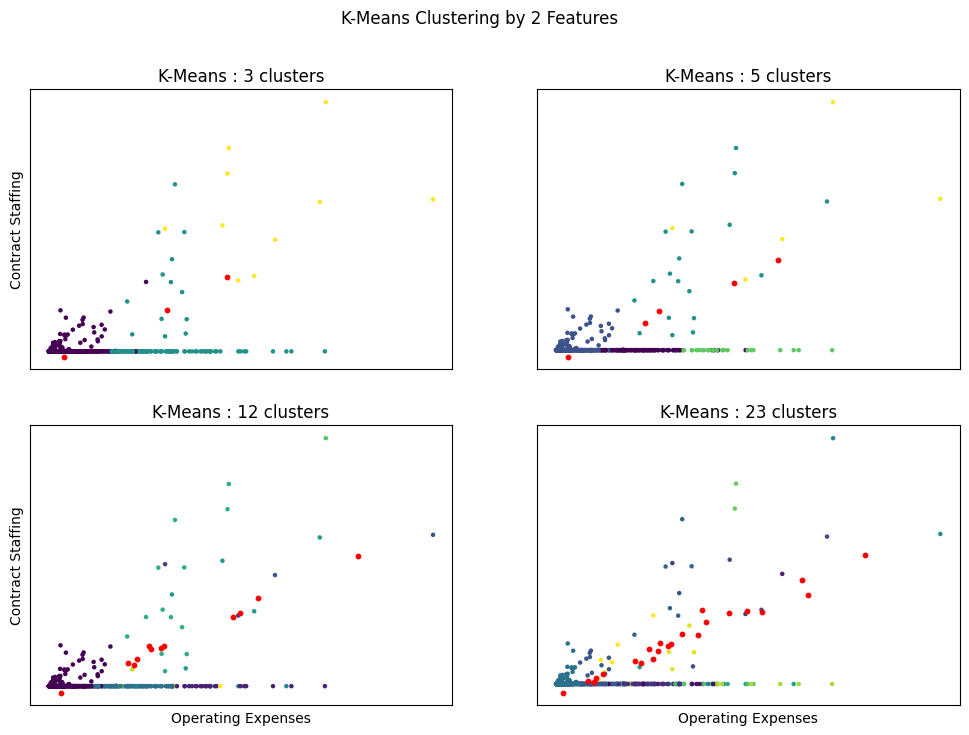

In [ ]:
#From scikit learn: https://scikit-learn.org/stable/auto_examples/cluster/plot_bisect_kmeans.html#sphx-glr-auto-examples-cluster-plot-bisect-kmeans-py
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

# Number of cluster centers for KMeans
n_clusters_list = [3, 5, 12, 23]

# Algorithms to compare
clustering_algorithms = {
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(2, 2, figsize=(12,8))

fig.suptitle("K-Means Clustering by 2 Features")
axs = axs.T

i_ct = 0 #Row
j_ct = 0 #Col
k_means_labels_locs = {}
for j, n_clusters in enumerate(n_clusters_list):
    algo = KMeans(n_clusters=n_clusters, random_state=5322, n_init=50)
    algo.fit(df_scaled)
    centers = algo.cluster_centers_
    axs[j_ct,i_ct].scatter(df_scaled['Operating Expenses'], df_scaled['Contract Staffing'], s=5, c=algo.labels_)
    axs[j_ct,i_ct].scatter(centers[:, 0], centers[:, 1], c="r", s=10)
    axs[j_ct,i_ct].set_title(f"K-Means : {n_clusters} clusters")
    axs[j_ct,i_ct].set_xlabel('Operating Expenses')
    axs[j_ct,i_ct].set_ylabel('Contract Staffing')

    for i in set(algo.labels_):
        ind_locs = []
        for h in range(0,len(algo.labels_)):
            if algo.labels_[h] == i:
                ind_locs.append(h)
            k_means_labels_locs[str(n_clusters)+"_"+str(i)] = ind_locs

    if j_ct < 1:
        j_ct += 1
    else:
        i_ct +=1
        j_ct = 0
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In the above plots, groups are distinguished by color, and the red dots indicate centroids of the groupings. At K=3, the data is generally getting split into the values that are low along both axes, middle along the operating expenses (without much influence from contract staffing), and those that are largest along both axes. At K=5, we see these groupings split into smaller groups that begin to make more sense, where the data points that are low along the axis of contract staffing are split into 3 groups, of low, medium, and high operating expenses; however, 2 new groups are added, and those that are at medium and high operating expenses while at approximately linearly increasing contract staffing values.

12 and 23 were included not because they were necessarily good choices, but to showcase how adding more clusters does not equal a "better" dsitribution of the data among them. Increasing beyond to 12 and 23 clusters, the clear distinctions along these two variables is less apparent, which is not surpising since the groups are influenced by all of the variables, not just the two plotted here. But with adding more centroids, they end up being added along what is roughly a linear positive correlation between the two variables. Additionally, we begin to see more groups that exist with only a few data points.

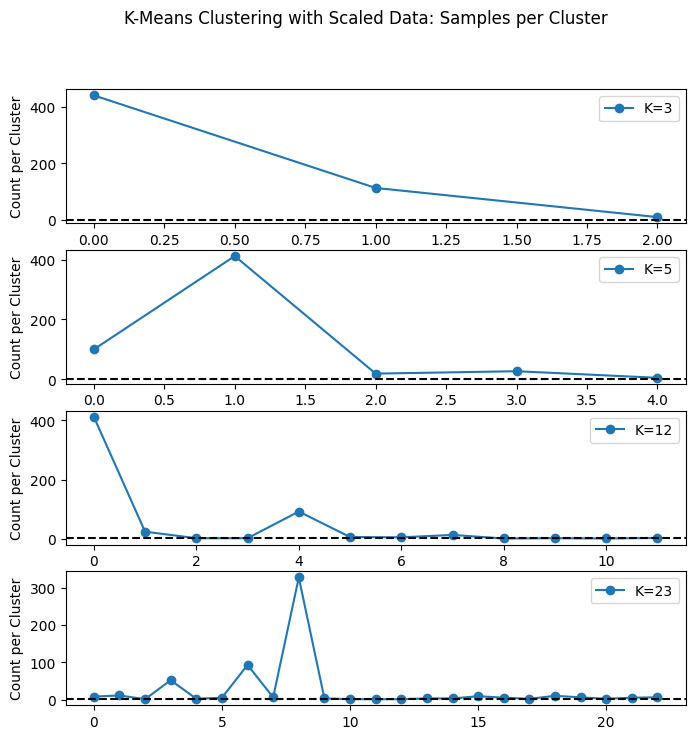

In [ ]:
k_means_ct = {}
k_vals = [3, 5, 12, 23]
for ks in k_vals:
    ks_ct = []
    for i in range(0,ks):
        ks_ct.append(len(k_means_labels_locs[str(ks)+"_"+str(i)]))
    k_means_ct[str(ks)] = ks_ct

fig, axs = plt.subplots(4, 1, figsize=(8,8))
fig.suptitle("K-Means Clustering with Scaled Data: Samples per Cluster")
axs[3].plot(np.arange(23), k_means_ct["23"], "-o")
axs[2].plot(np.arange(12), k_means_ct["12"], "-o")
axs[1].plot(np.arange(5), k_means_ct["5"], "-o")
axs[0].plot(np.arange(3), k_means_ct["3"], "-o")
for i in range(0,4):
    axs[i].axhline(y=1, color = 'k', linestyle ="--")
    axs[i].legend(["K="+str(n_clusters_list[i])], loc='upper right')
    axs[i].set_ylabel('Count per Cluster')

plt.show();

Here, we visualize the count of data points per cluster assignment. Discuss here about how increasing number of clusters does not mean that data will be more evenly split among clusters. All 4 values of K produce one group that has, by far, the greatest number of samples within it, and increasing K does not inherently lead to a more even distribution of samples among groups. Even with 23 clusters, we only really see 3 groups with a significant portion of the data points within them; all the remaining clusters are close to just being 1 sample. While the assignment of each sample to a final grouping might vary between condition, having K=5, 12, or 23 clusters really only produces 3 groups with a sizable number of samples within them, so 5 clusters will be used, since these should produce easier to interpret results for identifying trends.

## K-Means: SVD Results

After considering the above results, we were curious to see how the groupings would compare using principal components as basis for clustering with increasing K.

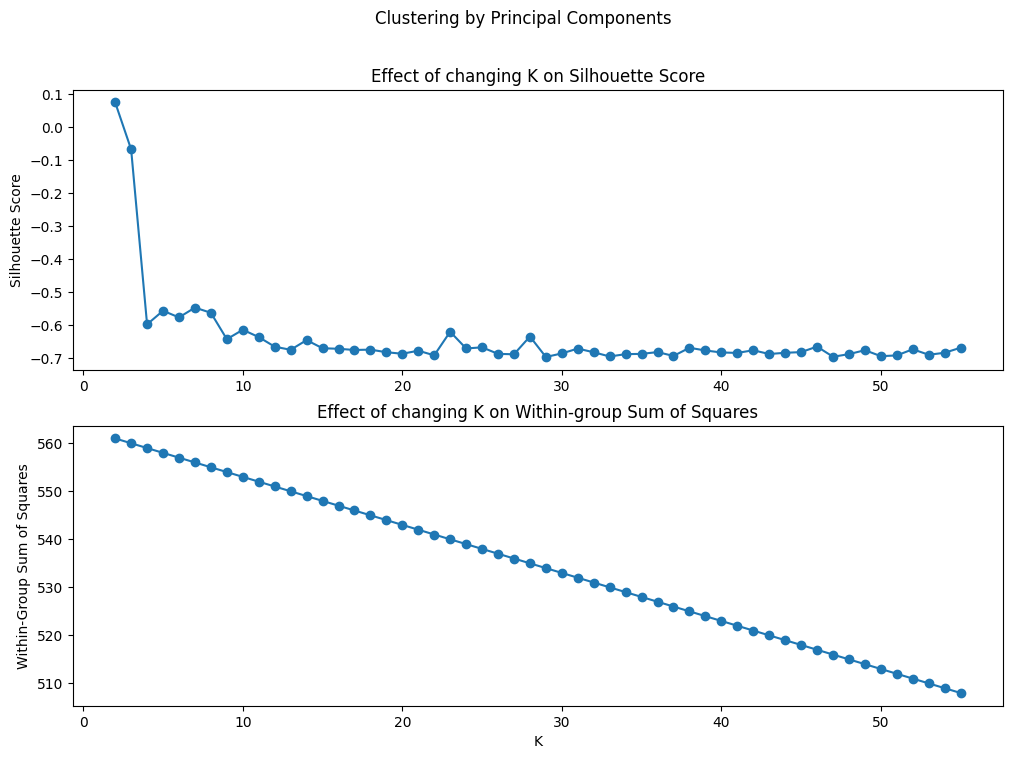

In [ ]:
kvals = np.arange(2,56)
sil_vals = []
wss_vals = []
for k in kvals:
   kmeans = KMeans(n_clusters=k, random_state=5322, n_init=50).fit(U[:,:]);
   silscore = metrics.silhouette_score(df_scaled, kmeans.labels_, metric='euclidean')
   sil_vals.append(silscore)
   wss_vals.append(kmeans.inertia_)

fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(kvals, sil_vals, linestyle='-', marker='o')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title("Effect of changing K on Silhouette Score");

ax[1].plot(kvals, wss_vals, linestyle='-', marker='o')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Within-Group Sum of Squares')
ax[1].set_title("Effect of changing K on Within-group Sum of Squares")
fig.suptitle("Clustering by Principal Components");

When clustering by principal components, the silhouette score begins at a much lower value than before, and drops quickly between 3 and 4 clusters. The within-group sum of squares is much less than what was seen with clustering based on the original scaled data.

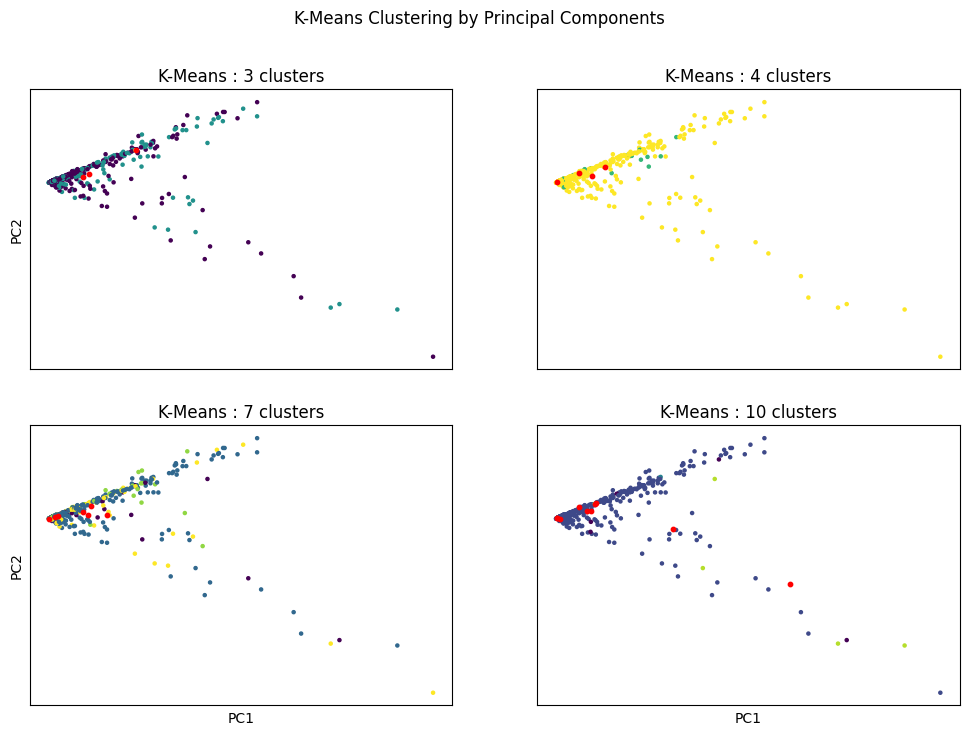

In [ ]:
# Number of cluster centers for KMeans
n_clusters_list = [3, 4, 7, 10]

# Algorithms to compare
clustering_algorithms = {
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(2, 2, figsize=(12,8))
#     len(clustering_algorithms), len(n_clusters_list), figsize=(12, 5)
# )
fig.suptitle("K-Means Clustering by Principal Components")
axs = axs.T

i_ct = 0 #Row
j_ct = 0 #Col
k_means_labels_locs_u = {}
for j, n_clusters in enumerate(n_clusters_list):
    #algo = Algorithm(n_clusters=n_clusters, random_state=5322, n_init=50)
    algo = KMeans(n_clusters=n_clusters, random_state=5322, n_init=50)
    algo.fit(U[:,:])
    centers = algo.cluster_centers_
    axs[j_ct,i_ct].scatter(U[:,0], U[:,1], s=5, c=algo.labels_)
    axs[j_ct,i_ct].scatter(centers[:, 0], centers[:, 1], c="r", s=10)
    axs[j_ct,i_ct].set_title(f"K-Means : {n_clusters} clusters")
    axs[j_ct,i_ct].set_xlabel('PC1')
    axs[j_ct,i_ct].set_ylabel('PC2')
    #
    for i in set(algo.labels_):
        ind_locs = []
        for h in range(0,len(algo.labels_)):
            if algo.labels_[h] == i:
                ind_locs.append(h)
            k_means_labels_locs_u[str(n_clusters)+"_"+str(i)] = ind_locs
    #
    if j_ct < 1:
        j_ct += 1
    else:
        i_ct +=1
        j_ct = 0

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

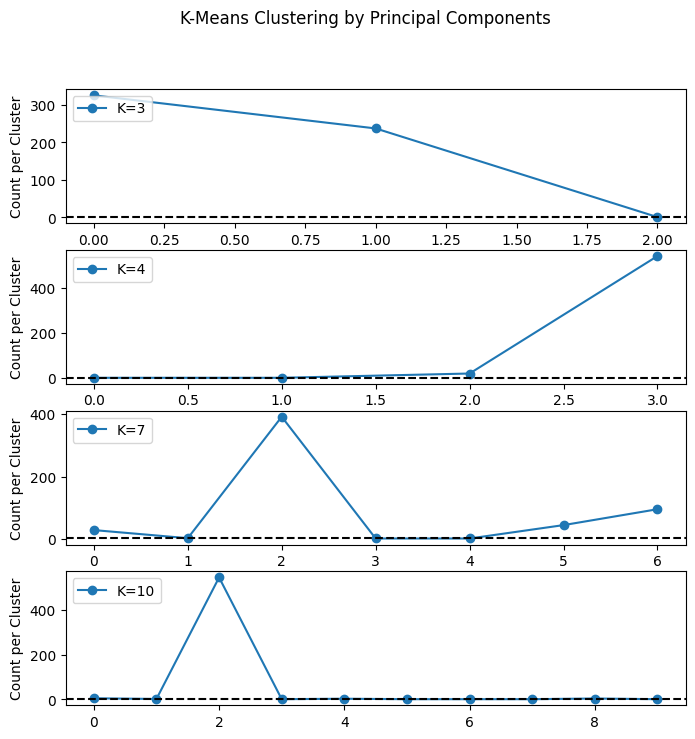

In [ ]:
#k_means_labels_locs
#Have 3, 5 15, 22, each have that many groups
k_means_ct = {}
k_vals = [3, 4, 7, 10]
for ks in k_vals:
    ks_ct = []
    for i in range(0,ks):
        ks_ct.append(len(k_means_labels_locs_u[str(ks)+"_"+str(i)]))
    k_means_ct[str(ks)] = ks_ct

fig, axs = plt.subplots(4, 1, figsize=(8,8))
fig.suptitle("K-Means Clustering by Principal Components")
axs[3].plot(np.arange(10), k_means_ct["10"], "-o")
axs[2].plot(np.arange(7), k_means_ct["7"], "-o")
axs[1].plot(np.arange(4), k_means_ct["4"], "-o")
axs[0].plot(np.arange(3), k_means_ct["3"], "-o")
for i in range(0,4):
    axs[i].axhline(y=1, color = 'k', linestyle ="--")
    #axs[i].set_title("K="+str(n_clusters_list[i]))
    axs[i].legend(["K="+str(n_clusters_list[i])], loc='upper left')
    axs[i].set_ylabel('Count per Cluster')

plt.show();

Clustering based on principal components seems to provide less information regarding groupings than clustering based on the original scaled data. For clusters of 4, 7, and 10, there really is only one group having all of the sample data points, and then a few getting removed to make up the other groups. Only at K=3 clusters do we really see two groups that have a comparable number of data points between them. However, looking at the scatter plots, the two groups seem to overlap almost entirely along the top 2 principal components without a clear separation between them.

Considering this, further analysis into what conclusions can be drawn regarding trends in the hospital data will be done on the clusters determined from the original data with k=5.

### Group Comparisons for K-Means with Scaled Data

In [ ]:
k5 = KMeans(n_clusters=5, random_state=5322, n_init=50).fit(df_scaled)
k5_locs = {}
for i in set(k5.labels_):
    ind_locs = []
    for h in range(0,len(k5.labels_)):
        if k5.labels_[h] == i:
            ind_locs.append(h)
        k5_locs[str(i)] = ind_locs

In [ ]:
for i in k5_locs.keys():
    print("Group",i, "has", len(k5_locs[i]), "samples",
         "\nThis includes",len(set(df_agg.loc[k5_locs[i],'Hospital Name'])) , "hospitals and",len(set(df_agg.loc[k5_locs[i],'Year'])), "years")

Group 0 has 100 samples 
This includes 22 hospitals and 7 years
Group 1 has 412 samples 
This includes 84 hospitals and 7 years
Group 2 has 19 samples 
This includes 13 hospitals and 3 years
Group 3 has 27 samples 
This includes 6 hospitals and 6 years
Group 4 has 5 samples 
This includes 4 hospitals and 2 years


In [ ]:
df_agg.loc[k5_locs['3'],['Hospital Name','Year']]

Hospital Name  Year
145                         Harborview Medical Center  2018
146                         Harborview Medical Center  2019
147                         Harborview Medical Center  2020
148                         Harborview Medical Center  2021
149                         Harborview Medical Center  2022
150                         Harborview Medical Center  2023
395                       Sacred Heart Medical Center  2021
404                       Seattle Children's Hospital  2018
405                       Seattle Children's Hospital  2019
406                       Seattle Children's Hospital  2020
407                       Seattle Children's Hospital  2021
408                       Seattle Children's Hospital  2022
485  Swedish Health Services DBA Swedish Medical Cent  2018
486  Swedish Health Services DBA Swedish Medical Cent  2019
487  Swedish Health Services DBA Swedish Medical Cent  2020
488  Swedish Health Services DBA Swedish Medical Cent  2021
489  Swedish Health Services DBA Swedish Medical Cent  2022
521           University of Washington Medical Center  2018
522           University of Washington Medical Center  2019
523           University of Washington Medical Center  2020
524           University of Washington Medical Center  2021
525           University of Washington Medical Center  2022
526           University of Washington Medical Center  2023
540                     Virginia Mason Medical Center  2018
541                     Virginia Mason Medical Center  2019
542                     Virginia Mason Medical Center  2020
544                     Virginia Mason Medical Center  2022

In [ ]:
df_agg.loc[k5_locs['4'],['Hospital Name','Year']]

Hospital Name  Year
116            Fred Hutchinson Cancer Center  2023
117            Fred Hutchinson Cancer Center  2024
151                Harborview Medical Center  2024
409              Seattle Children's Hospital  2023
527  University of Washington Medical Center  2024

Groups 3 and 4 both contain large medical centers, with those in Group 4 especially being centers for research as well. Group 4 does see hospitals for just the years 2023 and 2024, similar to the trends observed in the hierarchical clustering. Fred Hutchinson Cancer Center is the only hospital appearing in Group 4 that did not appear in Group 3.

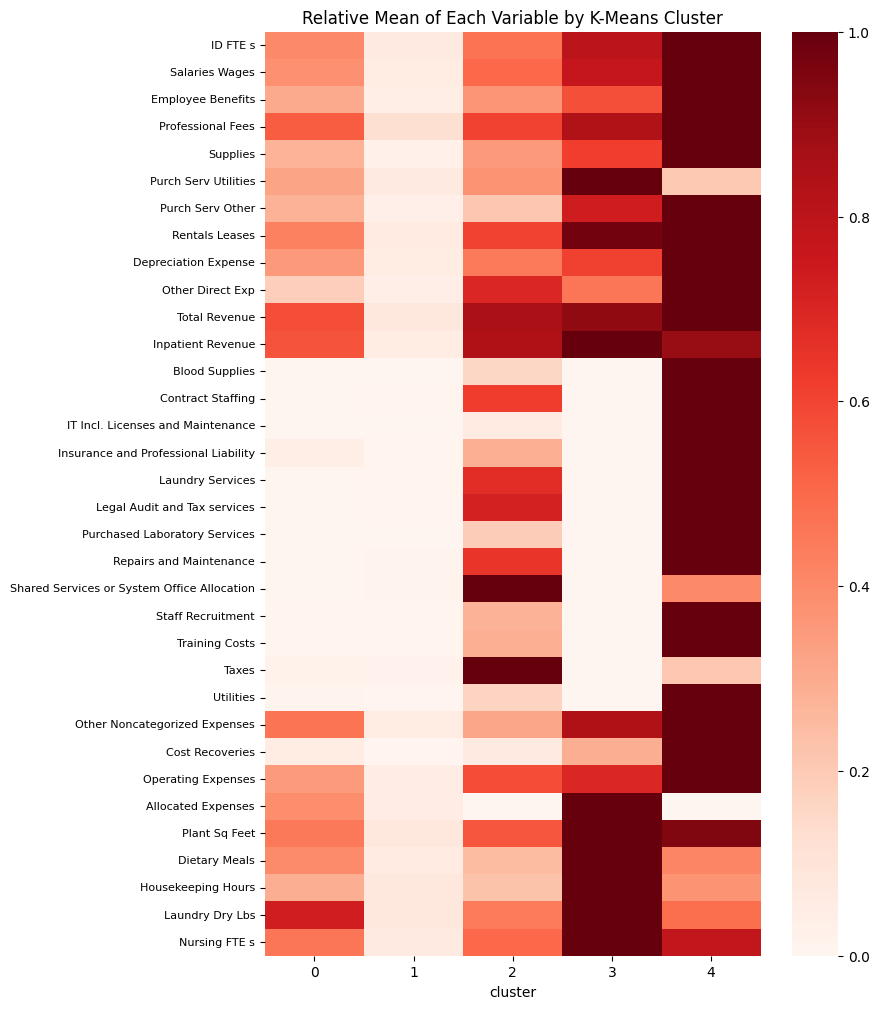

In [ ]:
df_agg_cluster = df_agg[numeric_cols].copy()
df_agg_cluster['cluster'] = k5.labels_
df_agg_cluster = df_agg_cluster.groupby('cluster').mean()
df_agg_cluster_1 = pd.DataFrame(data = {df_agg_cluster.columns[0]:df_agg_cluster[df_agg_cluster.columns[0]]/df_agg_cluster.max(axis=0).iloc[0]})
for j in range(1,df_agg_cluster.shape[1]):
    col = df_agg_cluster.columns[j]
    if col == 'Information Technology Including Licenses and Maintenance':
        df_agg_cluster_1['IT Incl. Licenses and Maintenance'] = df_agg_cluster[df_agg_cluster.columns[j]]/df_agg_cluster.max(axis=0).iloc[j] #Making this name shorter
    else:
        df_agg_cluster_1[col] = df_agg_cluster[df_agg_cluster.columns[j]]/df_agg_cluster.max(axis=0).iloc[j]

plt.figure(figsize=(8,12))
sns.heatmap(df_agg_cluster_1.T, annot=True, cmap='Reds');
plt.yticks(fontsize=8)
plt.title("Relative Mean of Each Variable by K-Means Cluster");

In [ ]:
hosp_0 = list(set(df_agg.loc[k5_locs['0'],'Hospital Name']))
hosp_2 = list(set(df_agg.loc[k5_locs['2'],'Hospital Name']))
hosps = list(set(hosp_0 + hosp_2))
hosp_in = []
for hosp in list(set(hosp_0 + hosp_2)):
    if hosp in hosp_0:
        if hosp in hosp_2:
            hosp_in.append("Both")
        else:
            hosp_in.append("0")
    else:
        hosp_in.append("2")
pd.DataFrame(data={"Hospital":hosps, "Cluster":hosp_in}).sort_values('Cluster')

Despite Groups 3 and 4 being the same hospitals, they do have some different values per variable. Because these seem to be large medical centers, it makes sense that they tend to have the highest values for any of these variables, since they would require more resources overall. But, many of the variables in Group 3 had means of , while those same variables were reported at the highest averages among all the data entries for Group 4. Specifically, these are the variables Blood Supplies, Contract Staffing, Information Technology Including Licenses and Maintenance, Insurance and Professional Liability, Laundry Services, Legal Audit and Tax services, Purchased Laboratory Services, Repairs and Maintenance, Shared Services or System Office Allocation, Staff Recruitment, Training Costs, Taxes, and Utilities.

This could mean that potentially in only the last couple years, those large hospitals started reporting these values, and this difference is driving the split between Groups 3 and 4.

Group 1 has the lowest average values, indicating these are the smaller hospitals within the state. These do include both hospitals found within urban city limits (e.g. Kaiser Permanente Central Hospital, Shriners Hospitals for Children - Spokane) and hospitals serving more rural areas (e.g. East Adams Rural Healthcare, Confluence Health: Wenatchee Valley Hospital). Had the data been provided with a description of which hospitals are rural versus urban, it would have been interesting to see what would drive the difference between the two types if the hospitals within Group 1 were to be clustered further.

Groups 0 and 2 tend to have mid values for the variables, except for Group 0 having the same chunk of variables being set near or at 0 as Group 3. Similar to how those variables seem to be what drives the difference between Groups 3 and 4, they likely are what is causing the Group 2 to split from Group 0. Between those two groups, there is only one hospital that exists only within Group 2 ('Swedish Health Services DBA Swedish Medical Cent'), but it does appear likely to be a typo from a hospital found in both Groups 0 and 2 ('Swedish Health Services DBA Swedish Medical Cente').

The results between hierarchical clustering and K-means clustering look comparable: the groups that the data are getting split into are generally those that are large hospitals, medium-sized hospitals, and small hospitals. This makes sense, since one would expect that the larger a hospital is in size, the greater magnitude of financial responsibilities for that hospital. But the subgroupings then occurring within the large- and medium-sized hospital groups do appear to be heavily influenced by the presence or lack of certain data within the dataset.

# **Discussion**

This deteset provided a unique challenge of including multiple zero entries, varying signs, and a data dictionary that did not provide further information regarding how data was collected. Despite these issues, matrix completion was still used successfully to resolve clear mis-entries within the data. Additionally, when clustering by both hierarchical clustering and k-means clustering, the data shows reaslistic trends within the final groupings.

From the scree plot, we could see a signficant amount of the variance, >40%, being explained by even just the first PC. Additionally, fewer than 10 PCs needed to be included to get up to 90% of the variance being explained. This tells us that, despite having 34 numeric variables, the dimensionality can be reduced to fewer principal components while still capturing the majority of the trends in the data.

$U$ comprises principal component vectors $z_i$, where $z_i=\phi_1X_1+...+\phi_nX_n$. The $z_i$'s are therefore just a linear combination of the original features. With our data, each principal component would be a combination of variables. Consider, for example, our first principal component, which had as it's largest coefficients associated with Operating Expenses (0.25), Salaries/ Wages (0.24), and Total Revenue (0.23). Principal component 1 might be understood as some combination of these features, perhaps having to do with a hospital's largest cost. Compare this with the second principal components, which had largest coefficients associated with Contract Staffing, Laundry Services, and Repairs and Maintenance. This principal components seems to be associated with expenses not necessarily associated with the operations of the hospital but rather amenities. Our $U$ matrix will be full of these principal components, representing potentially groups of features. Considering this, and the scree plot, this tells us that over half of the variation in our data could be explained by these two PCs. But, the magnitudes of each variable in $U$ were close, indicating that there is no singular variable really driving either PC.

Let's now discuss $V^{T}$, which is a matrix full of the loadings (with respect to PCA) of our principal components. The loadings can be understood as a direction vector for our principal components. While they give direction, they are standardized not to have differing magnitudes. The loadings are just the $\phi$'s mentioned above. They, for instance, give weights to the initial features $X_i$ and determine how our $X_i$'s influence the principal components. Let's consider the coefficients above. For example, the $\phi$ associated with the first principal component's operating expenses variable was 0.25, indicating that operating expenses have a significant effect on the first principal component and that it heavily depends on operating expenses.

After hierarchical clustering, 4 main groups emerged: Cluster 1, made of small/low resource hospitals with tight budgets and low infrastructure; Cluster 2 with urban hospitals with balanced employee-related costs and purchased services; Cluster 3 with hospital experiencing some cost restructuring, decrease in employee-related expenses, increased reliance on purchased services or administrative changes; and Cluster 4, made of large, high-cost, and involved in technologically advanced research. Performing K-means to produce 5 clusters also led to a similar grouping of the hospitals, though some of the splits appeared to be driven by what were likely missing values within the data as opposed to meaningful trends between hospitals.

Despite likely issues and inconsistencies in data collection, overall trends between hospitals still emerged. Similar analyses could be done and extended to continue to better characterize the performances of and resources available within each hospital. This would ideally be carried out with a dataset that does have more well-defined variables.


# **References**

[1] Baranowski, Carrie. Mar. 10, 2025. Hofidar Cost Center Report. *data.wa.gov*. https://data.wa.gov/d/hegm-swm4

[2] HHS Office of the Chief Data Officer. Mar. 10, 2025. Hofidar Cost Center Report. *HealthData.gov*. https://healthdata.gov/State/Hofidar-Cost-Center-Report/bs27-3ctf/about_data

[3] James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (1st ed.) Springer.